# Task 2 - Use of neural networks
 
## Data Source

 * The data source consists of the files `train.csv` and `evaluate.csv`.
 * These are 32x32 pixel grayscale images obtained from the [Fashion Mnist dataset](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * The `train.csv` file contains training data.
 * The target variable is named **label**.
 * The `evaluate.csv` file contains testing data without actual label values.

## Instructions for project development

**Assignment Instructions**:
  * In the notebook, load data from the `train.csv` file. Divide it into subsets that will be used for training, model comparison, and subsequent prediction of the final model's performance.
  * Perform basic data exploration and discuss your observations. Also, display some graphs and images.
      
  * Build and train several variants of a feedforward neural network model. Within computational capabilities:
      * Comment on the suitability of the model for the given task.
      * Experiment with different depths and sizes of layers.
      * Experiment with data standardization/normalization.
      * Experiment with various optimization methods.
      * Experiment with various regularization techniques.
      * Always provide proper comments on the obtained results.

  * Construct a convolutional neural network model. Within computational capabilities:
      * Comment on the suitability of the model for the given task.
      * Experiment with different depths and sizes of layers.
      * Experiment with data standardization/normalization.
      * Experiment with various optimization methods.
      * Experiment with various regularization techniques.
      * Always provide proper comments on the obtained results.
    
  * From all the tested options, select the final model and estimate the accuracy you can expect on new data that you have not had access to so far.

  * Finally, load the evaluation data from the `evaluate.csv` file. Use the final model to calculate predictions for this data (the explained variable is no longer present). Create a `results.csv` file in which you save the obtained predictions in two columns: **ID**, **label prediction**. Submit this file as well (save it in the project alongside the notebook).

   * Example of the first lines of the `results.csv` file:
  
```
ID,label
0,0
1,1
...
```

## Let's Start

### Getting to know the data

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline


import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv("train.csv")

In [3]:
print(f"Data dimensions: {data.shape}")
print(f"Amount of unique values of target variable: {data['label'].nunique()}")
print(f"Unique values of target variable: {data['label'].unique()}")
print(f"Data types of all variables:\n{data.dtypes.value_counts().to_string(index=True, name=False)}")
display(data.head(10))

Data dimensions: (56000, 1025)
Amount of unique values of target variable: 10
Unique values of target variable: [7 0 6 3 4 8 1 9 2 5]
Data types of all variables:
int64    1025


pix1  pix2  pix3  pix4  pix5  pix6  pix7  pix8  pix9  pix10  ...  pix1016   
0     1     1     1     1     1     1     1     1     1      1  ...        1  \
1     4     4     4     4     4     4     5     5     5      6  ...        4   
2     0     0     0     0     0     0     0     0     0      0  ...        0   
3     2     2     2     2     2     2     2     2     2      2  ...        2   
4     0     0     0     0     0     0     0     0     0      0  ...        0   
5     0     0     0     0     0     0     0     0     0      0  ...        0   
6     2     2     2     2     2     2     2     2     2      2  ...        2   
7     0     0     0     0     0     0     0     0     0      0  ...        0   
8     6     6     6     6     6     6     6     6     6      6  ...        6   
9     0     0     0     0     0     0     0     0     0      0  ...        0   

   pix1017  pix1018  pix1019  pix1020  pix1021  pix1022  pix1023  pix1024   
0        1        1        1        1        1        1        1        1  \
1        4        4        4        4        4        4        4        4   
2        0        0        0        0        0        0        0        0   
3        2        2        2        2        2        2        2        2   
4        0        0        0        0        0        0        0        0   
5        0        0        0        0        0        0        0        0   
6        2        2        2        2        2        2        2        2   
7        0        0        0        0        0        0        0        0   
8        6        6        6        6        6        6        6        6   
9        0        0        0        0        0        0        0        0   

   label  
0      7  
1      0  
2      6  
3      3  
4      3  
5      7  
6      7  
7      7  
8      6  
9      4  

[10 rows x 1025 columns]

There are 10 possible values of the target variable, that we can predict, which means we are dealing with `multiclass classification`.</br>
It is also important to notice, that we have `1024 features`, so our data is `high-dimensional`. It suggests that more complex models, such as `neural networks`, may be suitable for capturing intricate patterns in our data. </br>
Fortunately, we only have `numeric features`, so we won't need to deal with data preprocessing.

In [4]:
samples_per_class = np.array([])
for target in range (data['label'].nunique()):
    samples_per_class = np.append(samples_per_class, data[data['label']==target].shape[0])
    print(f"Amount of samples with target variable {target}: {samples_per_class[target]}")
print(f"Standard deviation in sample counts among the classes - {np.sqrt(np.var(samples_per_class)):.2f}")

Amount of samples with target variable 0: 5627.0
Amount of samples with target variable 1: 5562.0
Amount of samples with target variable 2: 5645.0
Amount of samples with target variable 3: 5628.0
Amount of samples with target variable 4: 5605.0
Amount of samples with target variable 5: 5618.0
Amount of samples with target variable 6: 5570.0
Amount of samples with target variable 7: 5557.0
Amount of samples with target variable 8: 5571.0
Amount of samples with target variable 9: 5617.0
Standard deviation in sample counts among the classes - 30.35


The distribution seems `relatively balanced`, with a small variance in sample counts among the classes. Balanced class distribution is desirable as it `prevents the model from being biased` towards one or a few dominant classes. It is also good, because we can use `accuracy score` as evaluation metric.

In [5]:
data.columns[data.isnull().any()]

Index([], dtype='object')

There are no null values present in our data. Remove possible `duplicates` from the table.

In [6]:
data.drop_duplicates(inplace=True)
print(f"Data dimensions after dropping duplicates: {data.shape}")

Data dimensions after dropping duplicates: (56000, 1025)


There are no duplicates in our data

### Analyzing the data

Dividing the data into `features` and `label`, that we want to predict.

In [7]:
features = data.drop("label", axis=1)
label = data["label"]

Let's start by taking a look at what our pictures look like in general.

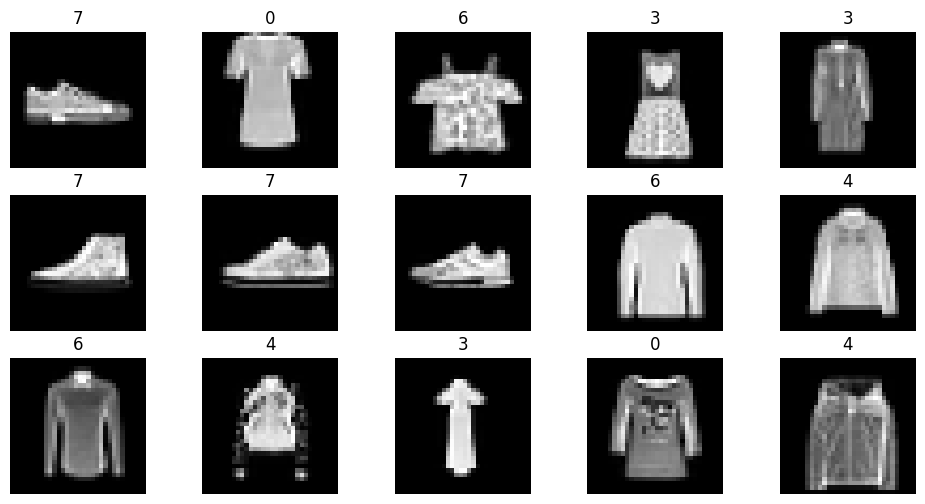

In [8]:
figure = plt.figure(figsize=(12, 6))
rows, cols = 3, 5

for i in range(0, rows * cols):
    img = features.iloc[i].values.reshape(32, 32)
    lab = label[i]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f"{lab}")
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

As we can see, our task is to recognize what type of `clothing` is depicted in the image. We are going to solve `image classification` problem.

Let's proceed with the analysis of each individual pixel. First, let's examine the number of unique values for each pixel.

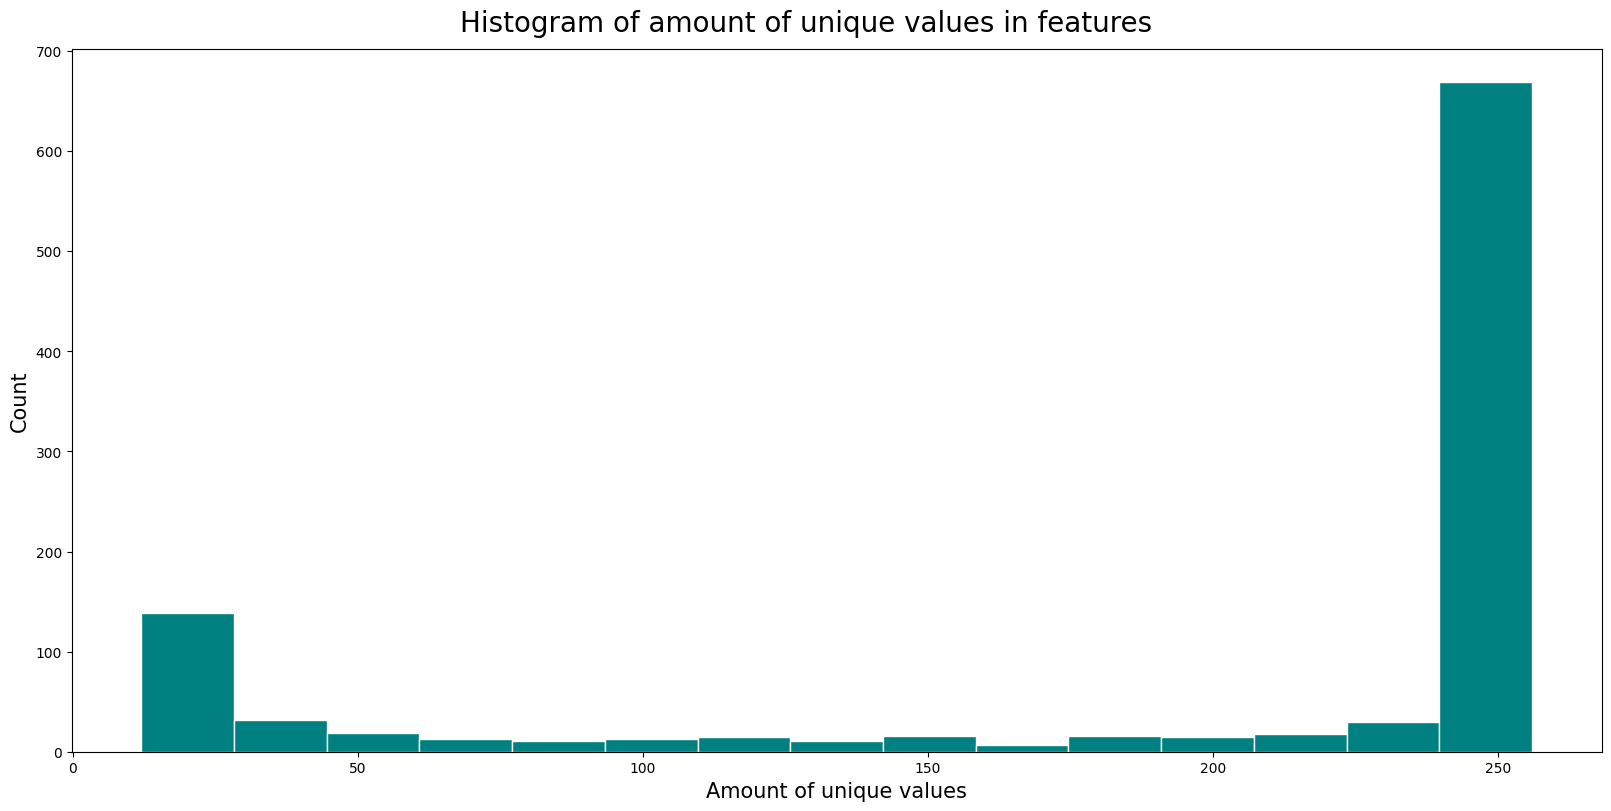

In [9]:
plt.figure(figsize = (16,8), constrained_layout=True)
plt.suptitle("Histogram of amount of unique values in features", fontsize=20)
plt.hist(features.nunique(), bins=15, edgecolor="white", color="teal")
plt.xlabel("Amount of unique values", fontsize=15)
_ = plt.ylabel("Count", fontsize=15)

As we can see from the graph, the vast majority of pixels take on all or `almost all possible values` depending on the image.

In [10]:
print(f"Columns with a low amount of unique values:\n{features.columns[features.nunique()<10]}")

Columns with a low amount of unique values:
Index([], dtype='object')


In [11]:
print(f"Columns with all possible values:\n{features.columns[features.nunique()==256]}")

Columns with all possible values:
Index(['pix78', 'pix79', 'pix80', 'pix81', 'pix82', 'pix83', 'pix107',
       'pix108', 'pix109', 'pix110',
       ...
       'pix940', 'pix941', 'pix942', 'pix943', 'pix944', 'pix945', 'pix946',
       'pix947', 'pix948', 'pix949'],
      dtype='object', length=579)


To sum up, there is no pixel in our dataset, that take on less than 10 different values, which means that every pixel in our dataset `provide some information`, so we shouldn't drop any of them. Moreover, 579 from 1024 pixels may take on all possible values.

Now let's take a look at the histogram of `standard deviations`.

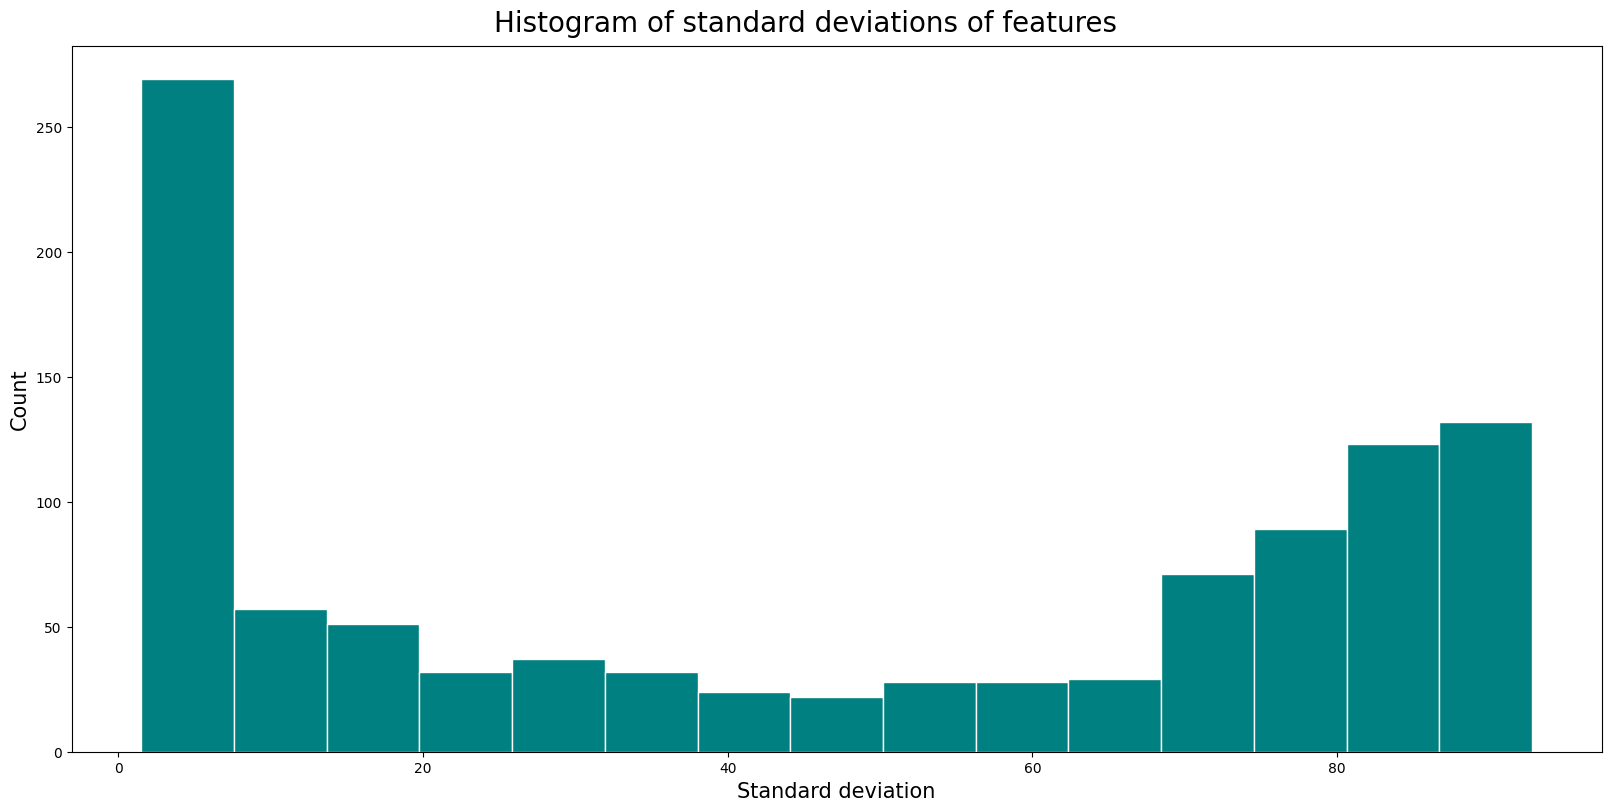

In [12]:
plt.figure(figsize = (16,8), constrained_layout=True)
plt.suptitle("Histogram of standard deviations of features", fontsize=20)
plt.hist(features.std(), bins=15, edgecolor="white", color="teal")
plt.xlabel("Standard deviation", fontsize=15)
_ = plt.ylabel("Count", fontsize=15)

However, if we look at the histogram of standard deviations for all these pixels, we will observe that the majority of pixels have `low standard deviation` (less than 10). This indicates that although the pixels can take on a large number of different values, these values often do not differ significantly from each another.

In [13]:
variances = features.var().sort_values(ascending=False)
print(f"10 features with the highest variance:\n{variances.head(10)}\n")
print(f"10 features with the lowest variance:\n{variances.tail(10)}")

10 features with the highest variance:
pix209    8611.763631
pix208    8607.083988
pix177    8559.701759
pix176    8559.060860
pix210    8389.686951
pix207    8380.865495
pix178    8374.953345
pix175    8357.739307
pix817    8350.709878
pix816    8350.090468
dtype: float64

10 features with the lowest variance:
pix97      2.230872
pix128     2.230872
pix160     2.230872
pix192     2.230872
pix2       2.230872
pix961     2.230872
pix992     2.230872
pix993     2.230872
pix1024    2.230872
pix960     2.230859
dtype: float64


Now let's look on variance depending on class. By calculating the sum of variances for each class separately, we can assess the `pixel-level diversity` or spread of values within the images belonging to that class.

In [14]:
for target in range (data['label'].nunique()):
    print(f"The sum of variances for all pixels in the images with label {target}: {sum(data[data['label']==target].var()):.2f}")

The sum of variances for all pixels in the images with label 0: 2252701.21
The sum of variances for all pixels in the images with label 1: 1700482.83
The sum of variances for all pixels in the images with label 2: 2527818.67
The sum of variances for all pixels in the images with label 3: 1909915.64
The sum of variances for all pixels in the images with label 4: 2297585.10
The sum of variances for all pixels in the images with label 5: 1957841.43
The sum of variances for all pixels in the images with label 6: 2436899.76
The sum of variances for all pixels in the images with label 7: 1565887.06
The sum of variances for all pixels in the images with label 8: 3011432.60
The sum of variances for all pixels in the images with label 9: 3576610.12


The sum of variances can significantly differ across different classes. A higher sum of variances indicates greater pixel-level variability, suggesting that the images in that class may contain `diverse patterns, textures, or structures`. In our case the highest value of sum of variances have images with label 9 (i.e. Ankle boot) and the lowest - 7 (i.e. Sneaker), what is strange, to be honest.

Now let's play around with `correlations` a bit.

In [15]:
corr_matrix = features.corr()
corr_matrix

pix1      pix2      pix3      pix4      pix5      pix6      pix7   
pix1     1.000000  1.000000  1.000000  1.000000  0.999996  0.999996  0.999988  \
pix2     1.000000  1.000000  1.000000  1.000000  0.999996  0.999996  0.999988   
pix3     1.000000  1.000000  1.000000  1.000000  0.999996  0.999996  0.999988   
pix4     1.000000  1.000000  1.000000  1.000000  0.999996  0.999996  0.999988   
pix5     0.999996  0.999996  0.999996  0.999996  1.000000  1.000000  0.999992   
...           ...       ...       ...       ...       ...       ...       ...   
pix1020  0.999740  0.999740  0.999740  0.999740  0.999736  0.999736  0.999728   
pix1021  0.999976  0.999976  0.999976  0.999976  0.999972  0.999972  0.999964   
pix1022  0.999996  0.999996  0.999996  0.999996  0.999992  0.999992  0.999984   
pix1023  1.000000  1.000000  1.000000  1.000000  0.999996  0.999996  0.999988   
pix1024  1.000000  1.000000  1.000000  1.000000  0.999996  0.999996  0.999988   

             pix8      pix9     pix10  ...   pix1015   pix1016   pix1017   
pix1     0.999924  0.958440  0.846720  ...  0.836706  0.740962  0.740719  \
pix2     0.999924  0.958440  0.846720  ...  0.836706  0.740962  0.740719   
pix3     0.999924  0.958440  0.846720  ...  0.836706  0.740962  0.740719   
pix4     0.999924  0.958440  0.846720  ...  0.836706  0.740962  0.740719   
pix5     0.999928  0.958444  0.846723  ...  0.836703  0.740958  0.740716   
...           ...       ...       ...  ...       ...       ...       ...   
pix1020  0.999664  0.958190  0.846498  ...  0.838113  0.741961  0.741856   
pix1021  0.999900  0.958417  0.846699  ...  0.837339  0.741464  0.741093   
pix1022  0.999920  0.958436  0.846716  ...  0.836709  0.740958  0.740716   
pix1023  0.999924  0.958440  0.846720  ...  0.836706  0.740962  0.740719   
pix1024  0.999924  0.958440  0.846720  ...  0.836706  0.740962  0.740719   

          pix1018   pix1019   pix1020   pix1021   pix1022   pix1023   pix1024  
pix1     0.757850  0.945746  0.999740  0.999976  0.999996  1.000000  1.000000  
pix2     0.757850  0.945746  0.999740  0.999976  0.999996  1.000000  1.000000  
pix3     0.757850  0.945746  0.999740  0.999976  0.999996  1.000000  1.000000  
pix4     0.757850  0.945746  0.999740  0.999976  0.999996  1.000000  1.000000  
pix5     0.757846  0.945742  0.999736  0.999972  0.999992  0.999996  0.999996  
...           ...       ...       ...       ...       ...       ...       ...  
pix1020  0.759527  0.946965  1.000000  0.999820  0.999736  0.999740  0.999740  
pix1021  0.758016  0.945858  0.999820  1.000000  0.999972  0.999976  0.999976  
pix1022  0.757846  0.945741  0.999736  0.999972  1.000000  0.999996  0.999996  
pix1023  0.757850  0.945746  0.999740  0.999976  0.999996  1.000000  1.000000  
pix1024  0.757850  0.945746  0.999740  0.999976  0.999996  1.000000  1.000000  

[1024 rows x 1024 columns]

In [16]:
np.fill_diagonal(corr_matrix.values, np.nan) #To avoid working with values on the diagonal, which are always equal to 1
am_high_corr = (corr_matrix>0.85).values.sum()/2
am_low_corr = (corr_matrix<-0.85).values.sum()/2
print(f"Amount of pairs with correlation higher than 0.85 - {am_high_corr:.0f}")
print(f"Amount of pairs with correlation lower than -0.85 - {am_low_corr:.0f}")
print(f"Amount of pairs with correlation equals to 1 - {(corr_matrix==1).values.sum()/2:.0f}")

Amount of pairs with correlation higher than 0.85 - 6169
Amount of pairs with correlation lower than -0.85 - 0
Amount of pairs with correlation equals to 1 - 352


We have more than 6000 positively highly correlated pairs, but we don't have any negatively highly correlated pairs, which is interesting. </br>
At first, it may seem like 6169 pairs is a lot, but considering that we have more than 500,000 pairs of features in this dataset overall, it's `not such a large number`, which is certainly a `good sign` for our future neural networks, as a high percentage of strongly correlated pairs of features can lead to overfitting, redundancy, unnecessary complexity and increasing of training time and resource requirements. </br>
However, there are 352 pairs of features that are `perfectly positively correlated`. There is a linear relationship between the two features in each pair, and as one feature increases, the other feature also increases proportionally. With perfect correlation (correlation coefficient = 1), one of the features in each pair provides redundant information since it is completely predictable from the other feature. This gives us a reason to consider potential `feature selection` to reduce the redundancy of our model. However, for now, we will leave this as a possible improvement for the future. 

Let's look at the correlations between the `target variable` and `features`.

In [17]:
correlations_with_label = pd.Series()
for feature in features.columns:
    correlations_with_label[feature] = features[feature].corr(label)

In [18]:
correlations_with_label.describe()

count    1024.000000
mean        0.003304
std         0.228381
min        -0.618876
25%        -0.091563
50%        -0.001609
75%         0.127770
max         0.509447
dtype: float64

In [19]:
print(f"10 features with the highest correlation with the target variable:\n{correlations_with_label.nlargest(10)}\n")
print(f"10 features with the lowest correlation with the target variable:\n{correlations_with_label.nsmallest(10)}")

10 features with the highest correlation with the target variable:
pix667    0.509447
pix646    0.508590
pix635    0.507363
pix614    0.505155
pix666    0.499825
pix634    0.499272
pix647    0.497920
pix603    0.497448
pix615    0.496236
pix582    0.494590
dtype: float64

10 features with the lowest correlation with the target variable:
pix178   -0.618876
pix175   -0.614552
pix179   -0.613782
pix174   -0.612472
pix177   -0.608323
pix176   -0.607578
pix209   -0.598762
pix210   -0.597152
pix208   -0.596916
pix207   -0.595254
dtype: float64


In [20]:
am_weak_corr = correlations_with_label[(correlations_with_label>-0.3) & (correlations_with_label<0.3)].count()
print(f"Amount of features, that are weakly correlated with target variable - {am_weak_corr:.0f}")

Amount of features, that are weakly correlated with target variable - 803


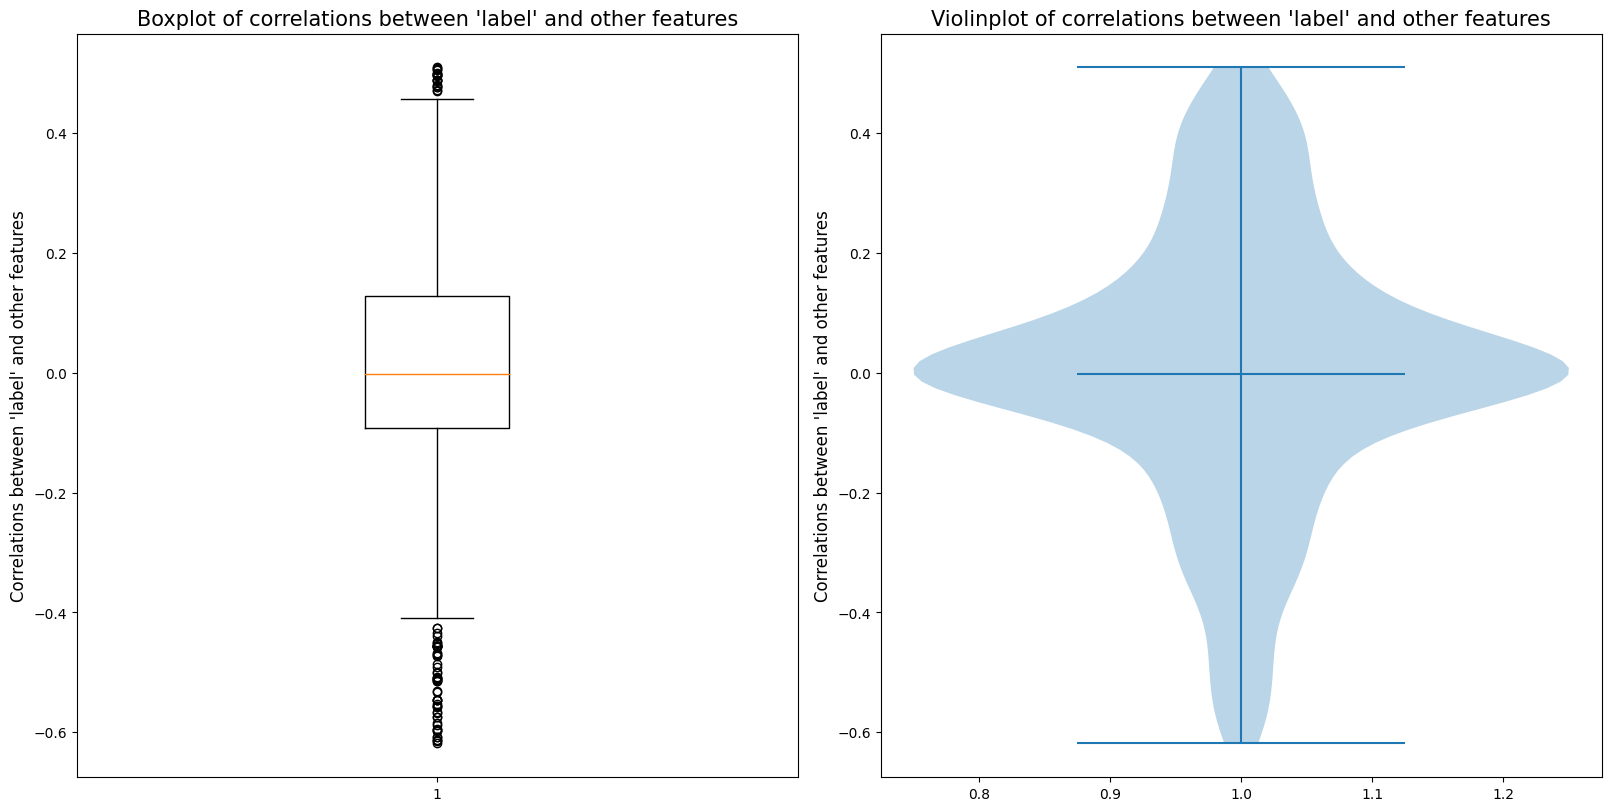

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8), constrained_layout=True)

ax1.set_title("Boxplot of correlations between 'label' and other features", fontsize=15)
ax1.set_ylabel("Correlations between 'label' and other features", fontsize=12)
ax1.boxplot(correlations_with_label, widths=0.2)

ax2.set_title("Violinplot of correlations between 'label' and other features", fontsize=15)
ax2.set_ylabel("Correlations between 'label' and other features", fontsize=12)
_ = ax2.violinplot(correlations_with_label, showmedians=True)

As we can see, the vast majority of features (over 80%) are `weakly correlated with the target variable`, and there are no strongly correlated features (the biggest absolute value of correlation is near 0.62), that indicates that `none of the features` in our dataset have a strong linear relationship with the target variable (which is not a problem for neural networks).

### Preparing data for neural networks

Splitting up our dataset into `train`, `validation` and `test` subsets.

In [22]:
rd_seed = 143

Xtrain, Xtest, ytrain, ytest = train_test_split(features, label, test_size=0.15, random_state=rd_seed)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.16772, random_state=rd_seed)

print(f"Train features dimensions: {Xtrain.shape}")
print(f"Train target variable dimensions: {ytrain.shape}")
print(f"Validation features dimensions: {Xval.shape}")
print(f"Validation target variable dimensions: {yval.shape}")
print(f"Test features dimensions: {Xtest.shape}")
print(f"Test target variable dimensions: {ytest.shape}")

Train features dimensions: (39616, 1024)
Train target variable dimensions: (39616,)
Validation features dimensions: (7984, 1024)
Validation target variable dimensions: (7984,)
Test features dimensions: (8400, 1024)
Test target variable dimensions: (8400,)


Let's also prepare `standardised data`.

In [23]:
scaler = StandardScaler()

Xtrain_scaled = scaler.fit_transform(Xtrain)
Xval_scaled = scaler.transform(Xval)
Xtest_scaled = scaler.transform(Xtest)

Convert all these subsets to `tensors` and reshape each tensor into a 4-dimensional tensor with dimensions (`NUMBER OF SAMPLES`, `NUMBER OF CHANNELS`, `IMAGE HEIGHT`, `IMAGE WEIGHT`).

In [24]:
Xtrain_tensor = tensor(Xtrain.values, dtype=torch.long).view(-1, 1, 32, 32)
Xval_tensor = tensor(Xval.values, dtype=torch.long).view(-1, 1, 32, 32)
Xtest_tensor = tensor(Xtest.values, dtype=torch.long).view(-1, 1, 32, 32)

Xtrain_scaled_tensor = tensor(Xtrain_scaled, dtype=torch.float).view(-1, 1, 32, 32)
Xval_scaled_tensor = tensor(Xval_scaled, dtype=torch.float).view(-1, 1, 32, 32)
Xtest_scaled_tensor = tensor(Xtest_scaled, dtype=torch.float).view(-1, 1, 32, 32)

ytrain_tensor = tensor(ytrain.values, dtype=torch.long)
yval_tensor = tensor(yval.values, dtype=torch.long)
ytest_tensor = tensor(ytest.values, dtype=torch.long)

In [25]:
print(f"Train features dimensions (as a tensor): {Xtrain_tensor.shape}")
print(f"Scaled train features dimensions (as a tensor): {Xtrain_scaled_tensor.shape}")
print(f"Train target variable dimensions (as a tensor): {ytrain_tensor.shape}")

Train features dimensions (as a tensor): torch.Size([39616, 1, 32, 32])
Scaled train features dimensions (as a tensor): torch.Size([39616, 1, 32, 32])
Train target variable dimensions (as a tensor): torch.Size([39616])


Combine features and targets into a `datasets`.

In [26]:
train_dataset = TensorDataset(Xtrain_tensor, ytrain_tensor)
val_dataset = TensorDataset(Xval_tensor, yval_tensor)
test_dataset = TensorDataset(Xtest_tensor, ytest_tensor)

train_scaled_dataset = TensorDataset(Xtrain_scaled_tensor, ytrain_tensor)
val_scaled_dataset = TensorDataset(Xval_scaled_tensor, yval_tensor)
test_scaled_dataset = TensorDataset(Xtest_scaled_tensor, ytest_tensor)

In order to `update the weights more frequently`, increase the `efficiency of gradient computation`, and `use memory efficiently`, we will use `mini-batch training` during creating a neural network. To do this, we will divide train dataset into `batches of size 32`, validation and test datasets into `batches of size 128`.

In [27]:
torch.manual_seed(rd_seed)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
train_scaled_loader = DataLoader(train_scaled_dataset, batch_size=32, shuffle=True)
val_scaled_loader = DataLoader(val_scaled_dataset, batch_size=128, shuffle=False)
test_scaled_loader = DataLoader(test_scaled_dataset, batch_size=128, shuffle=False)
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"Batch dimensions (image): {images.shape}")
print(f"Batch dimensions (label): {labels.shape}")

Batch dimensions (image): torch.Size([32, 1, 32, 32])
Batch dimensions (label): torch.Size([32])


### Let's begin training machine learning models

I plan to train two types of neural networks, a **Feedforward Neural Network (FNN)** and a **Convolutional Neural Network (CNN)**, for `image classification` problem. The **FNN** is a versatile network architecture that can handle various data types, including images. The CNN, on the other hand, is `specifically designed for image analysis tasks` and excels in extracting features from images through convolutional layers. By utilizing both **FNN** and **CNN** models, I aim to explore different approaches to image classification and maximize the accuracy and performance of my models.

#### Feedforward Neural Network (FNN)

We are dealing with `high-dimensional data` with a large number of features - 1024. **FNN** is one of the best approaches for solving this type of problem, as it is `relatively resistant to the curse of dimensionality` compared to other models. As we know, as the dimensionality of the data increases, the likelihood that there is a linear relationship between the attributes and the target variable decreases (this was well demonstrated in the `analysis of correlations` between them). Neural networks, in turn, are a good decision for finding this `nonlinear relationships`. </br>
As I mentioned earlier, **FNN** is one of the most versatile architectures of neural networks and is suitable for solving various tasks, including `image classification`. **FNN** can learn complex non-linear mappings between input features and output classes, can handle high-dimensional input data efficiently and also can incorporate additional techniques like `regularization`, `dropout`, and `batch normalization` to improve generalization and robustness. It is also have the ability to automatically learn useful representations from raw input data. </br>
However, we should keep in mind that `versatility` has another side. **FNN** is adapted to solving various tasks, which means it lacks specialized adaptations for `image classification`, unlike **Convolutional Neural Network**, which we will train further. Therefore, it is expected that **FNN** will be able to handle our classification problem, but likely not as efficiently as **CNN** can.

First, let's create a `two-layer neural network`. The number of neurons in the output layer will always be 10 since we are dealing with `multiclass classification`. The number of neurons in the hidden layer can be chosen later, so for now, let's set it to 256.</br>
This will be our first simple neural network `without any regularization techniques`. We will initialize the weights from a `normal distribution`.</br>
The activation function for the hidden layer will be **ReLU** (and we will use ReLU for further neural networks as well, so we won't repeat it).
We use the `categorical relative entropy` as the loss function, which has a `softmax` in it - so we just leave the neurons without an activation function at the output (this also applies to further neural networks that we will train later).

In [28]:
class TwoLayerNN(nn.Module):
    def __init__(self, hidden_layer):
        super().__init__()
        self.fc1 = nn.Linear(32*32, hidden_layer)
        self.fco = nn.Linear(hidden_layer, 10)
        
        nn.init.normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.normal_(self.fco.weight)
        nn.init.zeros_(self.fco.bias)

    def forward(self, x):
        x = x.flatten(start_dim=1).to(self.fc1.weight.dtype)
        x = F.relu(self.fc1(x))
        x = self.fco(x)
        return x
    
    def predict_proba(self, x):
        with torch.no_grad():
            pred = self.forward(x)
            probabilities = F.softmax(pred, dim=1)
        return probabilities

    def predict(self, x):
        probabilities = self.predict_proba(x)
        with torch.no_grad():
            max_probabilities, predicted_classes = torch.max(probabilities, dim=1)
        return predicted_classes

In [29]:
fnn_two_layer = TwoLayerNN(256)
print(fnn_two_layer)

TwoLayerNN(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fco): Linear(in_features=256, out_features=10, bias=True)
)


Let's look at the number of parameters in our model.

In [30]:
num_params = 0
for name, parameter in fnn_two_layer.named_parameters():
    print(f"{name}\nNumber: {parameter.numel()}\n")
    num_params += parameter.numel()
    
print(f"Total number of parameters: {num_params}")

fc1.weight
Number: 262144

fc1.bias
Number: 256

fco.weight
Number: 2560

fco.bias
Number: 10

Total number of parameters: 264970


Now let's create a `universal function` that will `handle the training of our future models`. With this function, we will be able to:
* train for multiple epochs, 
* evaluate the results on the validation set, 
* track the training time of our neural network, 
* plot graphs of the loss function results over batches.
In this function, we currently don't have the regularization technique of `early stopping`. Therefore, in the future, we will need to improve the function to incorporate `early stopping`. However, for now, this function will suffice for our needs.

In [31]:
def draw_losses_graph(losses, number_of_epochs):
    fig, ax = plt.subplots(figsize=(16, 8), constrained_layout=True)
    ax.set_title("Loss over batches", fontsize=18)
    ax.set_xlabel("Batch", fontsize=15)
    ax.set_ylabel("Loss function value", fontsize=15)
    ax.scatter(range(1,len(losses)+1),losses, s=10)
    for i in range(1, number_of_epochs + 1):
        epoch_endline = i*len(losses)/number_of_epochs
        ax.axvline(x=epoch_endline, color='red', linestyle='--')
        ax.text(epoch_endline-len(losses)/80, plt.ylim()[1]/2, f"Epoch {i}", rotation=90, fontsize=12)


def train_one_epoch(train_loader, nn_model, loss_function, optimizer, losses, print_info = True):
    running_cum_loss = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = nn_model(inputs)
        
        loss = loss_function(outputs, labels)
        loss.backward()

        optimizer.step()

        last_mean_loss = loss.item()
        losses.append(last_mean_loss)
        running_cum_loss += last_mean_loss
        if print_info and (i % 300 == 299 or i == len(train_loader) - 1):
            print(f"  Batch {i+1} loss: {last_mean_loss:.3f}")
            
    return running_cum_loss / len(train_loader)


def train_NN(train_loader, val_loader, nn_model, loss_function, optimizer, number_of_epochs, print_info = True, show_graph = True):
    losses = []
    for i in tqdm(range(number_of_epochs)):
        print(f"Epoch number {i+1}:")
        
        nn_model.train(True)
        train_loss = train_one_epoch(train_loader, nn_model, loss_function, optimizer, losses, print_info)
        nn_model.train(False)
        
        running_cum_val_loss = 0.0
        val_cum_accuracy = 0.0
        val_data_amount = 0
        for val_data in val_loader:
            val_inputs, val_labels = val_data

            with torch.no_grad():
                val_outputs = nn_model(val_inputs)
                val_loss = loss_function(val_outputs, val_labels)
                val_predicted = nn_model.predict(val_inputs)
                val_accuracy = metrics.accuracy_score(val_labels.numpy(), val_predicted.numpy())
            val_data_amount += val_inputs.shape[0]
            running_cum_val_loss += val_loss * val_inputs.shape[0]
            val_cum_accuracy += val_accuracy * val_inputs.shape[0]
        avg_val_loss = running_cum_val_loss / val_data_amount
        avg_val_accuracy = val_cum_accuracy / val_data_amount
        print(f"Train loss: {train_loss:.3f}, Validation loss: {avg_val_loss:.3f}, Accuraccy: {avg_val_accuracy:.3f}")
        
    if show_graph:
        draw_losses_graph(losses, number_of_epochs)

We will use the `categorical relative entropy` as a loss function, as I said before.

In [32]:
loss_function = nn.CrossEntropyLoss()

At the beginning, we will use the `Adam optimizer`, but later we can try tuning this hyperparameter as well. </br>
Let's start training for `10 epochs`.

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:
  Batch 300 loss: 5176.169
  Batch 600 loss: 4021.531
  Batch 900 loss: 2404.164
  Batch 1200 loss: 1350.282
  Batch 1238 loss: 2796.188


 10%|████▍                                       | 1/10 [00:05<00:47,  5.27s/it]

Train loss: 4231.714, Validation loss: 2353.990, Accuraccy: 0.682
Epoch number 2:
  Batch 300 loss: 2365.938
  Batch 600 loss: 2920.704
  Batch 900 loss: 1334.028
  Batch 1200 loss: 1773.308
  Batch 1238 loss: 1609.640


 20%|████████▊                                   | 2/10 [00:10<00:40,  5.07s/it]

Train loss: 1869.971, Validation loss: 1733.696, Accuraccy: 0.710
Epoch number 3:
  Batch 300 loss: 2071.584
  Batch 600 loss: 1224.659
  Batch 900 loss: 1387.919
  Batch 1200 loss: 1167.737
  Batch 1238 loss: 2266.891


 30%|█████████████▏                              | 3/10 [00:15<00:35,  5.05s/it]

Train loss: 1418.384, Validation loss: 1794.789, Accuraccy: 0.677
Epoch number 4:
  Batch 300 loss: 329.496
  Batch 600 loss: 1021.263
  Batch 900 loss: 2128.798
  Batch 1200 loss: 364.594
  Batch 1238 loss: 1645.005


 40%|█████████████████▌                          | 4/10 [00:20<00:31,  5.23s/it]

Train loss: 1192.204, Validation loss: 1330.512, Accuraccy: 0.725
Epoch number 5:
  Batch 300 loss: 114.765
  Batch 600 loss: 674.456
  Batch 900 loss: 1189.674
  Batch 1200 loss: 666.401
  Batch 1238 loss: 492.896


 50%|██████████████████████                      | 5/10 [00:26<00:26,  5.34s/it]

Train loss: 984.857, Validation loss: 1162.350, Accuraccy: 0.750
Epoch number 6:
  Batch 300 loss: 1419.336
  Batch 600 loss: 350.849
  Batch 900 loss: 2119.405
  Batch 1200 loss: 1198.568
  Batch 1238 loss: 607.432


 60%|██████████████████████████▍                 | 6/10 [00:31<00:21,  5.34s/it]

Train loss: 857.156, Validation loss: 1058.204, Accuraccy: 0.758
Epoch number 7:
  Batch 300 loss: 841.861
  Batch 600 loss: 430.809
  Batch 900 loss: 246.958
  Batch 1200 loss: 939.881
  Batch 1238 loss: 518.330


 70%|██████████████████████████████▊             | 7/10 [00:36<00:15,  5.29s/it]

Train loss: 763.811, Validation loss: 967.996, Accuraccy: 0.765
Epoch number 8:
  Batch 300 loss: 1068.729
  Batch 600 loss: 1393.264
  Batch 900 loss: 744.347
  Batch 1200 loss: 404.143
  Batch 1238 loss: 331.615


 80%|███████████████████████████████████▏        | 8/10 [00:42<00:10,  5.29s/it]

Train loss: 686.515, Validation loss: 926.160, Accuraccy: 0.761
Epoch number 9:
  Batch 300 loss: 742.401
  Batch 600 loss: 393.252
  Batch 900 loss: 578.030
  Batch 1200 loss: 593.921
  Batch 1238 loss: 1723.748


 90%|███████████████████████████████████████▌    | 9/10 [00:47<00:05,  5.24s/it]

Train loss: 598.993, Validation loss: 870.040, Accuraccy: 0.763
Epoch number 10:
  Batch 300 loss: 620.562
  Batch 600 loss: 555.080
  Batch 900 loss: 563.241
  Batch 1200 loss: 1240.699
  Batch 1238 loss: 437.198


100%|███████████████████████████████████████████| 10/10 [00:52<00:00,  5.25s/it]

Train loss: 568.773, Validation loss: 873.653, Accuraccy: 0.763


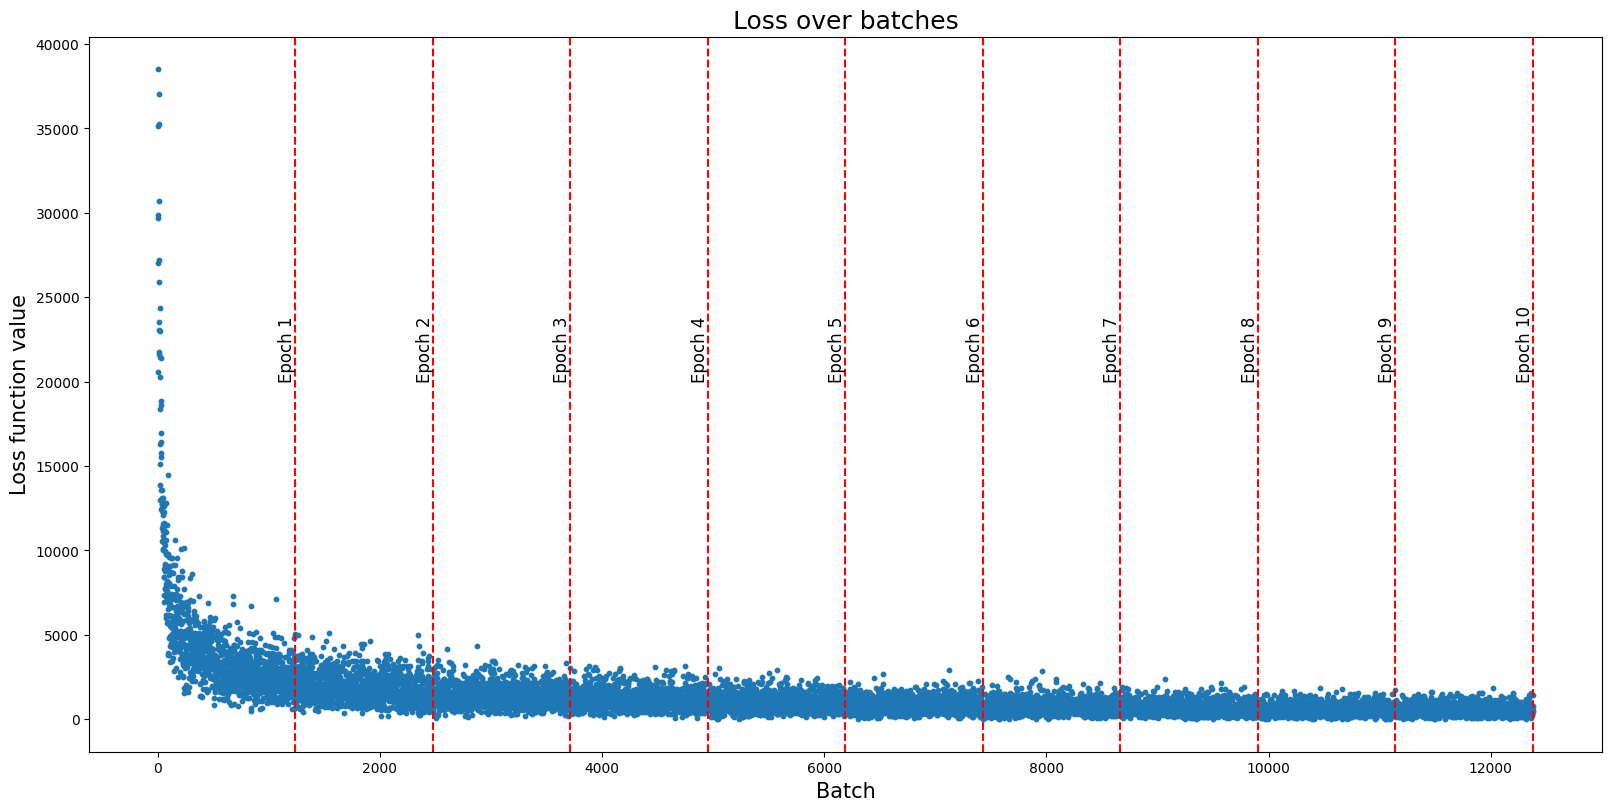

In [33]:
optimizer = torch.optim.Adam(fnn_two_layer.parameters())
train_NN(train_loader, val_loader, fnn_two_layer, loss_function, optimizer, 10, True, True)

We have obtained quite decent results for the simplest neural network.

Now let's move on to `tuning hyperparameters`. First, we will try to find the optimizer that provides the `highest accuracy on validation` for our model. To do this, we will write a simple function. We will run it twice, once with a `learning rate` set to **0.0001** and another time to **0.001**. </br>
We will use `Adam optimizer`, `SGD optimizer` and `RMSProp optimizer`.

In [34]:
def select_optimizer(train_loader, val_loader, loss_function, optimizers, lr):
    for optimizer_class in optimizers:
        print(f"Optimizer class: {optimizer_class}:")
        fnn_two_layer = TwoLayerNN(256)
        optimizer = optimizer_class(fnn_two_layer.parameters(), lr=lr)
        train_NN(train_loader, val_loader, fnn_two_layer, loss_function, optimizer, 5, False, True)
        print("\n")

Optimizer class: <class 'torch.optim.sgd.SGD'>:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:02<00:10,  2.71s/it]

Train loss: 2597.009, Validation loss: 1031.393, Accuraccy: 0.672
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:05<00:08,  2.71s/it]

Train loss: 646.075, Validation loss: 508.803, Accuraccy: 0.676
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:08<00:05,  2.69s/it]

Train loss: 334.427, Validation loss: 305.609, Accuraccy: 0.669
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:11<00:02,  2.82s/it]

Train loss: 217.336, Validation loss: 218.552, Accuraccy: 0.641
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:13<00:00,  2.79s/it]


Train loss: 159.114, Validation loss: 179.876, Accuraccy: 0.653


Optimizer class: <class 'torch.optim.adam.Adam'>:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:05<00:21,  5.29s/it]

Train loss: 11863.556, Validation loss: 6534.943, Accuraccy: 0.446
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:10<00:16,  5.34s/it]

Train loss: 5418.246, Validation loss: 4701.109, Accuraccy: 0.549
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:16<00:10,  5.34s/it]

Train loss: 4134.184, Validation loss: 3895.092, Accuraccy: 0.584
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:21<00:05,  5.29s/it]

Train loss: 3457.212, Validation loss: 3371.376, Accuraccy: 0.613
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:26<00:00,  5.28s/it]


Train loss: 3021.535, Validation loss: 3032.951, Accuraccy: 0.635


Optimizer class: <class 'torch.optim.rmsprop.RMSprop'>:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:04<00:16,  4.13s/it]

Train loss: 12563.329, Validation loss: 6328.469, Accuraccy: 0.466
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:08<00:12,  4.12s/it]

Train loss: 5031.722, Validation loss: 4246.356, Accuraccy: 0.555
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:12<00:08,  4.11s/it]

Train loss: 3721.813, Validation loss: 3449.815, Accuraccy: 0.599
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:16<00:04,  4.10s/it]

Train loss: 3112.490, Validation loss: 3038.218, Accuraccy: 0.619
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:20<00:00,  4.11s/it]

Train loss: 2740.828, Validation loss: 2740.494, Accuraccy: 0.639




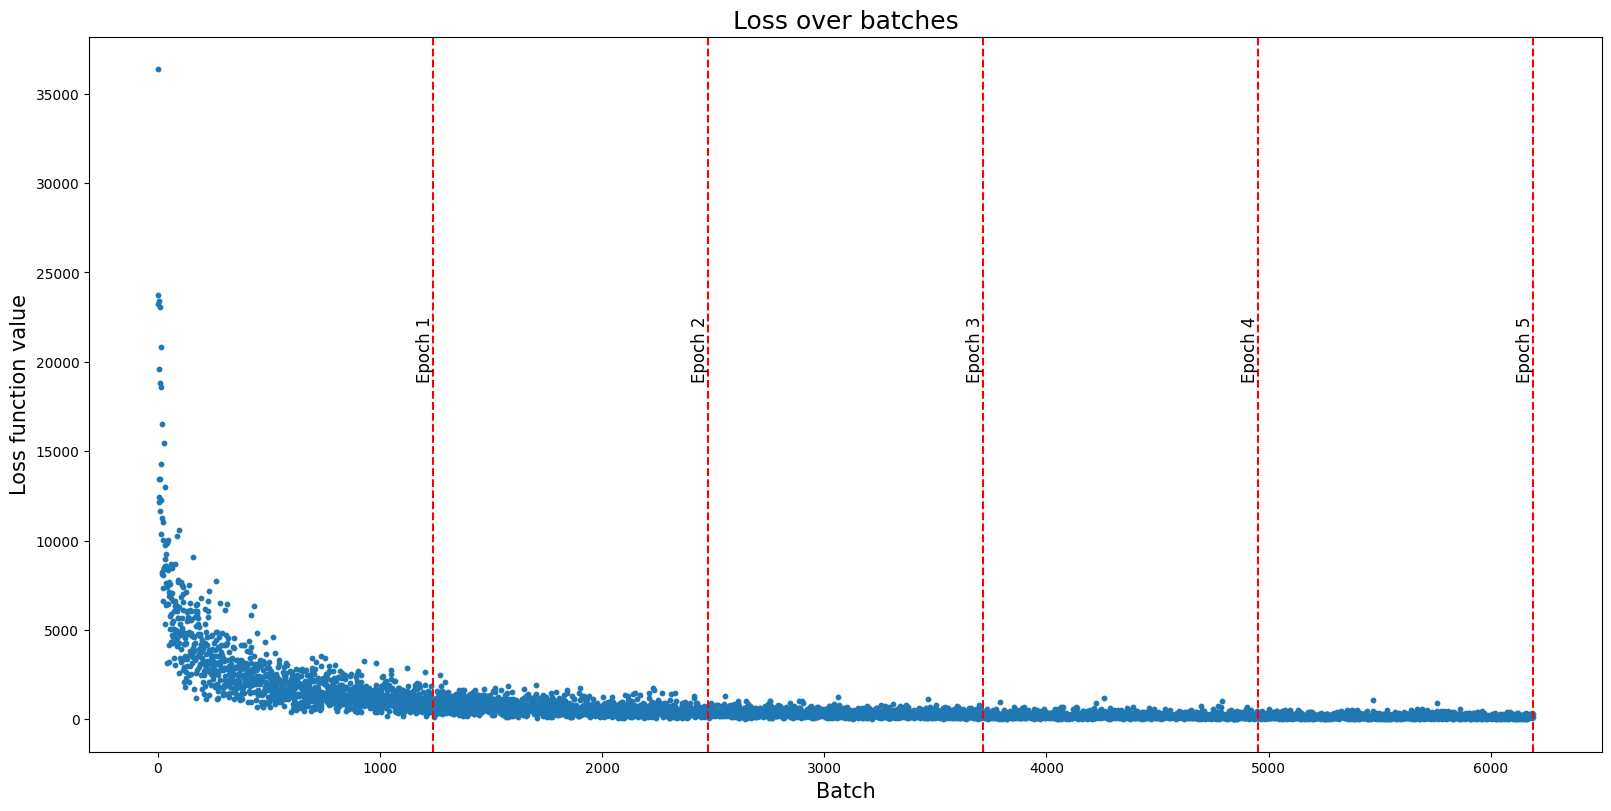

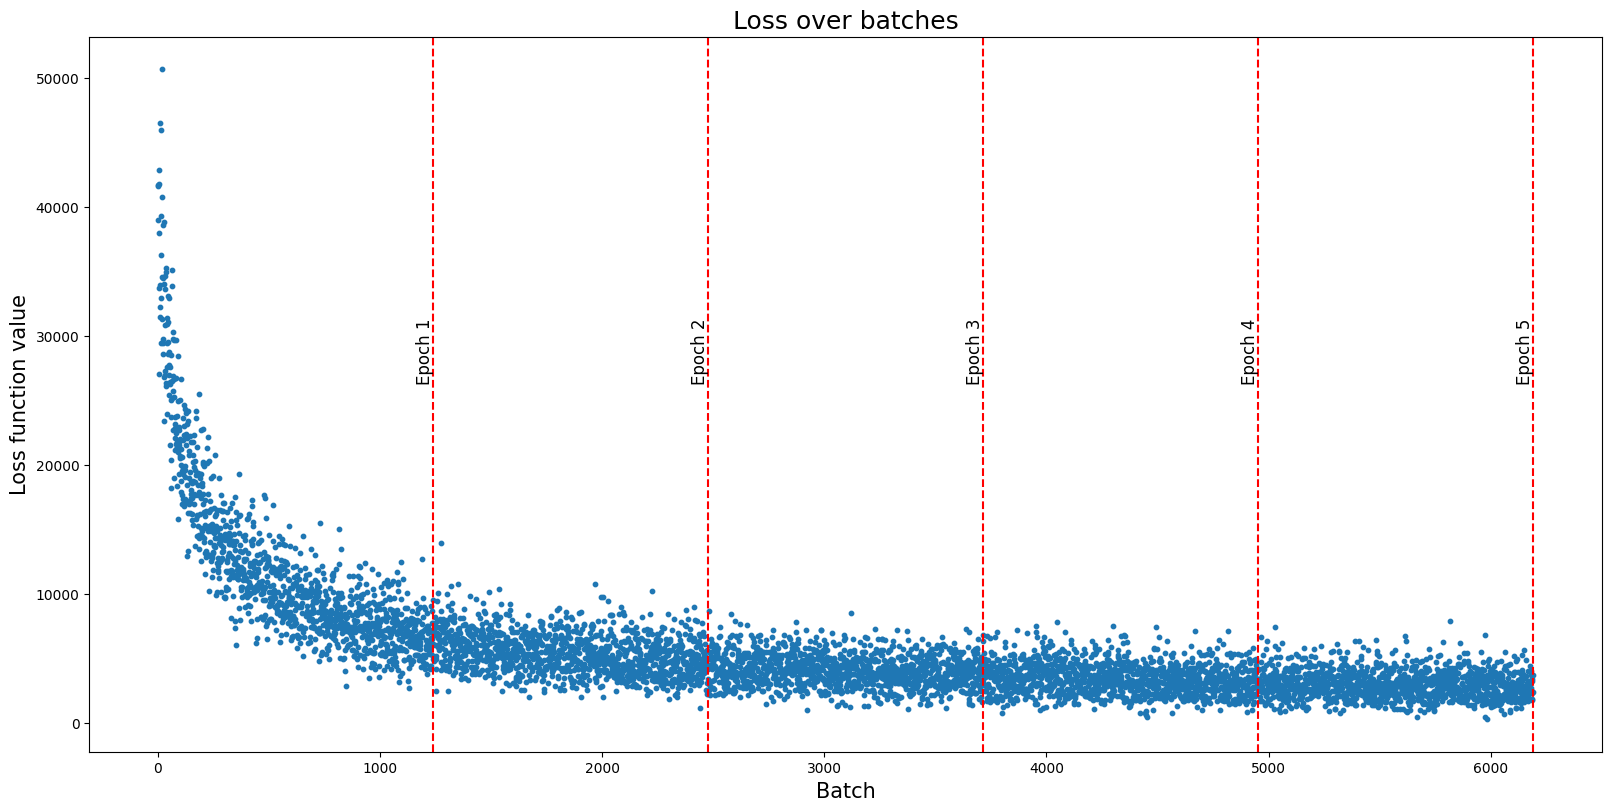

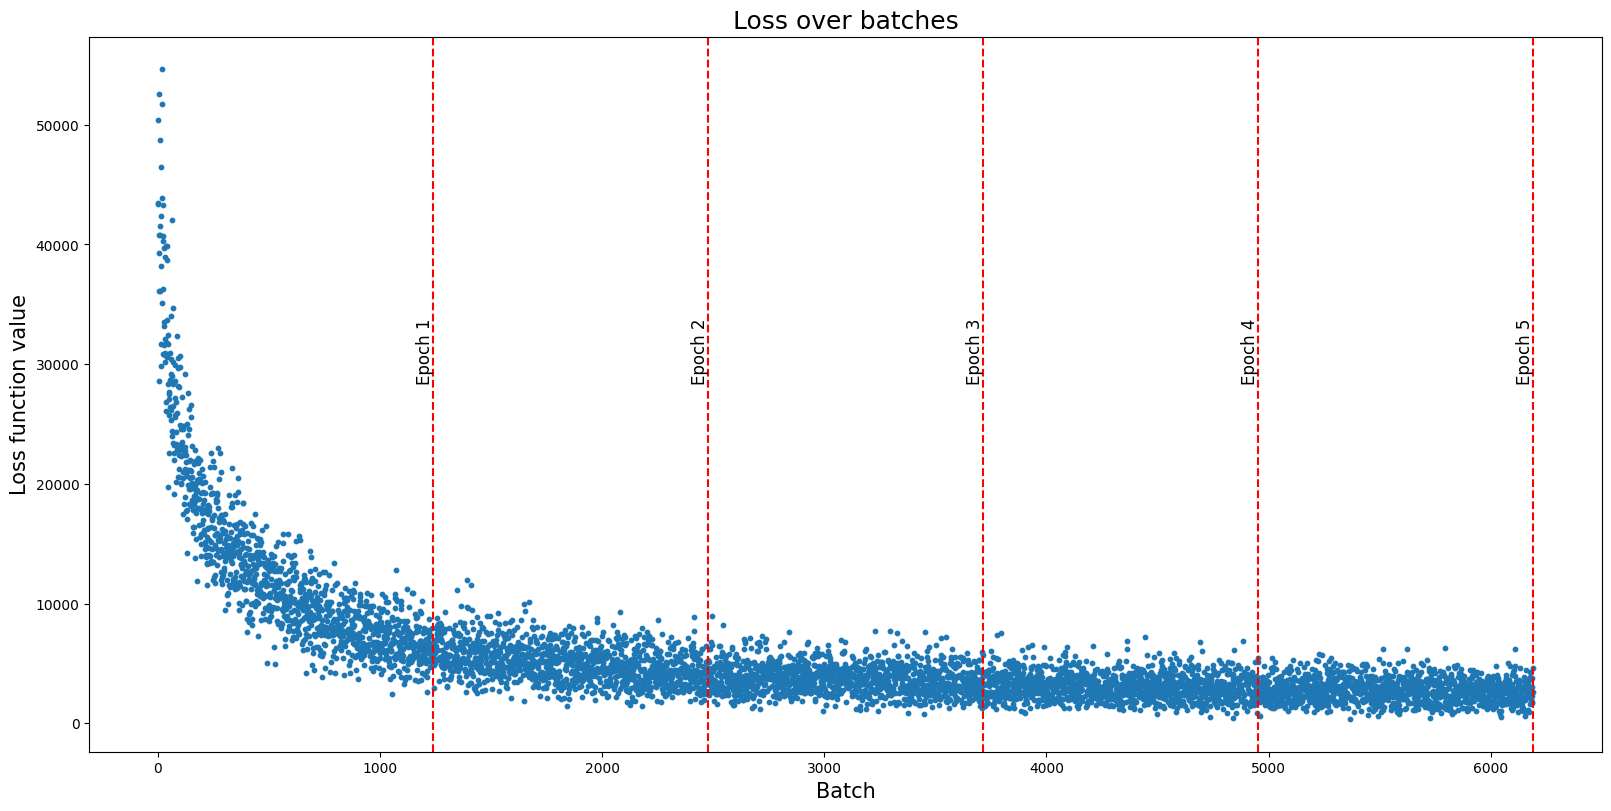

In [35]:
optimizers = [torch.optim.SGD, torch.optim.Adam, torch.optim.RMSprop]
select_optimizer(train_loader, val_loader, loss_function, optimizers, 0.0001)

Optimizer class: <class 'torch.optim.sgd.SGD'>:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:03<00:12,  3.08s/it]

Train loss: 721.332, Validation loss: 32.788, Accuraccy: 0.320
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:06<00:09,  3.04s/it]

Train loss: 18.601, Validation loss: 22.090, Accuraccy: 0.285
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:08<00:05,  2.97s/it]

Train loss: 10.343, Validation loss: 18.729, Accuraccy: 0.273
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:11<00:02,  2.79s/it]

Train loss: 6.885, Validation loss: 17.678, Accuraccy: 0.256
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:14<00:00,  2.88s/it]


Train loss: 5.182, Validation loss: 16.444, Accuraccy: 0.251


Optimizer class: <class 'torch.optim.adam.Adam'>:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:05<00:23,  5.76s/it]

Train loss: 4112.643, Validation loss: 2595.669, Accuraccy: 0.656
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:11<00:16,  5.47s/it]

Train loss: 1923.514, Validation loss: 1734.096, Accuraccy: 0.715
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:16<00:11,  5.53s/it]

Train loss: 1489.288, Validation loss: 1623.100, Accuraccy: 0.718
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:21<00:05,  5.45s/it]

Train loss: 1235.130, Validation loss: 1290.875, Accuraccy: 0.738
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:27<00:00,  5.54s/it]


Train loss: 1046.561, Validation loss: 1219.254, Accuraccy: 0.745


Optimizer class: <class 'torch.optim.rmsprop.RMSprop'>:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:04<00:18,  4.56s/it]

Train loss: 3168.937, Validation loss: 1963.019, Accuraccy: 0.687
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:08<00:13,  4.44s/it]

Train loss: 1584.012, Validation loss: 1487.924, Accuraccy: 0.718
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:12<00:08,  4.26s/it]

Train loss: 1192.245, Validation loss: 1244.859, Accuraccy: 0.729
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:17<00:04,  4.36s/it]

Train loss: 974.839, Validation loss: 1174.467, Accuraccy: 0.722
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:21<00:00,  4.35s/it]

Train loss: 826.353, Validation loss: 978.715, Accuraccy: 0.743




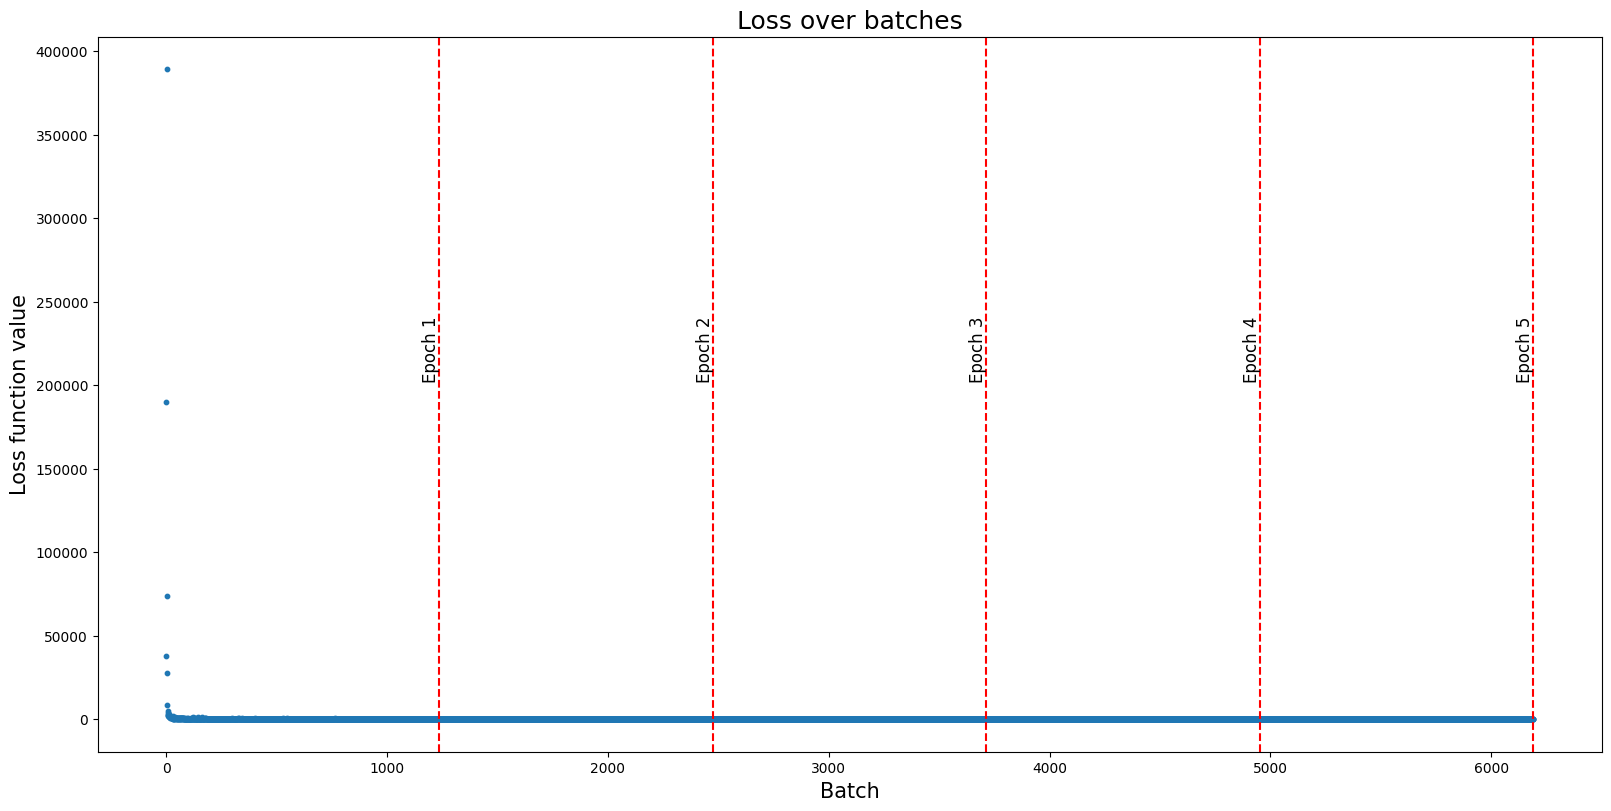

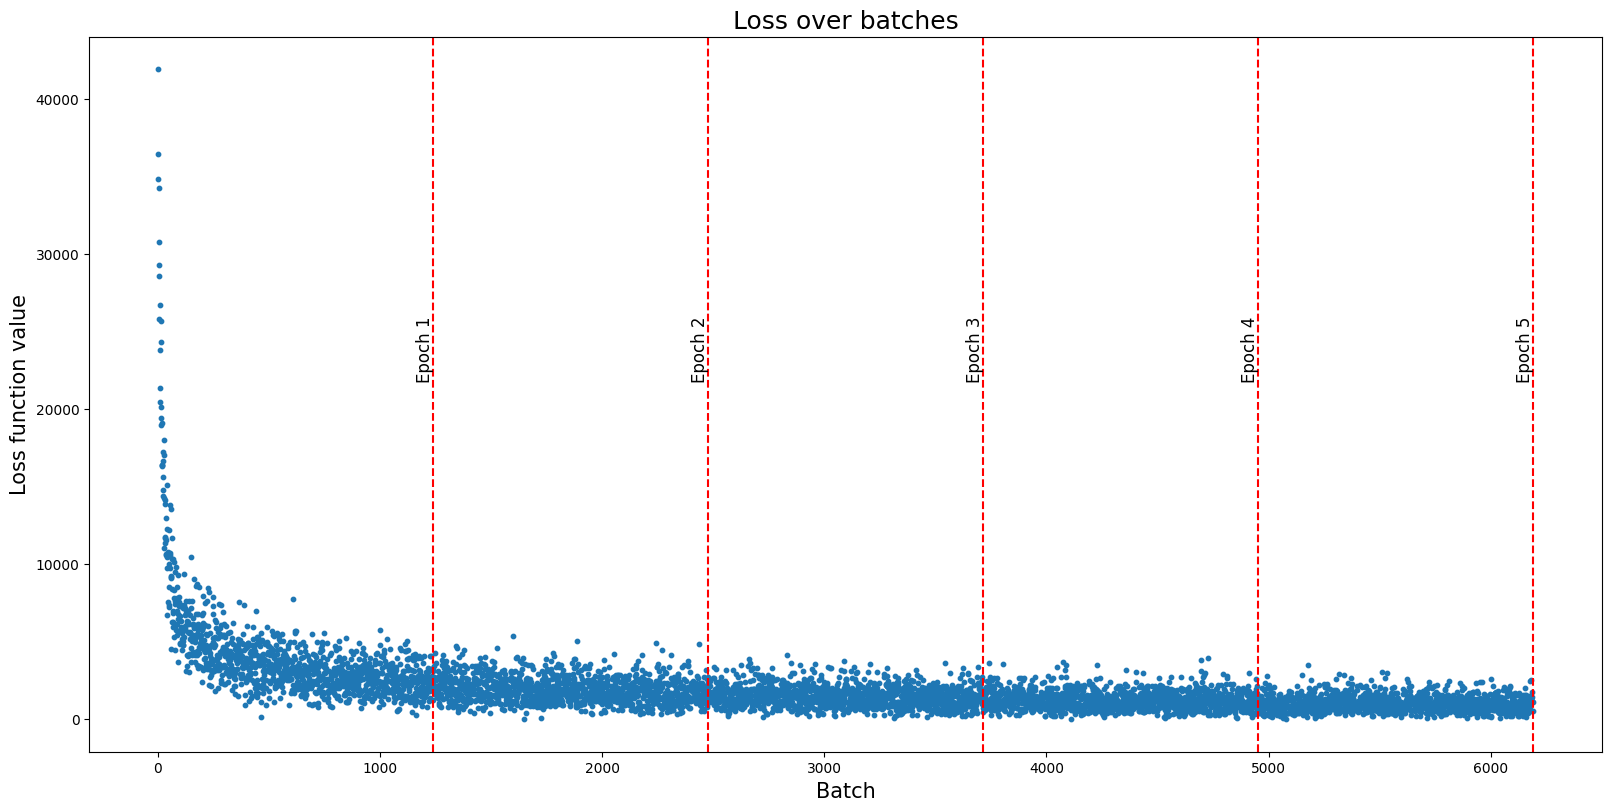

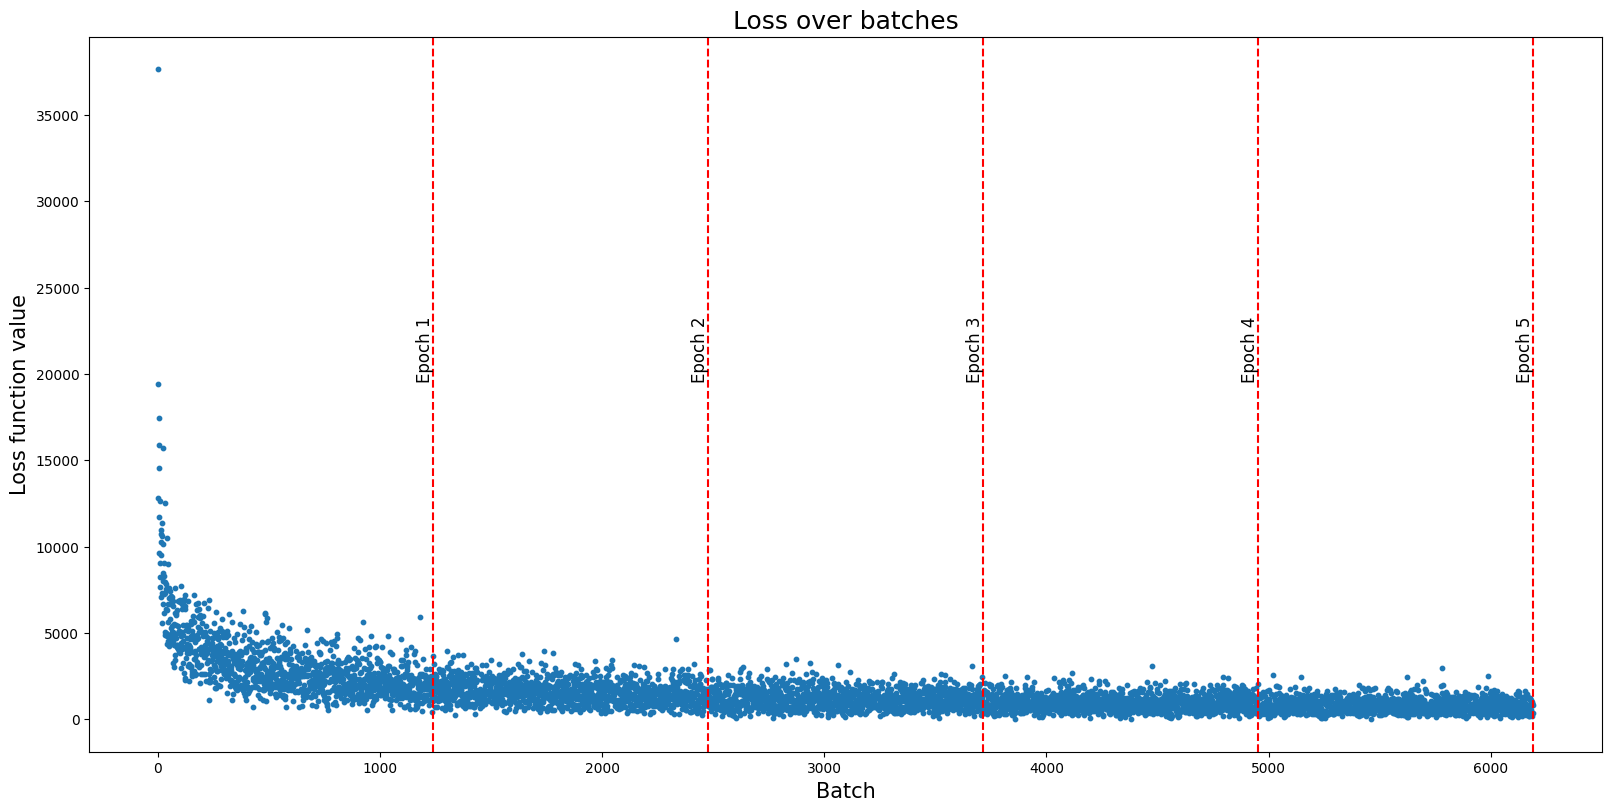

In [36]:
select_optimizer(train_loader, val_loader, loss_function, optimizers, 0.001)

With a learning rate of **0.0001**, all optimizers performed similarly, but the accuracy we obtained was `lower than before`. However, with a learning rate of **0.001**, the `SGD` optimizer yielded lower results (it looks like 
it found a local minimum and got stuck in that range, so it won't be able to find the global minimum anymore), while the other optimizers `improved their accuracy`. `Adam` and `RMSprop` provided similar accuracy, so for now, let's keep both of these optimizers.

Now let's experiment with the `number of neurons` in the hidden layer. We will start with `16 neurons` and double the number each time, observing how it affects the `accuracy` of the model.

In [37]:
numbers_of_neurons = np.logspace(4, 10, num=7, base=2, dtype=int)
for number_of_neurons in numbers_of_neurons:
    print(f"Number of neurons in hidden layer: {number_of_neurons}:")
    fnn_two_layer = TwoLayerNN(number_of_neurons)
    optimizer = torch.optim.Adam(fnn_two_layer.parameters())
    train_NN(train_loader, val_loader, fnn_two_layer, loss_function, optimizer, 5, False, False)
    print("\n")

Number of neurons in hidden layer: 16:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:02<00:10,  2.64s/it]

Train loss: 567.279, Validation loss: 24.848, Accuraccy: 0.119
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:05<00:08,  2.69s/it]

Train loss: 14.106, Validation loss: 7.785, Accuraccy: 0.124
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:07<00:04,  2.46s/it]

Train loss: 5.766, Validation loss: 4.726, Accuraccy: 0.118
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:09<00:02,  2.36s/it]

Train loss: 3.627, Validation loss: 3.610, Accuraccy: 0.116
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:12<00:00,  2.50s/it]


Train loss: 2.839, Validation loss: 3.157, Accuraccy: 0.113


Number of neurons in hidden layer: 32:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:02<00:11,  2.87s/it]

Train loss: 1425.031, Validation loss: 123.810, Accuraccy: 0.263
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:05<00:08,  2.68s/it]

Train loss: 51.755, Validation loss: 23.608, Accuraccy: 0.190
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:07<00:04,  2.48s/it]

Train loss: 13.710, Validation loss: 10.999, Accuraccy: 0.167
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:09<00:02,  2.42s/it]

Train loss: 6.389, Validation loss: 7.046, Accuraccy: 0.151
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:13<00:00,  2.66s/it]


Train loss: 4.120, Validation loss: 5.233, Accuraccy: 0.145


Number of neurons in hidden layer: 64:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:03<00:14,  3.60s/it]

Train loss: 2862.678, Validation loss: 1416.502, Accuraccy: 0.602
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:06<00:10,  3.40s/it]

Train loss: 1075.174, Validation loss: 979.558, Accuraccy: 0.649
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:10<00:07,  3.53s/it]

Train loss: 763.628, Validation loss: 738.552, Accuraccy: 0.672
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:14<00:03,  3.54s/it]

Train loss: 581.063, Validation loss: 563.297, Accuraccy: 0.690
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:16<00:00,  3.34s/it]


Train loss: 448.478, Validation loss: 453.541, Accuraccy: 0.699


Number of neurons in hidden layer: 128:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:03<00:13,  3.43s/it]

Train loss: 3136.061, Validation loss: 1597.579, Accuraccy: 0.664
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:06<00:09,  3.12s/it]

Train loss: 1295.501, Validation loss: 1142.621, Accuraccy: 0.690
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:09<00:06,  3.13s/it]

Train loss: 956.283, Validation loss: 913.423, Accuraccy: 0.703
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:12<00:03,  3.13s/it]

Train loss: 755.926, Validation loss: 783.249, Accuraccy: 0.724
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:15<00:00,  3.11s/it]


Train loss: 629.647, Validation loss: 690.386, Accuraccy: 0.714


Number of neurons in hidden layer: 256:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:05<00:21,  5.37s/it]

Train loss: 4294.403, Validation loss: 2345.207, Accuraccy: 0.672
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:10<00:16,  5.37s/it]

Train loss: 1844.246, Validation loss: 1673.016, Accuraccy: 0.722
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:16<00:10,  5.42s/it]

Train loss: 1418.585, Validation loss: 1524.320, Accuraccy: 0.715
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:21<00:05,  5.33s/it]

Train loss: 1158.865, Validation loss: 1306.898, Accuraccy: 0.739
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:26<00:00,  5.27s/it]


Train loss: 994.180, Validation loss: 1397.526, Accuraccy: 0.718


Number of neurons in hidden layer: 512:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:08<00:32,  8.09s/it]

Train loss: 5564.261, Validation loss: 3193.015, Accuraccy: 0.688
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:16<00:24,  8.32s/it]

Train loss: 2591.410, Validation loss: 2502.171, Accuraccy: 0.732
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:24<00:16,  8.32s/it]

Train loss: 2003.541, Validation loss: 2165.499, Accuraccy: 0.724
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:32<00:08,  8.12s/it]

Train loss: 1664.053, Validation loss: 2068.772, Accuraccy: 0.724
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:41<00:00,  8.23s/it]


Train loss: 1419.345, Validation loss: 1641.543, Accuraccy: 0.770


Number of neurons in hidden layer: 1024:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:15<01:02, 15.60s/it]

Train loss: 6722.684, Validation loss: 4193.643, Accuraccy: 0.713
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:31<00:47, 15.73s/it]

Train loss: 3417.479, Validation loss: 4004.353, Accuraccy: 0.697
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:47<00:31, 15.79s/it]

Train loss: 2689.252, Validation loss: 3208.615, Accuraccy: 0.747
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [01:03<00:15, 15.85s/it]

Train loss: 2315.422, Validation loss: 2868.631, Accuraccy: 0.771
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [01:19<00:00, 15.84s/it]

Train loss: 2017.686, Validation loss: 2666.811, Accuraccy: 0.772




As we can see, the larger the number of neurons, the faster the model starts to achieve higher accuracy (although the difference in results between 128, 256, 512, and 1024 neurons is not very significant). However, it's worth noting that the `training time of the neural network also increases`. Therefore, we will need to find an `optimal solution` that strikes a balance between these factors and best satisfies our requirements.

Now let's experiment with the optimizer hyperparameter, specifically the `learning rate`, and observe how the model's accuracy changes as we decrease this hyperparameter. We will conduct this experiment with `two optimizers` - **Adam** and **RMSProp**.

In [38]:
lrs = np.geomspace(0.05, 0.0005, num=6)
for lr in lrs:
    print(f"Learning rate: {lr:.4f}:")
    fnn_two_layer = TwoLayerNN(256)
    optimizer = torch.optim.Adam(fnn_two_layer.parameters(), lr=lr)
    train_NN(train_loader, val_loader, fnn_two_layer, loss_function, optimizer, 5, False, False)
    print("\n")

Learning rate: 0.0500:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:05<00:21,  5.46s/it]

Train loss: 798.389, Validation loss: 5.429, Accuraccy: 0.154
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:10<00:15,  5.24s/it]

Train loss: 3.337, Validation loss: 3.328, Accuraccy: 0.130
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:16<00:11,  5.57s/it]

Train loss: 2.923, Validation loss: 2.763, Accuraccy: 0.115
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:22<00:05,  5.63s/it]

Train loss: 2.448, Validation loss: 2.733, Accuraccy: 0.108
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:27<00:00,  5.52s/it]


Train loss: 2.406, Validation loss: 2.828, Accuraccy: 0.114


Learning rate: 0.0199:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:05<00:20,  5.12s/it]

Train loss: 1031.196, Validation loss: 19.152, Accuraccy: 0.328
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:09<00:14,  4.93s/it]

Train loss: 8.274, Validation loss: 6.333, Accuraccy: 0.202
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:15<00:10,  5.17s/it]

Train loss: 3.849, Validation loss: 5.065, Accuraccy: 0.211
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:20<00:05,  5.35s/it]

Train loss: 3.136, Validation loss: 6.635, Accuraccy: 0.210
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:26<00:00,  5.25s/it]


Train loss: 2.609, Validation loss: 3.903, Accuraccy: 0.139


Learning rate: 0.0079:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:05<00:21,  5.32s/it]

Train loss: 2183.778, Validation loss: 587.008, Accuraccy: 0.712
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:11<00:16,  5.58s/it]

Train loss: 226.392, Validation loss: 43.011, Accuraccy: 0.485
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:16<00:11,  5.51s/it]

Train loss: 19.897, Validation loss: 14.375, Accuraccy: 0.383
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:21<00:05,  5.22s/it]

Train loss: 7.520, Validation loss: 8.630, Accuraccy: 0.330
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:26<00:00,  5.30s/it]


Train loss: 4.732, Validation loss: 6.697, Accuraccy: 0.270


Learning rate: 0.0032:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:05<00:23,  5.78s/it]

Train loss: 3216.867, Validation loss: 2171.989, Accuraccy: 0.707
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:13<00:20,  6.81s/it]

Train loss: 1419.786, Validation loss: 1368.653, Accuraccy: 0.720
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:20<00:13,  6.90s/it]

Train loss: 991.562, Validation loss: 1125.693, Accuraccy: 0.742
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:25<00:06,  6.26s/it]

Train loss: 768.946, Validation loss: 759.113, Accuraccy: 0.760
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.14s/it]


Train loss: 577.319, Validation loss: 749.354, Accuraccy: 0.752


Learning rate: 0.0013:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:05<00:22,  5.70s/it]

Train loss: 3903.102, Validation loss: 2154.703, Accuraccy: 0.665
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:11<00:17,  5.72s/it]

Train loss: 1625.390, Validation loss: 1537.213, Accuraccy: 0.718
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:17<00:11,  5.86s/it]

Train loss: 1194.799, Validation loss: 1272.986, Accuraccy: 0.725
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:22<00:05,  5.56s/it]

Train loss: 974.571, Validation loss: 1098.789, Accuraccy: 0.743
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.72s/it]


Train loss: 809.918, Validation loss: 922.858, Accuraccy: 0.754


Learning rate: 0.0005:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:05<00:21,  5.34s/it]

Train loss: 5850.973, Validation loss: 3022.221, Accuraccy: 0.639
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:10<00:16,  5.44s/it]

Train loss: 2422.409, Validation loss: 2405.307, Accuraccy: 0.661
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:16<00:10,  5.41s/it]

Train loss: 1888.399, Validation loss: 1820.780, Accuraccy: 0.696
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:21<00:05,  5.31s/it]

Train loss: 1580.793, Validation loss: 1621.876, Accuraccy: 0.710
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:26<00:00,  5.35s/it]

Train loss: 1373.843, Validation loss: 1453.877, Accuraccy: 0.725




In [39]:
for lr in lrs:
    print(f"Learning rate: {lr:.4f}:")
    fnn_two_layer = TwoLayerNN(256)
    optimizer = torch.optim.RMSprop(fnn_two_layer.parameters(), lr=lr)
    train_NN(train_loader, val_loader, fnn_two_layer, loss_function, optimizer, 5, False, False)
    print("\n")

Learning rate: 0.0500:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:04<00:17,  4.43s/it]

Train loss: 3676.041, Validation loss: 3.335, Accuraccy: 0.117
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:08<00:12,  4.25s/it]

Train loss: 8.228, Validation loss: 2.659, Accuraccy: 0.110
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:12<00:08,  4.00s/it]

Train loss: 3.810, Validation loss: 2.585, Accuraccy: 0.106
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:16<00:04,  4.16s/it]

Train loss: 2.685, Validation loss: 2.715, Accuraccy: 0.103
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:21<00:00,  4.26s/it]


Train loss: 2.371, Validation loss: 2.722, Accuraccy: 0.108


Learning rate: 0.0199:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:04<00:16,  4.02s/it]

Train loss: 2119.094, Validation loss: 5.435, Accuraccy: 0.153
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:07<00:11,  3.88s/it]

Train loss: 3.867, Validation loss: 2.775, Accuraccy: 0.129
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:11<00:07,  3.89s/it]

Train loss: 2.605, Validation loss: 2.871, Accuraccy: 0.133
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:15<00:03,  3.97s/it]

Train loss: 2.490, Validation loss: 2.679, Accuraccy: 0.130
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.97s/it]


Train loss: 2.429, Validation loss: 2.608, Accuraccy: 0.121


Learning rate: 0.0079:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:04<00:16,  4.21s/it]

Train loss: 2140.108, Validation loss: 61.207, Accuraccy: 0.478
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:08<00:12,  4.18s/it]

Train loss: 14.382, Validation loss: 9.279, Accuraccy: 0.172
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:12<00:08,  4.08s/it]

Train loss: 3.486, Validation loss: 3.851, Accuraccy: 0.177
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:16<00:04,  4.12s/it]

Train loss: 2.733, Validation loss: 3.704, Accuraccy: 0.161
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:20<00:00,  4.07s/it]


Train loss: 2.423, Validation loss: 3.553, Accuraccy: 0.195


Learning rate: 0.0032:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:04<00:16,  4.09s/it]

Train loss: 2848.986, Validation loss: 1419.249, Accuraccy: 0.719
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:08<00:13,  4.34s/it]

Train loss: 1148.158, Validation loss: 1018.735, Accuraccy: 0.733
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:12<00:08,  4.24s/it]

Train loss: 700.818, Validation loss: 624.756, Accuraccy: 0.752
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:16<00:04,  4.14s/it]

Train loss: 425.686, Validation loss: 375.048, Accuraccy: 0.714
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:20<00:00,  4.10s/it]


Train loss: 190.622, Validation loss: 92.403, Accuraccy: 0.606


Learning rate: 0.0013:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:04<00:16,  4.08s/it]

Train loss: 3249.926, Validation loss: 2054.685, Accuraccy: 0.690
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:08<00:12,  4.14s/it]

Train loss: 1638.508, Validation loss: 1485.779, Accuraccy: 0.731
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:12<00:07,  3.97s/it]

Train loss: 1260.770, Validation loss: 1270.386, Accuraccy: 0.744
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:15<00:03,  3.86s/it]

Train loss: 1031.678, Validation loss: 1134.620, Accuraccy: 0.753
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:20<00:00,  4.15s/it]


Train loss: 876.768, Validation loss: 1096.728, Accuraccy: 0.755


Learning rate: 0.0005:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:04<00:16,  4.20s/it]

Train loss: 3833.252, Validation loss: 2482.091, Accuraccy: 0.658
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:08<00:12,  4.17s/it]

Train loss: 2086.246, Validation loss: 1898.569, Accuraccy: 0.699
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:13<00:08,  4.48s/it]

Train loss: 1625.888, Validation loss: 1582.641, Accuraccy: 0.721
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [00:17<00:04,  4.29s/it]

Train loss: 1359.780, Validation loss: 1498.096, Accuraccy: 0.720
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [00:21<00:00,  4.23s/it]

Train loss: 1176.905, Validation loss: 1411.605, Accuraccy: 0.721




The highest results for these models are achieved around **0.001** for the learning rate.

Now let's check how `data standardization` affects the accuracy of the models.

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:


 10%|████▍                                       | 1/10 [00:05<00:49,  5.53s/it]

Train loss: 76.070, Validation loss: 46.851, Accuraccy: 0.685
Epoch number 2:


 20%|████████▊                                   | 2/10 [00:10<00:40,  5.07s/it]

Train loss: 35.349, Validation loss: 38.200, Accuraccy: 0.704
Epoch number 3:


 30%|█████████████▏                              | 3/10 [00:15<00:35,  5.02s/it]

Train loss: 26.007, Validation loss: 33.236, Accuraccy: 0.712
Epoch number 4:


 40%|█████████████████▌                          | 4/10 [00:20<00:29,  4.92s/it]

Train loss: 20.568, Validation loss: 28.914, Accuraccy: 0.737
Epoch number 5:


 50%|██████████████████████                      | 5/10 [00:24<00:24,  4.86s/it]

Train loss: 16.975, Validation loss: 26.299, Accuraccy: 0.740
Epoch number 6:


 60%|██████████████████████████▍                 | 6/10 [00:30<00:21,  5.27s/it]

Train loss: 14.498, Validation loss: 25.645, Accuraccy: 0.750
Epoch number 7:


 70%|██████████████████████████████▊             | 7/10 [00:37<00:17,  5.81s/it]

Train loss: 12.502, Validation loss: 26.214, Accuraccy: 0.736
Epoch number 8:


 80%|███████████████████████████████████▏        | 8/10 [00:43<00:11,  5.92s/it]

Train loss: 10.947, Validation loss: 23.251, Accuraccy: 0.752
Epoch number 9:


 90%|███████████████████████████████████████▌    | 9/10 [00:49<00:05,  5.93s/it]

Train loss: 9.687, Validation loss: 22.667, Accuraccy: 0.753
Epoch number 10:


100%|███████████████████████████████████████████| 10/10 [00:55<00:00,  5.52s/it]

Train loss: 8.786, Validation loss: 22.143, Accuraccy: 0.754


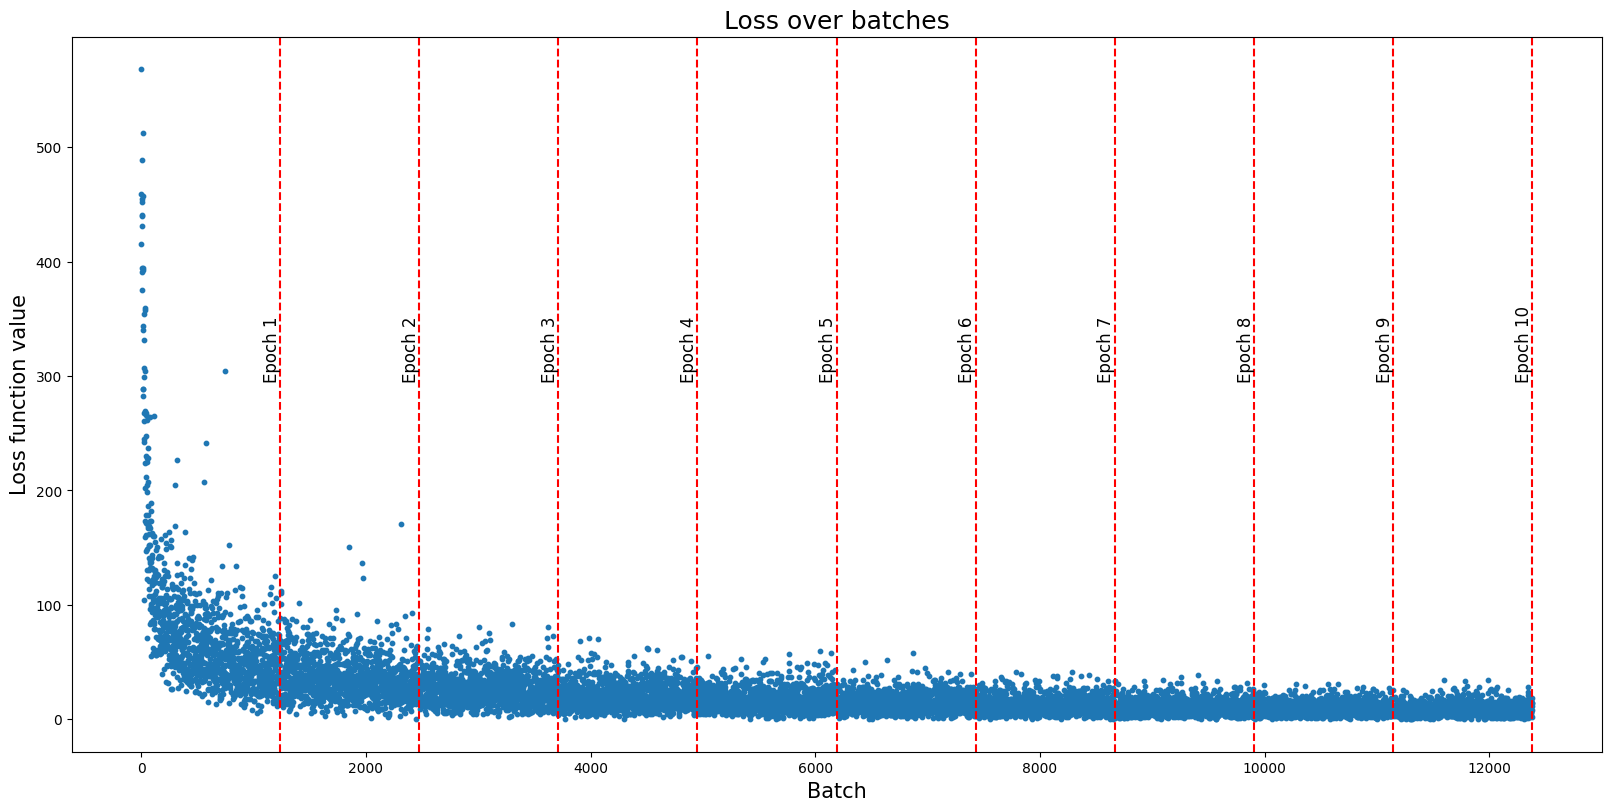

In [40]:
fnn_two_layer = TwoLayerNN(256)
optimizer = torch.optim.Adam(fnn_two_layer.parameters())
train_NN(train_scaled_loader, val_scaled_loader, fnn_two_layer, loss_function, optimizer, 10, False, True)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:


 10%|████▍                                       | 1/10 [00:03<00:34,  3.78s/it]

Train loss: 76.437, Validation loss: 38.861, Accuraccy: 0.743
Epoch number 2:


 20%|████████▊                                   | 2/10 [00:07<00:31,  3.88s/it]

Train loss: 27.921, Validation loss: 33.085, Accuraccy: 0.693
Epoch number 3:


 30%|█████████████▏                              | 3/10 [00:11<00:26,  3.85s/it]

Train loss: 16.205, Validation loss: 18.516, Accuraccy: 0.710
Epoch number 4:


 40%|█████████████████▌                          | 4/10 [00:15<00:23,  3.89s/it]

Train loss: 12.158, Validation loss: 11.345, Accuraccy: 0.769
Epoch number 5:


 50%|██████████████████████                      | 5/10 [00:19<00:19,  3.88s/it]

Train loss: 9.552, Validation loss: 11.565, Accuraccy: 0.770
Epoch number 6:


 60%|██████████████████████████▍                 | 6/10 [00:23<00:15,  3.91s/it]

Train loss: 8.522, Validation loss: 10.016, Accuraccy: 0.779
Epoch number 7:


 70%|██████████████████████████████▊             | 7/10 [00:27<00:11,  3.88s/it]

Train loss: 7.373, Validation loss: 10.057, Accuraccy: 0.747
Epoch number 8:


 80%|███████████████████████████████████▏        | 8/10 [00:30<00:07,  3.87s/it]

Train loss: 6.540, Validation loss: 9.107, Accuraccy: 0.763
Epoch number 9:


 90%|███████████████████████████████████████▌    | 9/10 [00:35<00:03,  3.98s/it]

Train loss: 6.249, Validation loss: 9.137, Accuraccy: 0.771
Epoch number 10:


100%|███████████████████████████████████████████| 10/10 [00:38<00:00,  3.89s/it]

Train loss: 5.671, Validation loss: 9.779, Accuraccy: 0.753


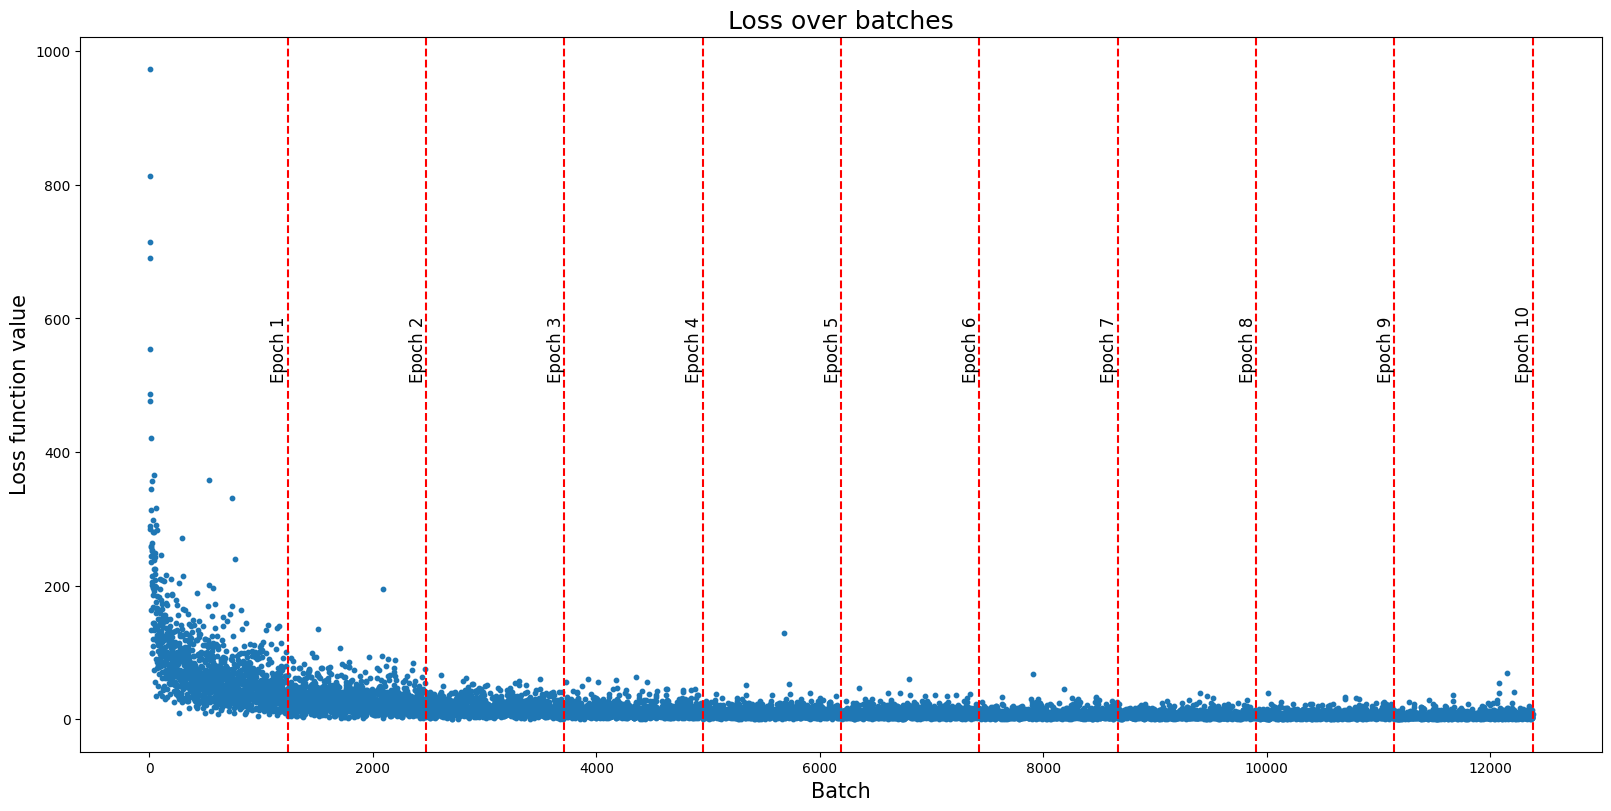

In [41]:
fnn_two_layer = TwoLayerNN(256)
optimizer = torch.optim.RMSprop(fnn_two_layer.parameters())
train_NN(train_scaled_loader, val_scaled_loader, fnn_two_layer, loss_function, optimizer, 10, False, True)

It appears that standardizing the data did not increase the accuracy of the model (even decreased slightly).

Let's move on to creating a `three-layer neural network`. The logic here is the same as in the `two-layer network`, but an additional hidden layer is added.

In [42]:
class ThreeLayerNN(nn.Module):
    def __init__(self, hidden_layer1, hidden_layer2):
        super().__init__()
        self.fc1 = nn.Linear(32*32, hidden_layer1)
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.fco = nn.Linear(hidden_layer2, 10)
        
        nn.init.normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.normal_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.normal_(self.fco.weight)
        nn.init.zeros_(self.fco.bias)

    def forward(self, x):
        x = x.flatten(start_dim=1).to(self.fc1.weight.dtype)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fco(x)
        return x
    
    def predict_proba(self, x):
        with torch.no_grad():
            pred = self.forward(x)
            probabilities = F.softmax(pred, dim=1)
        return probabilities

    def predict(self, x):
        probabilities = self.predict_proba(x)
        with torch.no_grad():
            max_probabilities, predicted_classes = torch.max(probabilities, dim=1)
        return predicted_classes

In [43]:
fnn_three_layer = ThreeLayerNN(128,32)
print(fnn_three_layer)
num_params = 0
for name, parameter in fnn_three_layer.named_parameters():
    print(f"{name}\nNumber: {parameter.numel()}\n")
    num_params += parameter.numel()
    
print(f"Total number of parameters: {num_params}")

ThreeLayerNN(
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fco): Linear(in_features=32, out_features=10, bias=True)
)
fc1.weight
Number: 131072

fc1.bias
Number: 128

fc2.weight
Number: 4096

fc2.bias
Number: 32

fco.weight
Number: 320

fco.bias
Number: 10

Total number of parameters: 135658


  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:


 10%|████▍                                       | 1/10 [00:03<00:29,  3.30s/it]

Train loss: 6905.588, Validation loss: 158.396, Accuraccy: 0.182
Epoch number 2:


 20%|████████▊                                   | 2/10 [00:06<00:27,  3.49s/it]

Train loss: 62.823, Validation loss: 29.504, Accuraccy: 0.127
Epoch number 3:


 30%|█████████████▏                              | 3/10 [00:10<00:24,  3.47s/it]

Train loss: 15.669, Validation loss: 13.979, Accuraccy: 0.125
Epoch number 4:


 40%|█████████████████▌                          | 4/10 [00:13<00:20,  3.41s/it]

Train loss: 6.382, Validation loss: 9.730, Accuraccy: 0.123
Epoch number 5:


 50%|██████████████████████                      | 5/10 [00:17<00:17,  3.41s/it]

Train loss: 3.640, Validation loss: 7.938, Accuraccy: 0.121
Epoch number 6:


 60%|██████████████████████████▍                 | 6/10 [00:20<00:13,  3.44s/it]

Train loss: 2.941, Validation loss: 7.523, Accuraccy: 0.116
Epoch number 7:


 70%|██████████████████████████████▊             | 7/10 [00:24<00:10,  3.56s/it]

Train loss: 2.540, Validation loss: 5.868, Accuraccy: 0.113
Epoch number 8:


 80%|███████████████████████████████████▏        | 8/10 [00:27<00:07,  3.51s/it]

Train loss: 2.354, Validation loss: 5.720, Accuraccy: 0.112
Epoch number 9:


 90%|███████████████████████████████████████▌    | 9/10 [00:31<00:03,  3.47s/it]

Train loss: 2.327, Validation loss: 6.085, Accuraccy: 0.110
Epoch number 10:


100%|███████████████████████████████████████████| 10/10 [00:34<00:00,  3.47s/it]

Train loss: 2.288, Validation loss: 6.158, Accuraccy: 0.110


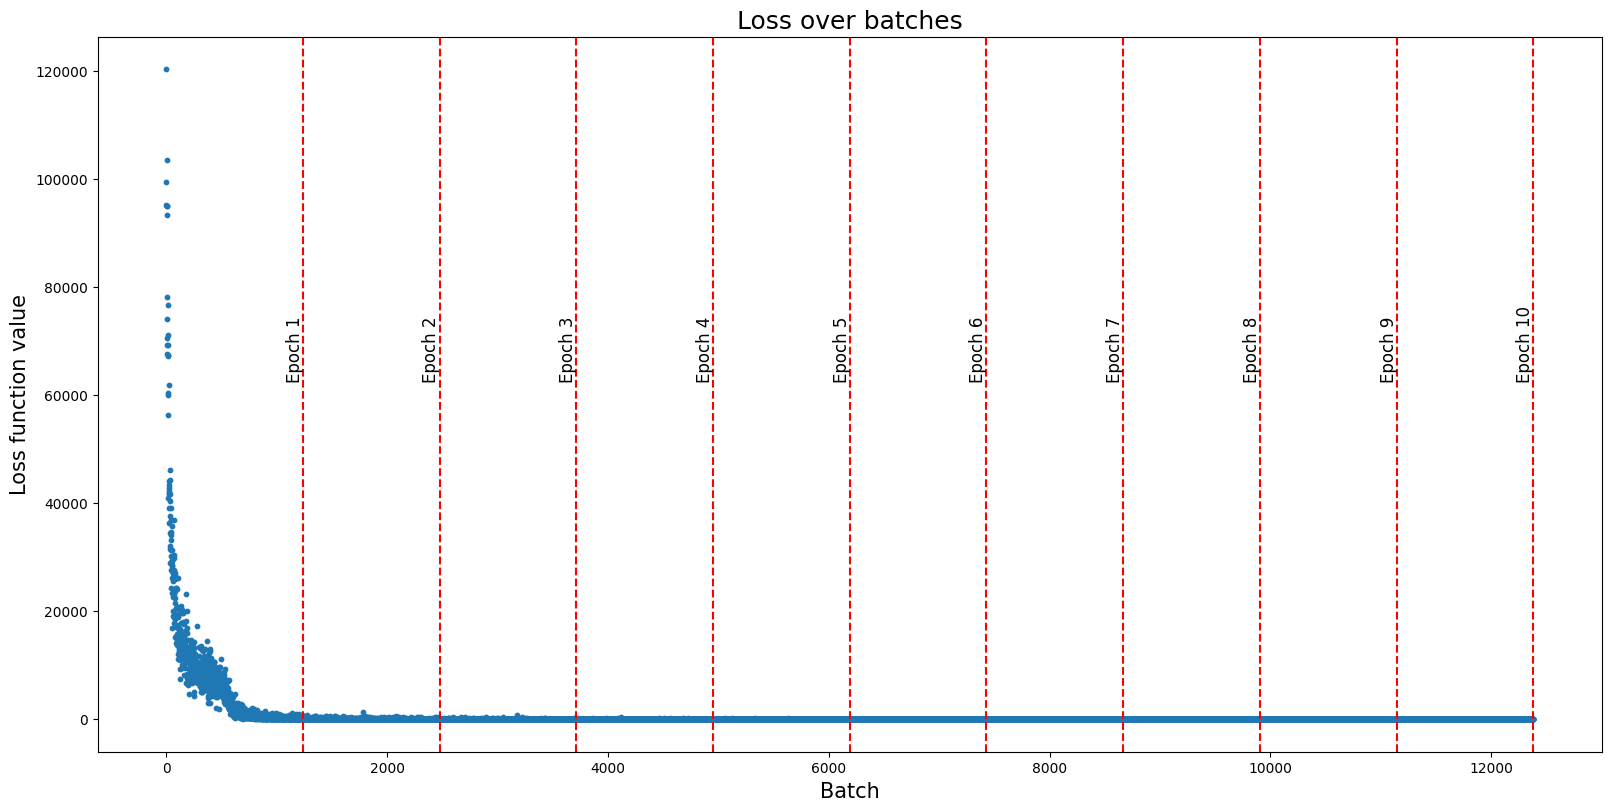

In [44]:
optimizer = torch.optim.Adam(fnn_three_layer.parameters())
train_NN(train_loader, val_loader, fnn_three_layer, loss_function, optimizer, 10, False, True)

The accuracy turned out to be too low (the network got stuck near a `local minimum`). Let's try `changing the number of neurons` in the hidden layers to improve the accuracy.

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:


 10%|████▍                                       | 1/10 [00:04<00:37,  4.18s/it]

Train loss: 23099.499, Validation loss: 10455.839, Accuraccy: 0.655
Epoch number 2:


 20%|████████▊                                   | 2/10 [00:08<00:32,  4.04s/it]

Train loss: 7962.264, Validation loss: 6326.473, Accuraccy: 0.706
Epoch number 3:


 30%|█████████████▏                              | 3/10 [00:11<00:25,  3.71s/it]

Train loss: 5170.312, Validation loss: 4747.031, Accuraccy: 0.701
Epoch number 4:


 40%|█████████████████▌                          | 4/10 [00:15<00:22,  3.69s/it]

Train loss: 3662.514, Validation loss: 3474.411, Accuraccy: 0.724
Epoch number 5:


 50%|██████████████████████                      | 5/10 [00:18<00:18,  3.61s/it]

Train loss: 2728.033, Validation loss: 2939.408, Accuraccy: 0.718
Epoch number 6:


 60%|██████████████████████████▍                 | 6/10 [00:22<00:14,  3.66s/it]

Train loss: 2126.472, Validation loss: 2550.613, Accuraccy: 0.736
Epoch number 7:


 70%|██████████████████████████████▊             | 7/10 [00:26<00:11,  3.68s/it]

Train loss: 1659.992, Validation loss: 2084.472, Accuraccy: 0.719
Epoch number 8:


 80%|███████████████████████████████████▏        | 8/10 [00:29<00:07,  3.76s/it]

Train loss: 1312.484, Validation loss: 1795.856, Accuraccy: 0.720
Epoch number 9:


 90%|███████████████████████████████████████▌    | 9/10 [00:33<00:03,  3.74s/it]

Train loss: 1068.947, Validation loss: 1479.676, Accuraccy: 0.707
Epoch number 10:


100%|███████████████████████████████████████████| 10/10 [00:37<00:00,  3.73s/it]

Train loss: 888.516, Validation loss: 1419.329, Accuraccy: 0.708


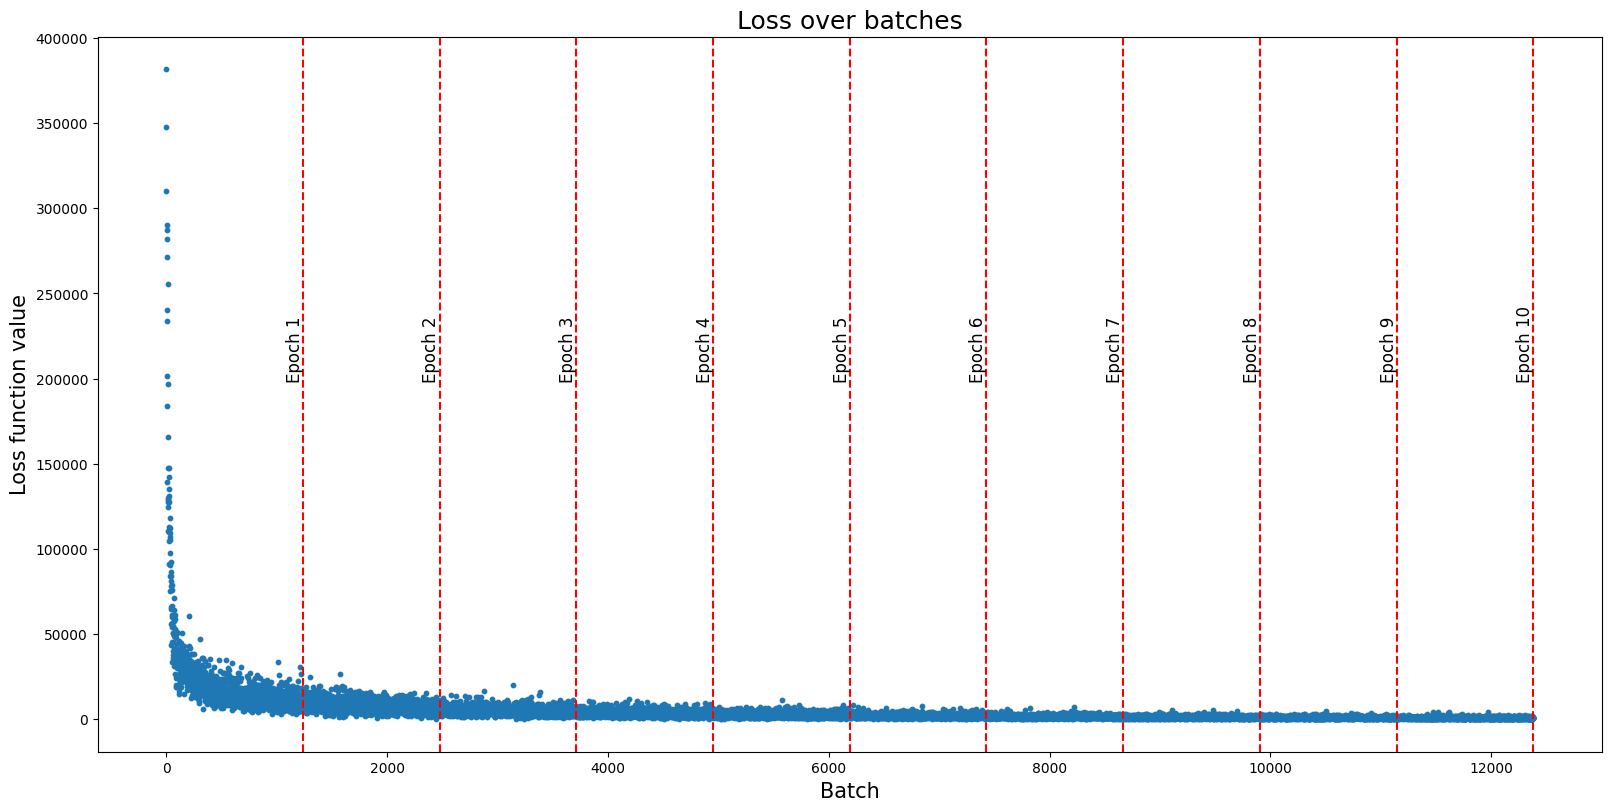

In [45]:
fnn_three_layer = ThreeLayerNN(128,128)
optimizer = torch.optim.Adam(fnn_three_layer.parameters())
train_NN(train_loader, val_loader, fnn_three_layer, loss_function, optimizer, 10, False, True)

This looks better, but still lower than the `two-layer network`. We'll try to improve the accuracy later using `regularization techniques`. </br>
Finally, let's see how `data standardization` affects the accuracy of the `three-layer model`.

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:


 10%|████▍                                       | 1/10 [00:03<00:32,  3.58s/it]

Train loss: 372.466, Validation loss: 200.092, Accuraccy: 0.659
Epoch number 2:


 20%|████████▊                                   | 2/10 [00:06<00:25,  3.24s/it]

Train loss: 144.735, Validation loss: 136.907, Accuraccy: 0.696
Epoch number 3:


 30%|█████████████▏                              | 3/10 [00:09<00:21,  3.13s/it]

Train loss: 93.424, Validation loss: 105.303, Accuraccy: 0.710
Epoch number 4:


 40%|█████████████████▌                          | 4/10 [00:12<00:18,  3.06s/it]

Train loss: 67.557, Validation loss: 89.097, Accuraccy: 0.717
Epoch number 5:


 50%|██████████████████████                      | 5/10 [00:15<00:15,  3.06s/it]

Train loss: 51.611, Validation loss: 74.924, Accuraccy: 0.728
Epoch number 6:


 60%|██████████████████████████▍                 | 6/10 [00:18<00:12,  3.11s/it]

Train loss: 40.684, Validation loss: 66.239, Accuraccy: 0.732
Epoch number 7:


 70%|██████████████████████████████▊             | 7/10 [00:22<00:09,  3.17s/it]

Train loss: 32.628, Validation loss: 59.870, Accuraccy: 0.737
Epoch number 8:


 80%|███████████████████████████████████▏        | 8/10 [00:25<00:06,  3.21s/it]

Train loss: 27.046, Validation loss: 55.590, Accuraccy: 0.747
Epoch number 9:


 90%|███████████████████████████████████████▌    | 9/10 [00:28<00:03,  3.24s/it]

Train loss: 22.521, Validation loss: 50.121, Accuraccy: 0.745
Epoch number 10:


100%|███████████████████████████████████████████| 10/10 [00:31<00:00,  3.18s/it]

Train loss: 18.998, Validation loss: 47.393, Accuraccy: 0.750


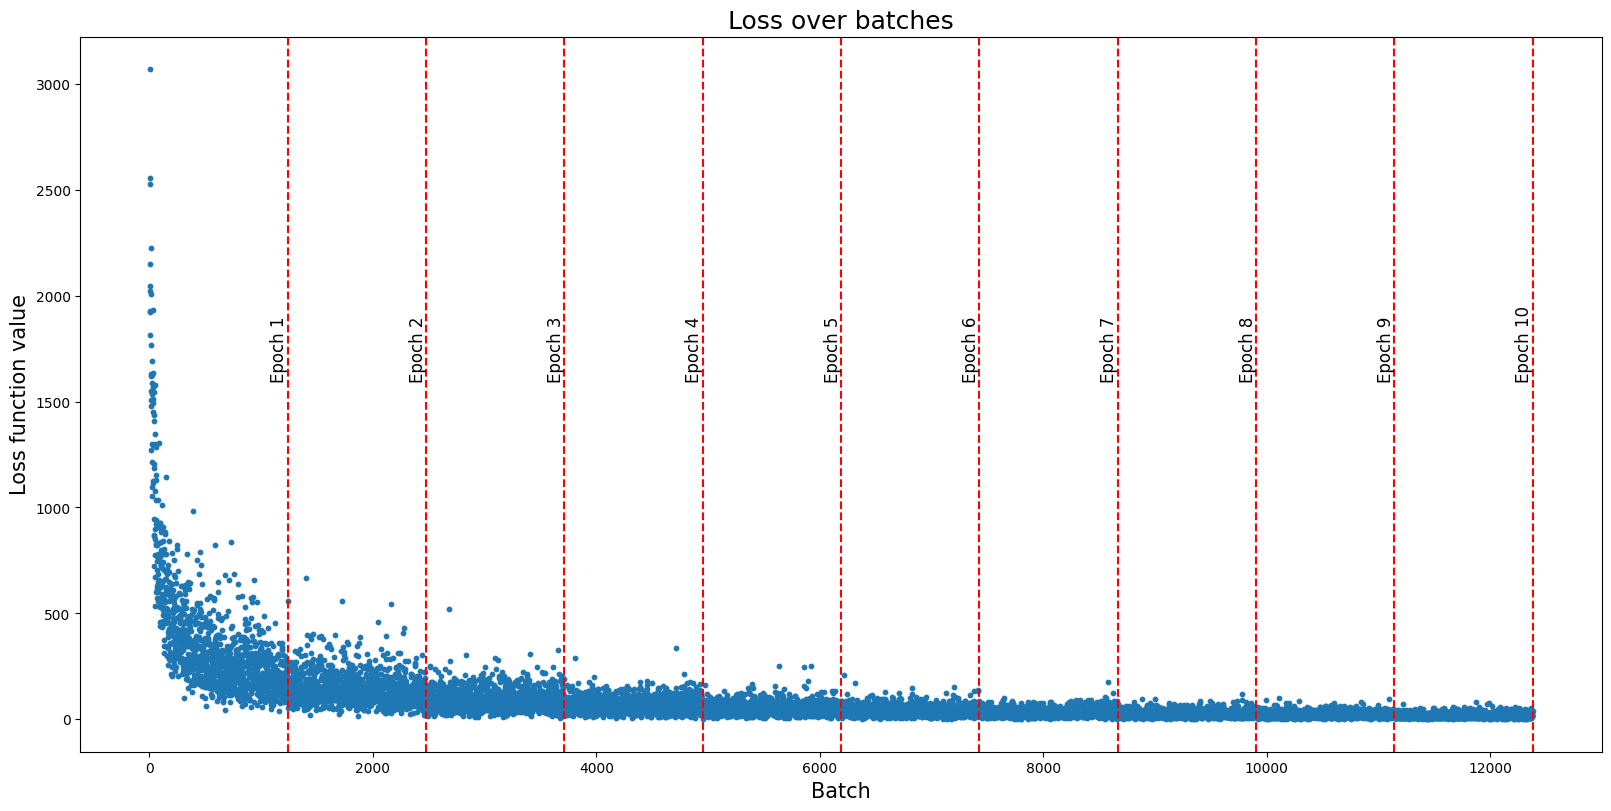

In [46]:
fnn_three_layer = ThreeLayerNN(128,128)
optimizer = torch.optim.Adam(fnn_three_layer.parameters())
train_NN(train_scaled_loader, val_scaled_loader, fnn_three_layer, loss_function, optimizer, 10, False, True)

The accuracy has improved.

Let's move on to creating a `four-layer neural network`. The logic here is the same as before.

In [47]:
class FourLayerNN(nn.Module):
    def __init__(self, hidden_layer1, hidden_layer2, hidden_layer3):
        super().__init__()
        self.fc1 = nn.Linear(32*32, hidden_layer1)
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.fc3 = nn.Linear(hidden_layer2, hidden_layer3)
        self.fco = nn.Linear(hidden_layer3, 10)
        
        nn.init.normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.normal_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.normal_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)
        nn.init.normal_(self.fco.weight)
        torch.nn.init.zeros_(self.fco.bias)

    def forward(self, x):
        x = x.flatten(start_dim=1).to(self.fc1.weight.dtype)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fco(x)
        return x
    
    def predict_proba(self, x):
        with torch.no_grad():
            pred = self.forward(x)
            probabilities = F.softmax(pred, dim=1)
        return probabilities

    def predict(self, x):
        probabilities = self.predict_proba(x)
        with torch.no_grad():
            max_probabilities, predicted_classes = torch.max(probabilities, dim=1)
        return predicted_classes

In [48]:
fnn_four_layer = FourLayerNN(128,64,32)
print(fnn_four_layer)
num_params = 0
for name, parameter in fnn_four_layer.named_parameters():
    print(f"{name}\nNumber: {parameter.numel()}\n")
    num_params += parameter.numel()
    
print(f"Total number of parameters: {num_params}")

FourLayerNN(
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fco): Linear(in_features=32, out_features=10, bias=True)
)
fc1.weight
Number: 131072

fc1.bias
Number: 128

fc2.weight
Number: 8192

fc2.bias
Number: 64

fc3.weight
Number: 2048

fc3.bias
Number: 32

fco.weight
Number: 320

fco.bias
Number: 10

Total number of parameters: 141866


  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:


 10%|████▍                                       | 1/10 [00:03<00:32,  3.60s/it]

Train loss: 34051.729, Validation loss: 12163.993, Accuraccy: 0.603
Epoch number 2:


 20%|████████▊                                   | 2/10 [00:06<00:27,  3.44s/it]

Train loss: 8057.686, Validation loss: 6072.634, Accuraccy: 0.632
Epoch number 3:


 30%|█████████████▏                              | 3/10 [00:10<00:23,  3.42s/it]

Train loss: 4382.817, Validation loss: 3814.192, Accuraccy: 0.653
Epoch number 4:


 40%|█████████████████▌                          | 4/10 [00:15<00:24,  4.07s/it]

Train loss: 2649.874, Validation loss: 2513.115, Accuraccy: 0.640
Epoch number 5:


 50%|██████████████████████                      | 5/10 [00:19<00:20,  4.00s/it]

Train loss: 1674.731, Validation loss: 1750.455, Accuraccy: 0.633
Epoch number 6:


 60%|██████████████████████████▍                 | 6/10 [00:22<00:15,  3.84s/it]

Train loss: 1105.968, Validation loss: 1216.725, Accuraccy: 0.636
Epoch number 7:


 70%|██████████████████████████████▊             | 7/10 [00:26<00:11,  3.74s/it]

Train loss: 749.348, Validation loss: 901.192, Accuraccy: 0.634
Epoch number 8:


 80%|███████████████████████████████████▏        | 8/10 [00:30<00:07,  3.81s/it]

Train loss: 526.556, Validation loss: 693.901, Accuraccy: 0.636
Epoch number 9:


 90%|███████████████████████████████████████▌    | 9/10 [00:34<00:03,  3.81s/it]

Train loss: 390.516, Validation loss: 551.317, Accuraccy: 0.660
Epoch number 10:


100%|███████████████████████████████████████████| 10/10 [00:37<00:00,  3.78s/it]

Train loss: 287.488, Validation loss: 429.954, Accuraccy: 0.650


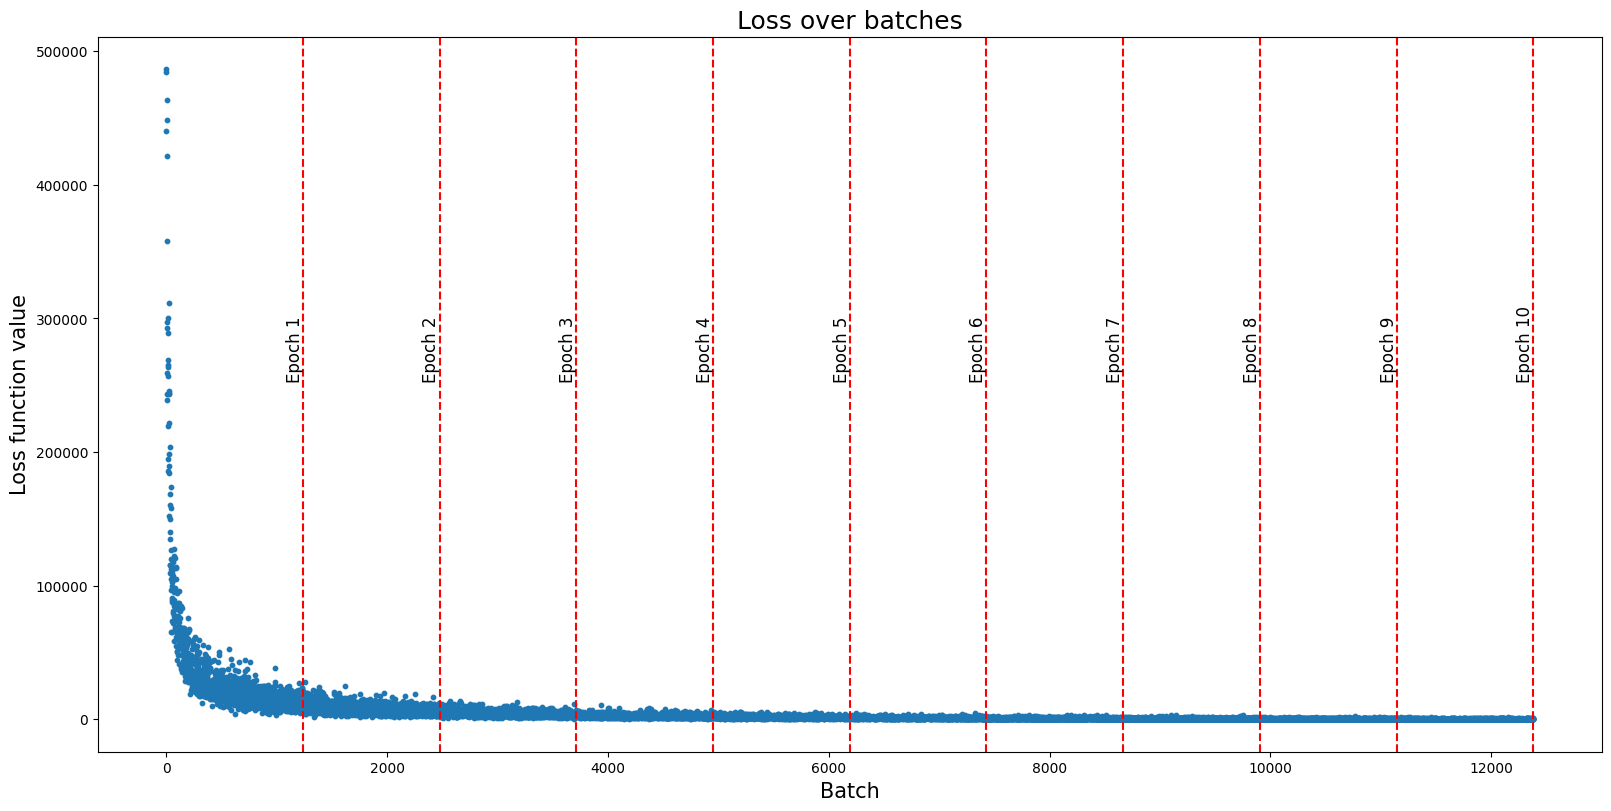

In [49]:
optimizer = torch.optim.Adam(fnn_four_layer.parameters())
train_NN(train_loader, val_loader, fnn_four_layer, loss_function, optimizer, 10, False, True)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:


 10%|████▍                                       | 1/10 [00:03<00:34,  3.88s/it]

Train loss: 115486.427, Validation loss: 40916.332, Accuraccy: 0.672
Epoch number 2:


 20%|████████▊                                   | 2/10 [00:07<00:30,  3.80s/it]

Train loss: 31510.973, Validation loss: 25555.551, Accuraccy: 0.690
Epoch number 3:


 30%|█████████████▏                              | 3/10 [00:11<00:27,  3.86s/it]

Train loss: 19983.111, Validation loss: 19040.320, Accuraccy: 0.682
Epoch number 4:


 40%|█████████████████▌                          | 4/10 [00:15<00:22,  3.83s/it]

Train loss: 14030.319, Validation loss: 14019.157, Accuraccy: 0.704
Epoch number 5:


 50%|██████████████████████                      | 5/10 [00:19<00:19,  3.87s/it]

Train loss: 10344.298, Validation loss: 12270.023, Accuraccy: 0.690
Epoch number 6:


 60%|██████████████████████████▍                 | 6/10 [00:23<00:15,  3.89s/it]

Train loss: 8021.835, Validation loss: 8963.794, Accuraccy: 0.715
Epoch number 7:


 70%|██████████████████████████████▊             | 7/10 [00:27<00:12,  4.02s/it]

Train loss: 6107.324, Validation loss: 7495.806, Accuraccy: 0.706
Epoch number 8:


 80%|███████████████████████████████████▏        | 8/10 [00:31<00:07,  3.97s/it]

Train loss: 5019.633, Validation loss: 7242.695, Accuraccy: 0.689
Epoch number 9:


 90%|███████████████████████████████████████▌    | 9/10 [00:35<00:03,  3.93s/it]

Train loss: 4248.906, Validation loss: 6774.609, Accuraccy: 0.707
Epoch number 10:


100%|███████████████████████████████████████████| 10/10 [00:39<00:00,  3.92s/it]

Train loss: 3662.051, Validation loss: 5959.255, Accuraccy: 0.719


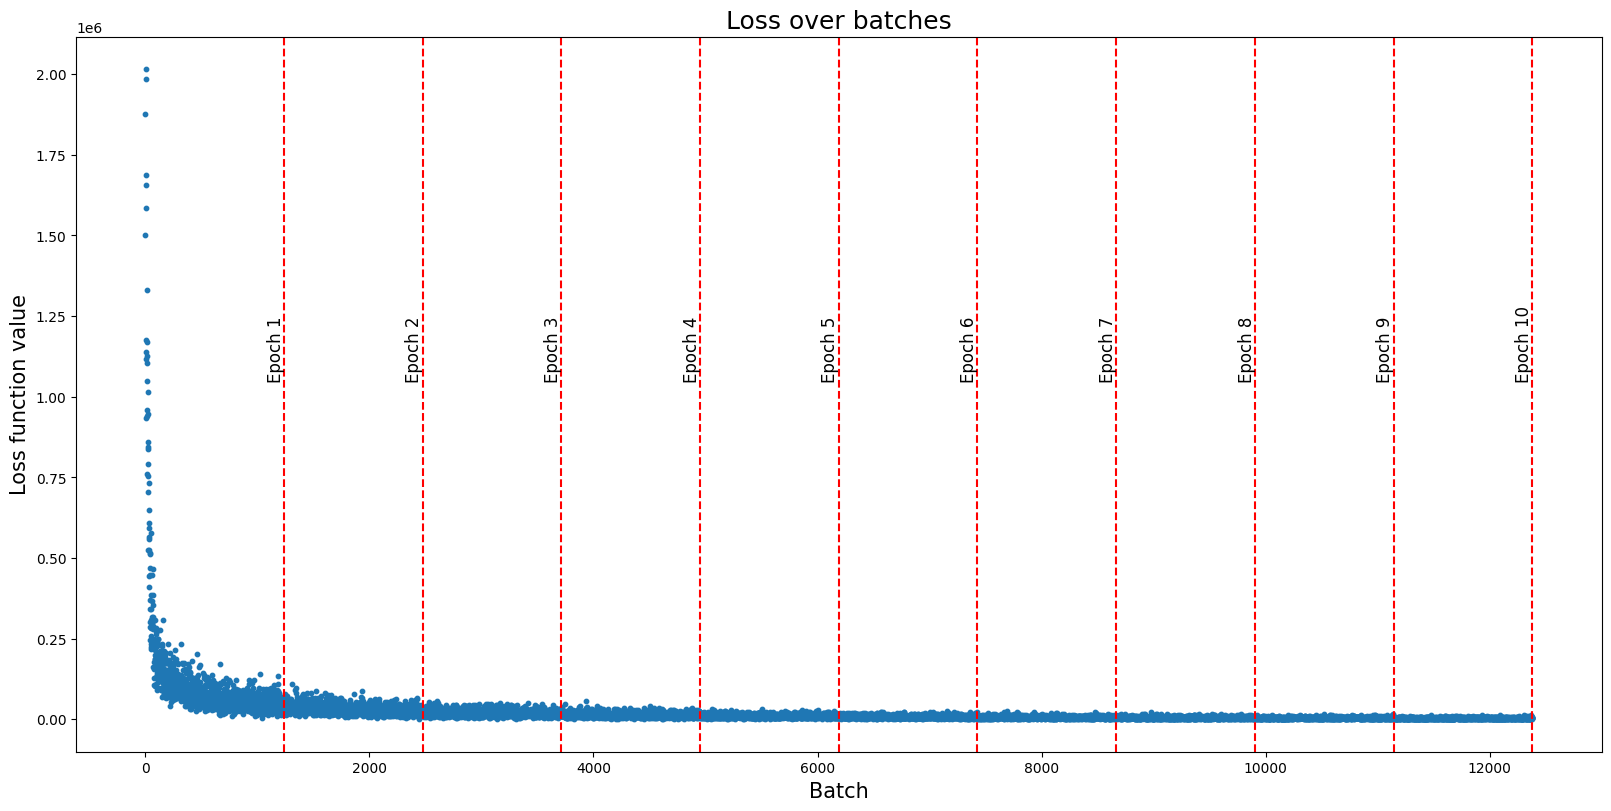

In [50]:
fnn_four_layer = FourLayerNN(128,128,128)
optimizer = torch.optim.Adam(fnn_four_layer.parameters())
train_NN(train_loader, val_loader, fnn_four_layer, loss_function, optimizer, 10, False, True)

Results for the four-layer network are `almost identical` to the results for the three-layer network. Later we will see if `regularization techniques` have any impact on this.

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:


 10%|████▍                                       | 1/10 [00:03<00:29,  3.24s/it]

Train loss: 819.600, Validation loss: 190.703, Accuraccy: 0.475
Epoch number 2:


 20%|████████▊                                   | 2/10 [00:06<00:26,  3.32s/it]

Train loss: 80.620, Validation loss: 29.094, Accuraccy: 0.285
Epoch number 3:


 30%|█████████████▏                              | 3/10 [00:09<00:22,  3.26s/it]

Train loss: 10.355, Validation loss: 4.899, Accuraccy: 0.177
Epoch number 4:


 40%|█████████████████▌                          | 4/10 [00:13<00:20,  3.40s/it]

Train loss: 2.798, Validation loss: 3.651, Accuraccy: 0.159
Epoch number 5:


 50%|██████████████████████                      | 5/10 [00:16<00:17,  3.46s/it]

Train loss: 2.264, Validation loss: 3.418, Accuraccy: 0.173
Epoch number 6:


 60%|██████████████████████████▍                 | 6/10 [00:20<00:14,  3.60s/it]

Train loss: 2.196, Validation loss: 3.096, Accuraccy: 0.170
Epoch number 7:


 70%|██████████████████████████████▊             | 7/10 [00:24<00:10,  3.46s/it]

Train loss: 2.169, Validation loss: 2.956, Accuraccy: 0.173
Epoch number 8:


 80%|███████████████████████████████████▏        | 8/10 [00:27<00:06,  3.38s/it]

Train loss: 2.198, Validation loss: 2.988, Accuraccy: 0.169
Epoch number 9:


 90%|███████████████████████████████████████▌    | 9/10 [00:30<00:03,  3.36s/it]

Train loss: 2.130, Validation loss: 2.665, Accuraccy: 0.185
Epoch number 10:


100%|███████████████████████████████████████████| 10/10 [00:34<00:00,  3.43s/it]

Train loss: 2.187, Validation loss: 2.322, Accuraccy: 0.177


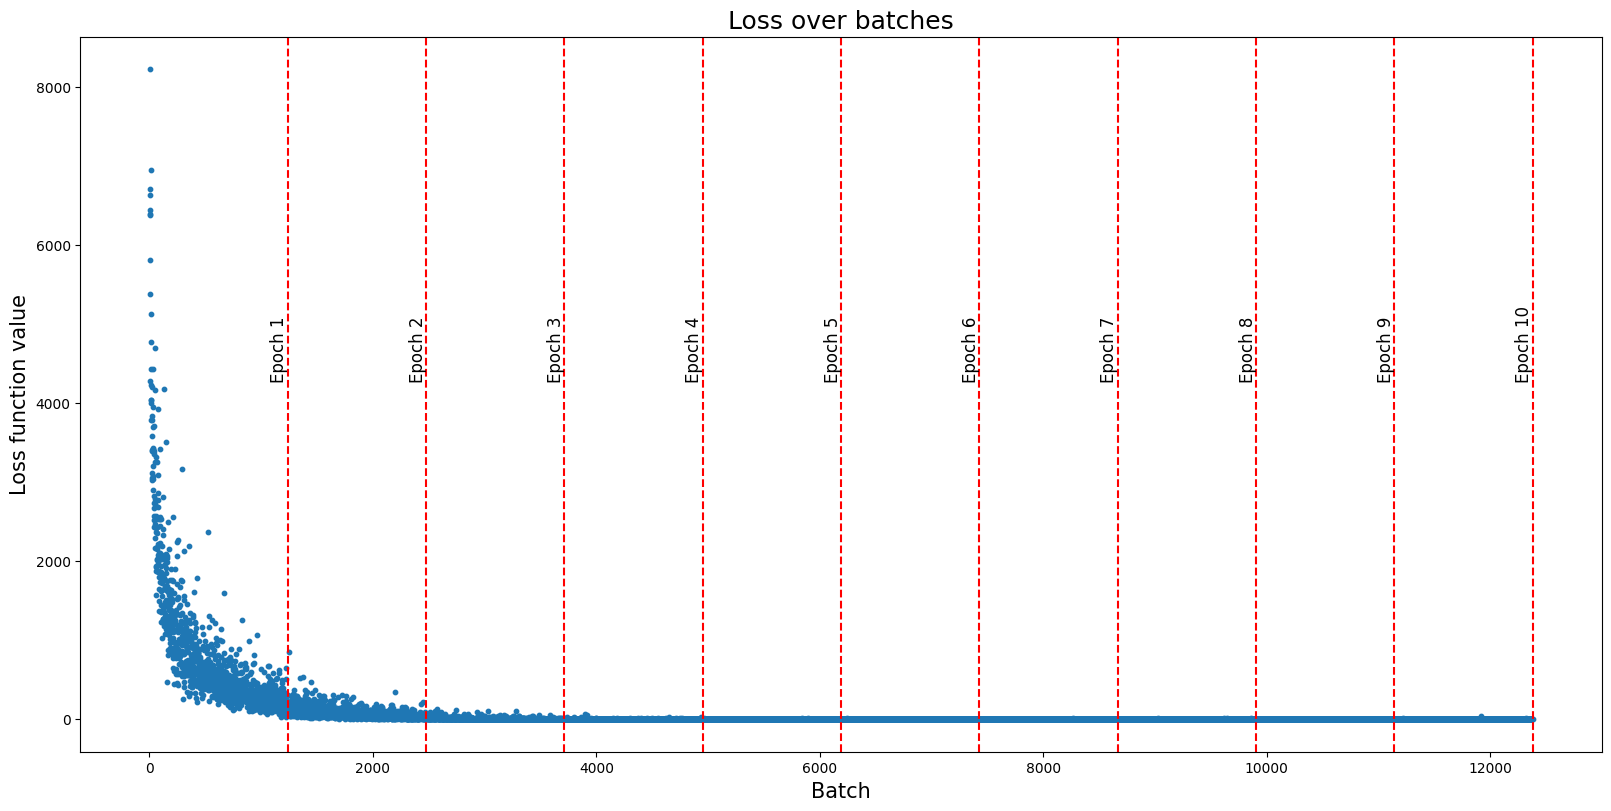

In [51]:
fnn_four_layer = FourLayerNN(128,64,32)
optimizer = torch.optim.Adam(fnn_four_layer.parameters())
train_NN(train_scaled_loader, val_scaled_loader, fnn_four_layer, loss_function, optimizer, 10, False, True)

That's interesting. It seems that on `standardized data`, this model quickly `overfits` and its accuracy becomes very low.

Let's also see how the accuracy of the model will change if we replace the **ReLU** activation function in the hidden layers with **SELU**.

In [52]:
class TwoLayerSeluNN(nn.Module):
    def __init__(self, hidden_layer):
        super().__init__()
        self.fc1 = nn.Linear(32*32, hidden_layer)
        self.fco = nn.Linear(hidden_layer, 10)
        
        nn.init.normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.normal_(self.fco.weight)
        nn.init.zeros_(self.fco.bias)

    def forward(self, x):
        x = x.flatten(start_dim=1).to(self.fc1.weight.dtype)
        x = F.selu(self.fc1(x))
        x = self.fco(x)
        return x
    
    def predict_proba(self, x):
        with torch.no_grad():
            pred = self.forward(x)
            probabilities = F.softmax(pred, dim=1)
        return probabilities

    def predict(self, x):
        probabilities = self.predict_proba(x)
        with torch.no_grad():
            max_probabilities, predicted_classes = torch.max(probabilities, dim=1)
        return predicted_classes

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:


 10%|████▍                                       | 1/10 [00:06<00:54,  6.02s/it]

Train loss: 4463.997, Validation loss: 2453.983, Accuraccy: 0.680
Epoch number 2:


 20%|████████▊                                   | 2/10 [00:12<00:48,  6.03s/it]

Train loss: 1860.471, Validation loss: 1776.708, Accuraccy: 0.712
Epoch number 3:


 30%|█████████████▏                              | 3/10 [00:17<00:40,  5.82s/it]

Train loss: 1361.786, Validation loss: 1427.216, Accuraccy: 0.718
Epoch number 4:


 40%|█████████████████▌                          | 4/10 [00:23<00:34,  5.76s/it]

Train loss: 1073.868, Validation loss: 1295.738, Accuraccy: 0.714
Epoch number 5:


 50%|██████████████████████                      | 5/10 [00:28<00:28,  5.67s/it]

Train loss: 900.495, Validation loss: 1075.550, Accuraccy: 0.746
Epoch number 6:


 60%|██████████████████████████▍                 | 6/10 [00:34<00:22,  5.69s/it]

Train loss: 764.543, Validation loss: 1067.957, Accuraccy: 0.735
Epoch number 7:


 70%|██████████████████████████████▊             | 7/10 [00:39<00:16,  5.61s/it]

Train loss: 660.196, Validation loss: 901.434, Accuraccy: 0.756
Epoch number 8:


 80%|███████████████████████████████████▏        | 8/10 [00:45<00:11,  5.56s/it]

Train loss: 576.219, Validation loss: 836.698, Accuraccy: 0.757
Epoch number 9:


 90%|███████████████████████████████████████▌    | 9/10 [00:50<00:05,  5.56s/it]

Train loss: 507.098, Validation loss: 811.986, Accuraccy: 0.753
Epoch number 10:


100%|███████████████████████████████████████████| 10/10 [00:56<00:00,  5.66s/it]

Train loss: 450.206, Validation loss: 719.432, Accuraccy: 0.770


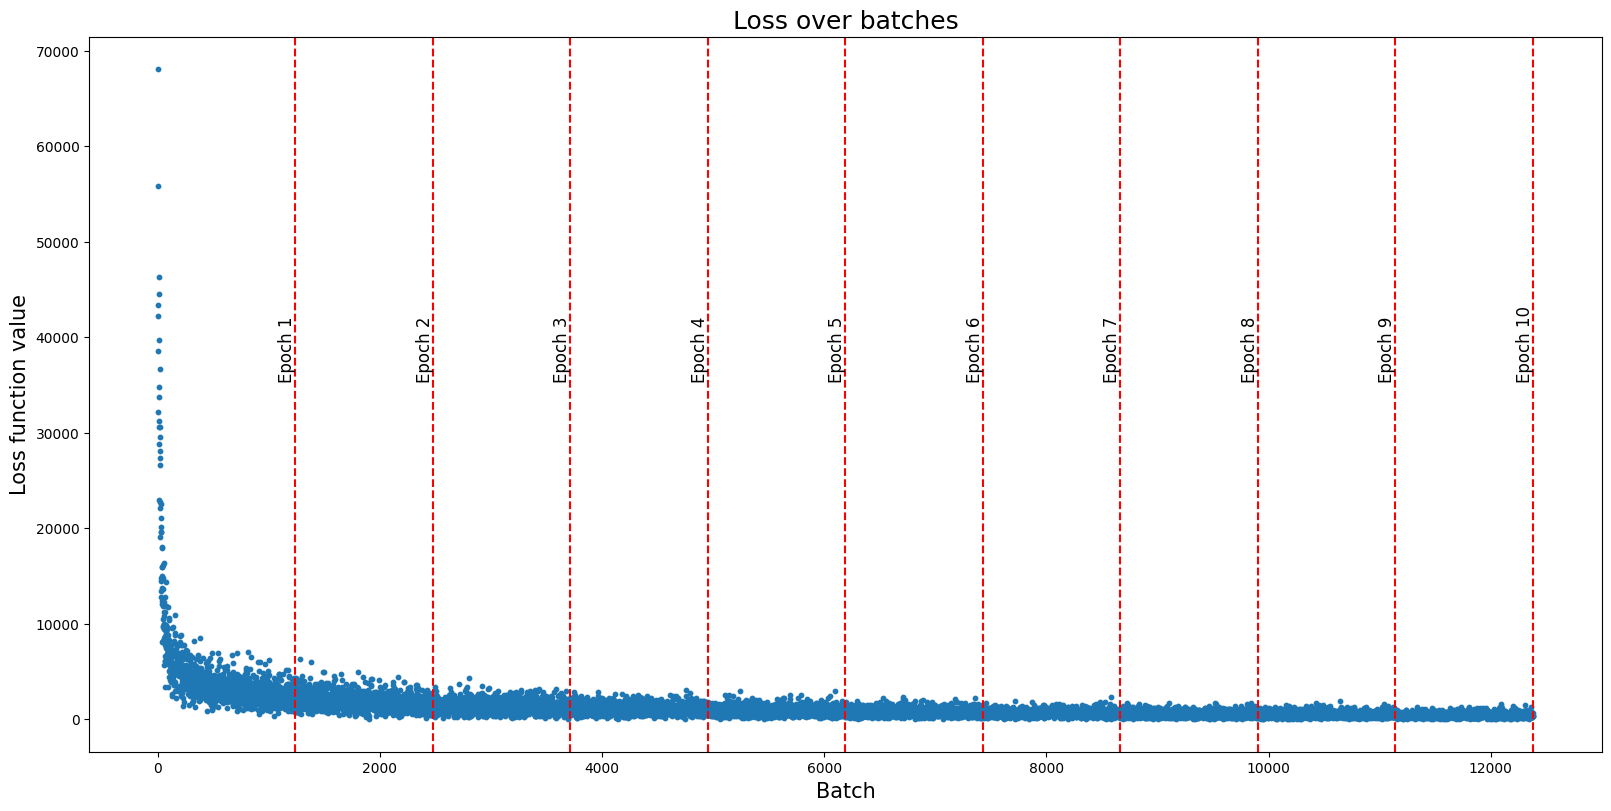

In [53]:
fnn_two_layer_selu = TwoLayerSeluNN(256)
optimizer = torch.optim.Adam(fnn_two_layer_selu.parameters())
train_NN(train_loader, val_loader, fnn_two_layer_selu, loss_function, optimizer, 10, False, True)

The results are slightly worse than with **ReLU** activation, so we will stick with the previous activation function.

The last experiment we will conduct before moving on to **CNN** is to increase the `number of epochs` for the current best model and check if it starts to `overfit`.

  0%|                                                    | 0/15 [00:00<?, ?it/s]

Epoch number 1:


  7%|██▉                                         | 1/15 [00:08<01:57,  8.41s/it]

Train loss: 5616.979, Validation loss: 3040.150, Accuraccy: 0.706
Epoch number 2:


 13%|█████▊                                      | 2/15 [00:16<01:44,  8.02s/it]

Train loss: 2417.266, Validation loss: 2431.048, Accuraccy: 0.727
Epoch number 3:


 20%|████████▊                                   | 3/15 [00:25<01:41,  8.47s/it]

Train loss: 1892.482, Validation loss: 2242.259, Accuraccy: 0.726
Epoch number 4:


 27%|███████████▋                                | 4/15 [00:34<01:36,  8.75s/it]

Train loss: 1578.051, Validation loss: 1842.647, Accuraccy: 0.757
Epoch number 5:


 33%|██████████████▋                             | 5/15 [00:43<01:27,  8.78s/it]

Train loss: 1349.325, Validation loss: 1590.597, Accuraccy: 0.772
Epoch number 6:


 40%|█████████████████▌                          | 6/15 [00:51<01:18,  8.77s/it]

Train loss: 1186.649, Validation loss: 1505.278, Accuraccy: 0.766
Epoch number 7:


 47%|████████████████████▌                       | 7/15 [01:00<01:10,  8.76s/it]

Train loss: 1053.206, Validation loss: 1569.173, Accuraccy: 0.758
Epoch number 8:


 53%|███████████████████████▍                    | 8/15 [01:09<01:02,  8.87s/it]

Train loss: 966.388, Validation loss: 1483.000, Accuraccy: 0.771
Epoch number 9:


 60%|██████████████████████████▍                 | 9/15 [01:19<00:54,  9.03s/it]

Train loss: 861.676, Validation loss: 1340.375, Accuraccy: 0.786
Epoch number 10:


 67%|████████████████████████████▋              | 10/15 [01:28<00:45,  9.19s/it]

Train loss: 779.148, Validation loss: 1322.319, Accuraccy: 0.777
Epoch number 11:


 73%|███████████████████████████████▌           | 11/15 [01:38<00:37,  9.45s/it]

Train loss: 741.462, Validation loss: 1342.289, Accuraccy: 0.775
Epoch number 12:


 80%|██████████████████████████████████▍        | 12/15 [01:48<00:28,  9.61s/it]

Train loss: 683.487, Validation loss: 1300.177, Accuraccy: 0.781
Epoch number 13:


 87%|█████████████████████████████████████▎     | 13/15 [01:57<00:18,  9.45s/it]

Train loss: 619.587, Validation loss: 1189.838, Accuraccy: 0.794
Epoch number 14:


 93%|████████████████████████████████████████▏  | 14/15 [02:06<00:09,  9.19s/it]

Train loss: 570.732, Validation loss: 1228.814, Accuraccy: 0.784
Epoch number 15:


100%|███████████████████████████████████████████| 15/15 [02:16<00:00,  9.08s/it]

Train loss: 551.646, Validation loss: 1142.807, Accuraccy: 0.794


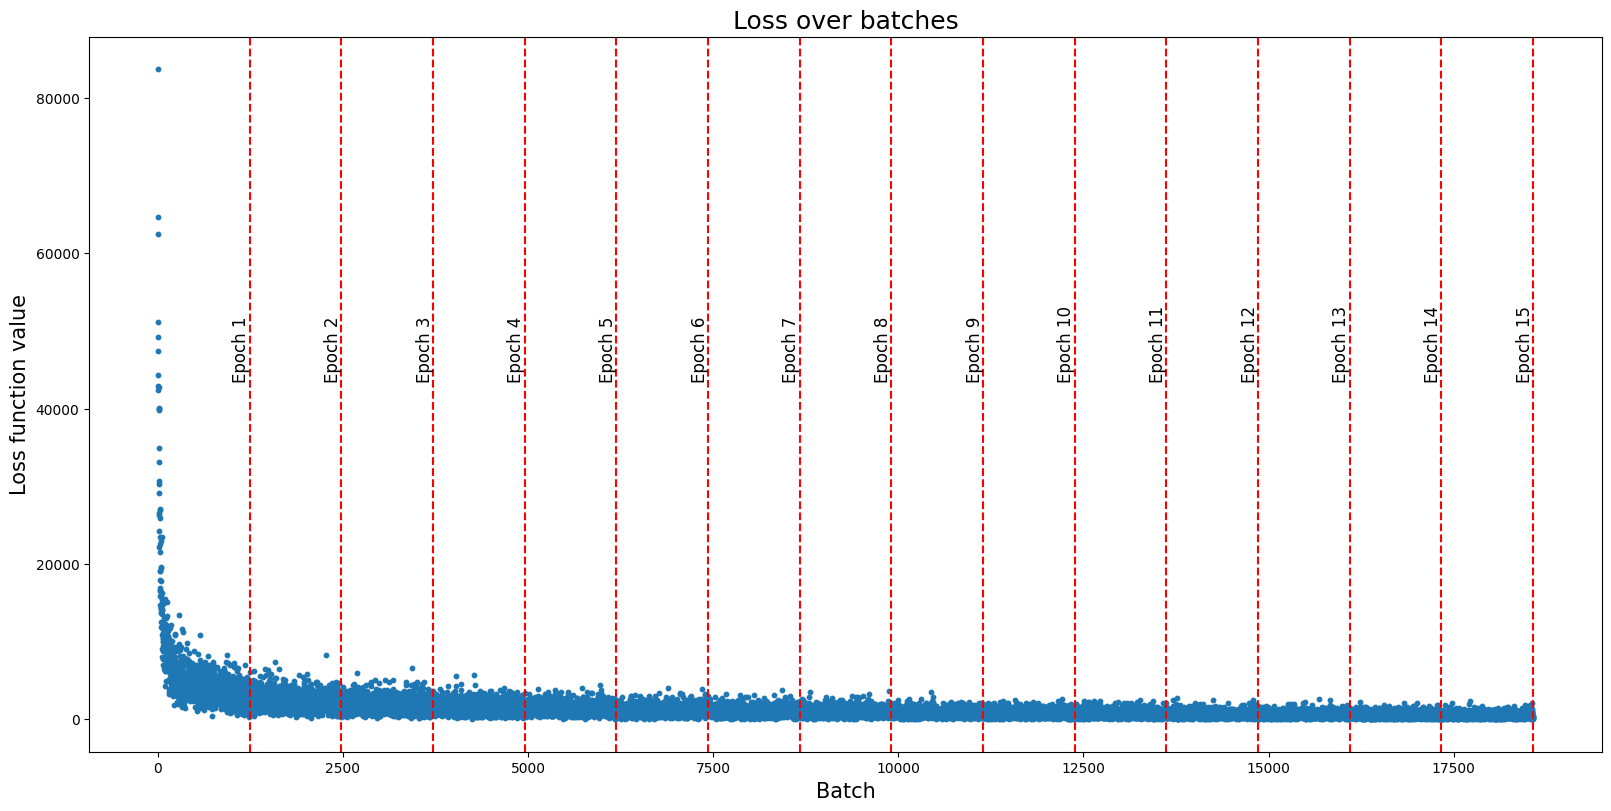

In [54]:
fnn_two_layer = TwoLayerNN(512)
optimizer = torch.optim.Adam(fnn_two_layer.parameters())
train_NN(train_loader, val_loader, fnn_two_layer, loss_function, optimizer, 15, False, True)

After `13 epochs`, we have obtained the best model so far. Now, let's try to improve our results using **CNN** (Convolutional Neural Network).

#### Convolutional Neural Network (CNN)

**Convolutional Neural Networks (CNN)** have emerged as the go-to architecture for `image classification tasks`, and for good reason. When dealing with image data, **CNN** offer several key advantages that make them highly suitable for this type of tasks. </br>
**CNN** uses specialized layers such as convolutional layers and pooling layers to extract meaningful features from the input images. This hierarchical feature extraction enables **CNN** to automatically learn and capture important `patterns and visual representations`, such as edges, textures, and shapes, that are crucial for distinguishing between different image classes. </br>
Another strength of **CNNs** is their ability to handle the high dimensionality of image data. Unlike fully connected neural networks, where `each input feature is connected to every neuron in the subsequent layers`, **CNNs** employ shared weights and local receptive fields. This dramatically reduces the number of parameters, making CNNs computationally efficient. </br>
These characteristics make **CNN** a powerful choice for `image classification problems`. So we are waiting for increasing of validation accuracy. 

First, let's create a simple `three-layer convolutional neural network`, that consists of two convolutional layers with pooling layers in between, followed by a fully connected output layer. 

In [55]:
class ConvThreeLayerNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(32, 16, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fco = nn.Linear(16*7*7, 10)

        
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)
        nn.init.xavier_normal_(self.fco.weight)
        nn.init.zeros_(self.fco.bias)

    def forward(self, x):
        x = F.relu(self.conv1(x.to(self.conv1.weight.dtype)))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.flatten(start_dim = 1)
        x = self.fco(x)
        return x
    
    def predict_proba(self, x):
        with torch.no_grad():
            pred = self.forward(x)
            probabilities = F.softmax(pred, dim=1)
        return probabilities

    def predict(self, x):
        probabilities = self.predict_proba(x)
        with torch.no_grad():
            max_probabilities, predicted_classes = torch.max(probabilities, dim=1)
        return predicted_classes

In [56]:
cnn_three_layer = ConvThreeLayerNN()
print(cnn_three_layer)
num_params = 0
for name, parameter in cnn_three_layer.named_parameters():
    print(f"{name}\nNumber: {parameter.numel()}\n")
    num_params += parameter.numel()
    
print(f"Total number of parameters: {num_params}")

ConvThreeLayerNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fco): Linear(in_features=784, out_features=10, bias=True)
)
conv1.weight
Number: 288

conv1.bias
Number: 32

conv2.weight
Number: 2048

conv2.bias
Number: 16

fco.weight
Number: 7840

fco.bias
Number: 10

Total number of parameters: 10234


  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:
  Batch 300 loss: 6.606
  Batch 600 loss: 1.230
  Batch 900 loss: 0.815
  Batch 1200 loss: 0.855
  Batch 1238 loss: 0.799


 10%|████▍                                       | 1/10 [00:18<02:48, 18.68s/it]

Train loss: 5.530, Validation loss: 0.847, Accuraccy: 0.715
Epoch number 2:
  Batch 300 loss: 0.624
  Batch 600 loss: 0.808
  Batch 900 loss: 0.679
  Batch 1200 loss: 1.054
  Batch 1238 loss: 0.645


 20%|████████▊                                   | 2/10 [00:38<02:33, 19.24s/it]

Train loss: 0.735, Validation loss: 0.713, Accuraccy: 0.752
Epoch number 3:
  Batch 300 loss: 0.465
  Batch 600 loss: 0.777
  Batch 900 loss: 0.596
  Batch 1200 loss: 0.484
  Batch 1238 loss: 0.839


 30%|█████████████▏                              | 3/10 [00:59<02:21, 20.19s/it]

Train loss: 0.654, Validation loss: 0.689, Accuraccy: 0.748
Epoch number 4:
  Batch 300 loss: 0.543
  Batch 600 loss: 0.475
  Batch 900 loss: 0.748
  Batch 1200 loss: 1.101
  Batch 1238 loss: 0.708


 40%|█████████████████▌                          | 4/10 [01:17<01:54, 19.16s/it]

Train loss: 0.613, Validation loss: 0.631, Accuraccy: 0.772
Epoch number 5:
  Batch 300 loss: 0.475
  Batch 600 loss: 0.302
  Batch 900 loss: 0.507
  Batch 1200 loss: 0.905
  Batch 1238 loss: 0.285


 50%|██████████████████████                      | 5/10 [01:35<01:34, 18.97s/it]

Train loss: 0.586, Validation loss: 0.585, Accuraccy: 0.784
Epoch number 6:
  Batch 300 loss: 0.773
  Batch 600 loss: 0.599
  Batch 900 loss: 0.885
  Batch 1200 loss: 0.673
  Batch 1238 loss: 0.439


 60%|██████████████████████████▍                 | 6/10 [01:55<01:16, 19.22s/it]

Train loss: 0.571, Validation loss: 0.631, Accuraccy: 0.777
Epoch number 7:
  Batch 300 loss: 0.508
  Batch 600 loss: 0.543
  Batch 900 loss: 0.600
  Batch 1200 loss: 0.479
  Batch 1238 loss: 0.555


 70%|██████████████████████████████▊             | 7/10 [02:15<00:58, 19.55s/it]

Train loss: 0.549, Validation loss: 0.586, Accuraccy: 0.789
Epoch number 8:
  Batch 300 loss: 0.750
  Batch 600 loss: 1.026
  Batch 900 loss: 0.552
  Batch 1200 loss: 0.655
  Batch 1238 loss: 0.348


 80%|███████████████████████████████████▏        | 8/10 [02:34<00:38, 19.18s/it]

Train loss: 0.533, Validation loss: 0.598, Accuraccy: 0.792
Epoch number 9:
  Batch 300 loss: 0.651
  Batch 600 loss: 0.791
  Batch 900 loss: 0.446
  Batch 1200 loss: 0.360
  Batch 1238 loss: 0.426


 90%|███████████████████████████████████████▌    | 9/10 [02:55<00:19, 19.74s/it]

Train loss: 0.513, Validation loss: 0.603, Accuraccy: 0.787
Epoch number 10:
  Batch 300 loss: 0.593
  Batch 600 loss: 0.230
  Batch 900 loss: 0.384
  Batch 1200 loss: 0.799
  Batch 1238 loss: 0.330


100%|███████████████████████████████████████████| 10/10 [03:14<00:00, 19.43s/it]

Train loss: 0.502, Validation loss: 0.528, Accuraccy: 0.806


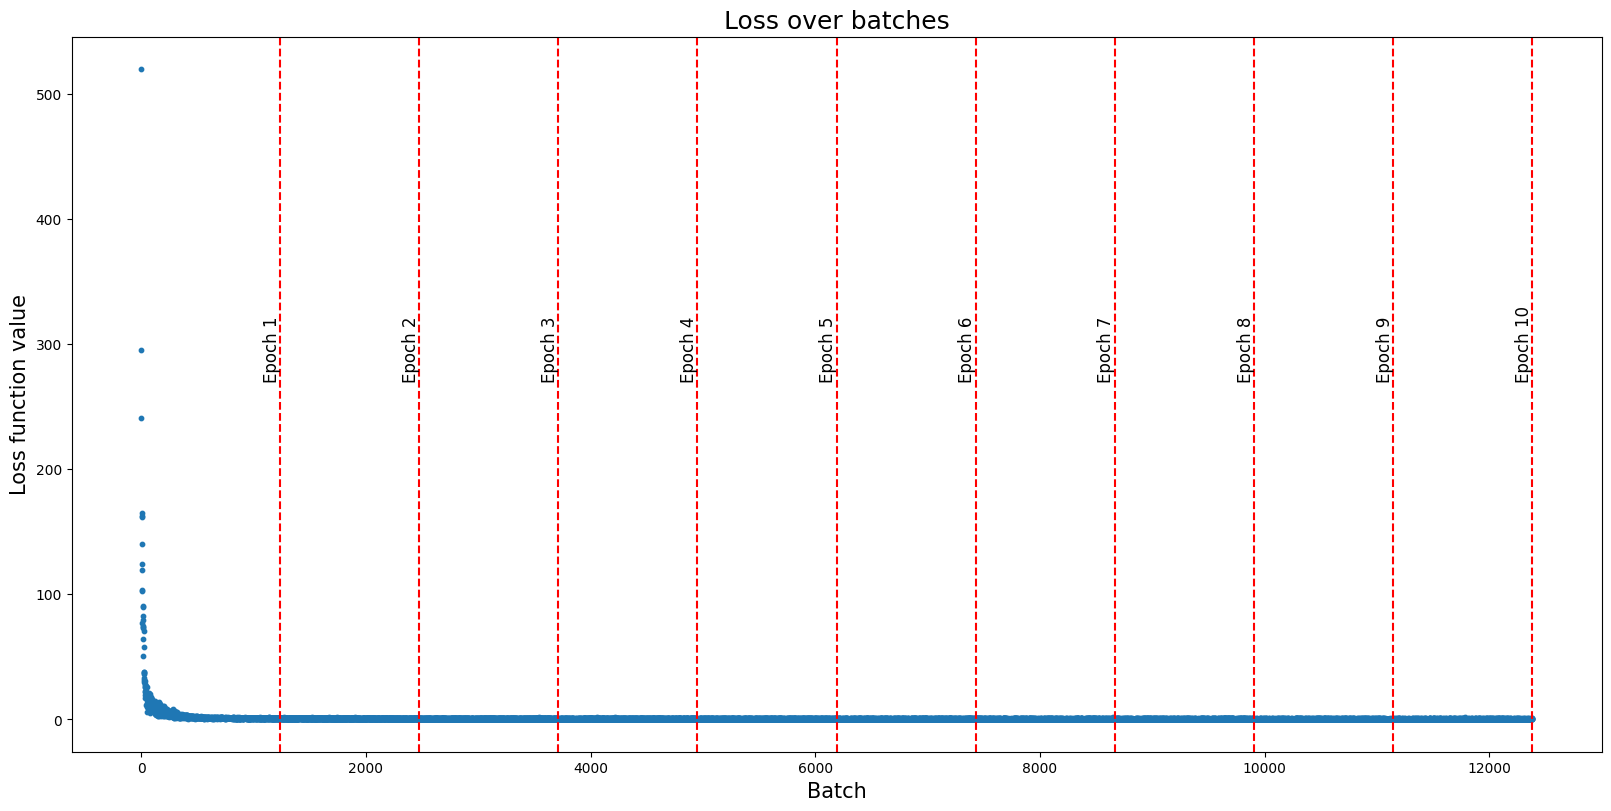

In [57]:
optimizer = torch.optim.Adam(cnn_three_layer.parameters())
train_NN(train_loader, val_loader, cnn_three_layer, loss_function, optimizer, 10, True, True)

As we can see, the results have improved compared to previous models. 

Now let's move on to `tuning hyperparameters`. First, we will try to find the optimizer that provides the `highest accuracy on validation` for our model. `Learning rate` will set to **0.001**. </br>
We will use `Adam optimizer`, `SGD optimizer` and `RMSProp optimizer`.

Optimizer class: <class 'torch.optim.sgd.SGD'>:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:17<01:10, 17.68s/it]

Train loss: 3.439, Validation loss: 1.225, Accuraccy: 0.565
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:35<00:52, 17.53s/it]

Train loss: 1.083, Validation loss: 0.968, Accuraccy: 0.656
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:52<00:35, 17.52s/it]

Train loss: 0.929, Validation loss: 0.890, Accuraccy: 0.686
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [01:12<00:18, 18.53s/it]

Train loss: 0.847, Validation loss: 0.803, Accuraccy: 0.721
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [01:29<00:00, 17.99s/it]


Train loss: 0.788, Validation loss: 0.760, Accuraccy: 0.725


Optimizer class: <class 'torch.optim.adam.Adam'>:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:21<01:25, 21.45s/it]

Train loss: 3.716, Validation loss: 0.767, Accuraccy: 0.736
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:42<01:04, 21.42s/it]

Train loss: 0.692, Validation loss: 0.671, Accuraccy: 0.755
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [01:03<00:42, 21.19s/it]

Train loss: 0.624, Validation loss: 0.637, Accuraccy: 0.775
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [01:24<00:21, 21.04s/it]

Train loss: 0.589, Validation loss: 0.626, Accuraccy: 0.781
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [01:41<00:00, 20.37s/it]


Train loss: 0.569, Validation loss: 0.575, Accuraccy: 0.790


Optimizer class: <class 'torch.optim.rmsprop.RMSprop'>:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:17<01:08, 17.13s/it]

Train loss: 2.566, Validation loss: 0.747, Accuraccy: 0.725
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:34<00:52, 17.38s/it]

Train loss: 0.702, Validation loss: 0.693, Accuraccy: 0.754
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:53<00:35, 17.82s/it]

Train loss: 0.647, Validation loss: 0.679, Accuraccy: 0.755
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [01:12<00:18, 18.36s/it]

Train loss: 0.619, Validation loss: 0.655, Accuraccy: 0.767
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [01:29<00:00, 17.88s/it]

Train loss: 0.601, Validation loss: 0.680, Accuraccy: 0.763




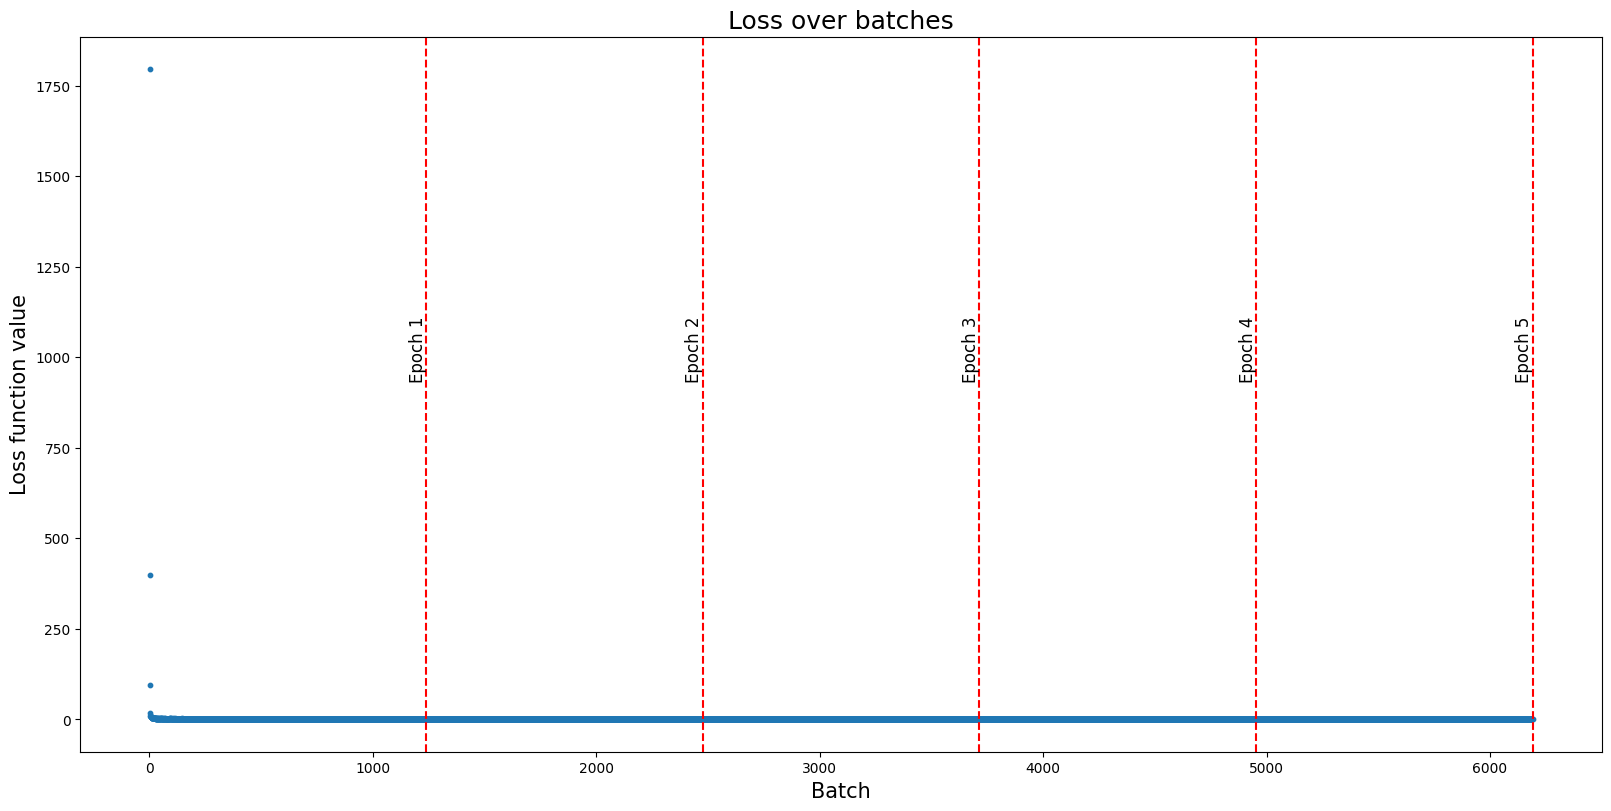

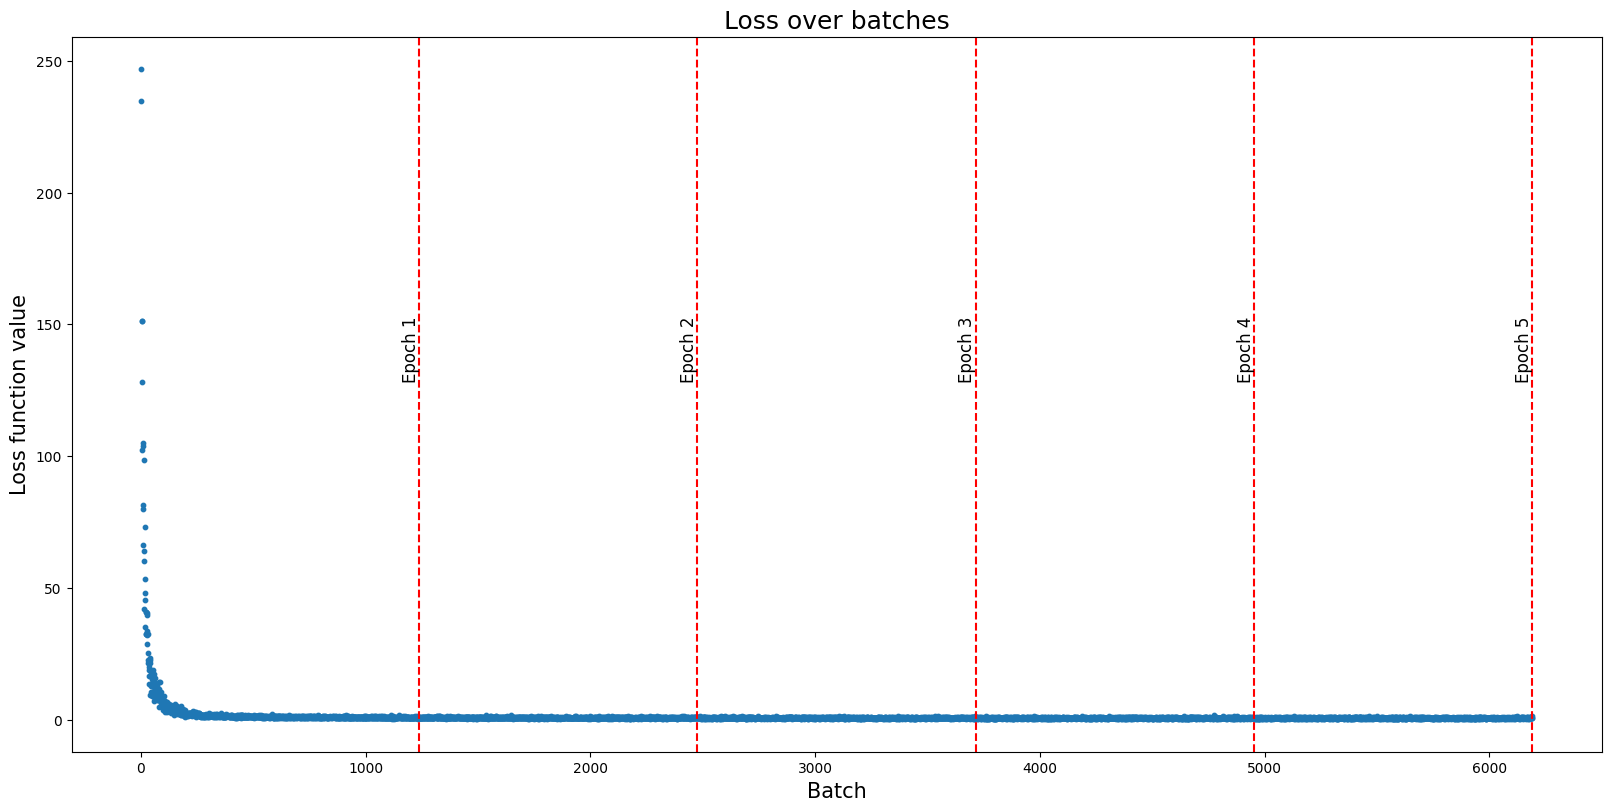

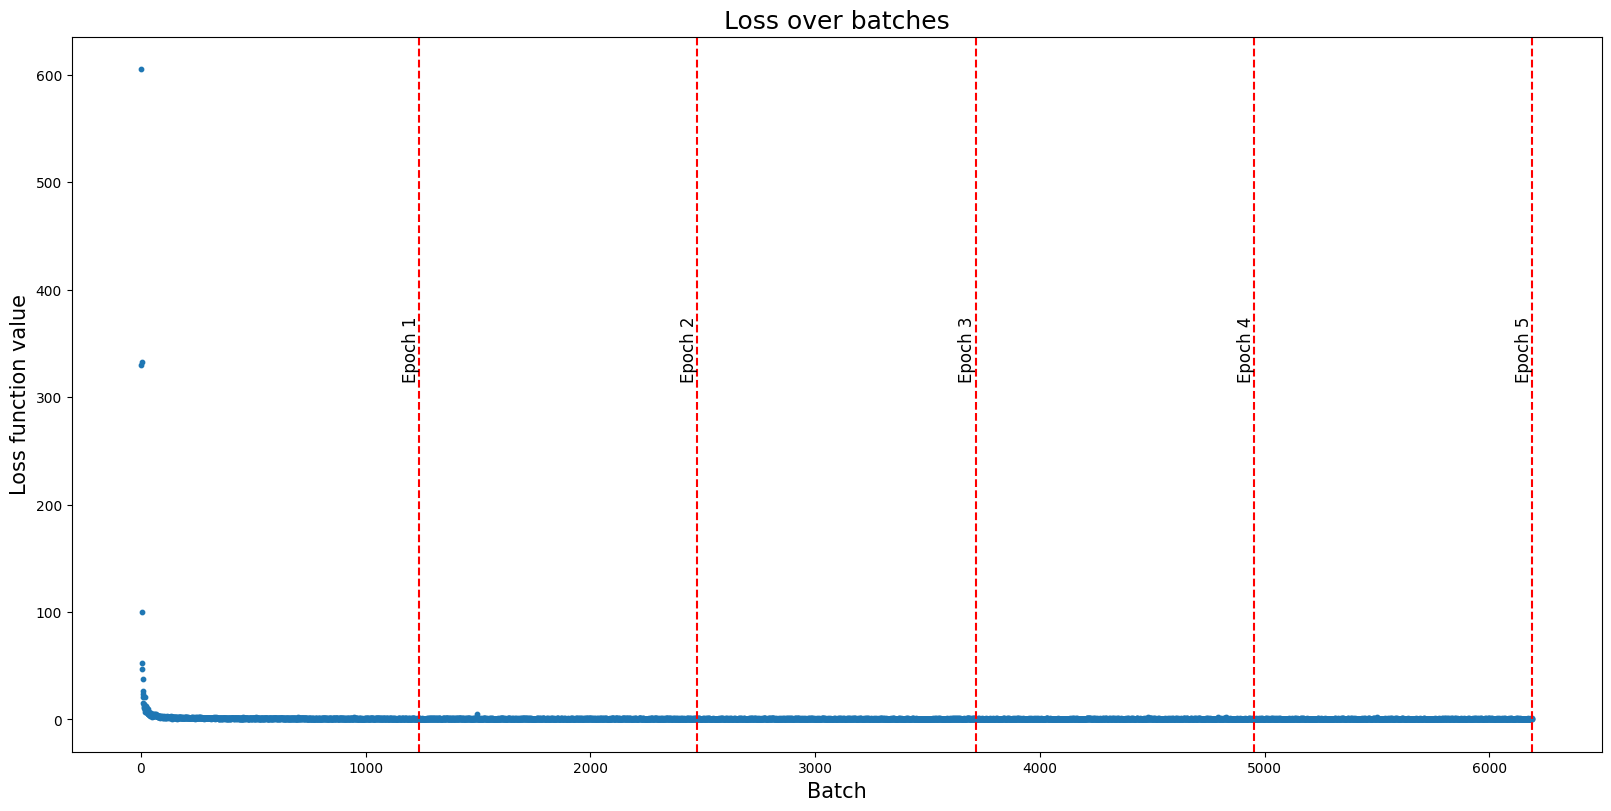

In [58]:
lr = 0.001
for optimizer_class in optimizers:
    print(f"Optimizer class: {optimizer_class}:")
    cnn_three_layer = ConvThreeLayerNN()
    optimizer = optimizer_class(cnn_three_layer.parameters(), lr=lr)
    train_NN(train_loader, val_loader, cnn_three_layer, loss_function, optimizer, 5, False, True)
    print("\n")

**Adam optimizer** is the best option.

Now let's experiment with the optimizer hyperparameter, specifically the `learning rate`, and observe how the **CNN**'s validation accuracy changes as we decrease this hyperparameter.

In [59]:
lrs = [0.005, 0.002, 0.001, 0.0008]
for lr in lrs:
    print(f"Learning rate: {lr:.4f}:")
    cnn_three_layer = ConvThreeLayerNN()
    optimizer = torch.optim.Adam(cnn_three_layer.parameters(), lr=lr)
    train_NN(train_loader, val_loader, cnn_three_layer, loss_function, optimizer, 5, False, False)
    print("\n")

Learning rate: 0.0050:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:17<01:09, 17.40s/it]

Train loss: 2.016, Validation loss: 0.982, Accuraccy: 0.665
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:35<00:52, 17.65s/it]

Train loss: 0.950, Validation loss: 0.944, Accuraccy: 0.658
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:53<00:35, 17.93s/it]

Train loss: 0.911, Validation loss: 0.834, Accuraccy: 0.694
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [01:11<00:18, 18.01s/it]

Train loss: 0.802, Validation loss: 0.779, Accuraccy: 0.712
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [01:30<00:00, 18.12s/it]


Train loss: 0.760, Validation loss: 0.766, Accuraccy: 0.724


Learning rate: 0.0020:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:20<01:22, 20.71s/it]

Train loss: 3.183, Validation loss: 0.815, Accuraccy: 0.718
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:38<00:57, 19.18s/it]

Train loss: 0.752, Validation loss: 0.736, Accuraccy: 0.742
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:56<00:36, 18.39s/it]

Train loss: 0.697, Validation loss: 0.681, Accuraccy: 0.763
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [01:13<00:18, 18.12s/it]

Train loss: 0.678, Validation loss: 0.707, Accuraccy: 0.743
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [01:32<00:00, 18.51s/it]


Train loss: 0.644, Validation loss: 0.671, Accuraccy: 0.743


Learning rate: 0.0010:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:20<01:21, 20.38s/it]

Train loss: 3.764, Validation loss: 0.806, Accuraccy: 0.727
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:39<00:59, 19.82s/it]

Train loss: 0.693, Validation loss: 0.671, Accuraccy: 0.765
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:57<00:37, 18.73s/it]

Train loss: 0.606, Validation loss: 0.626, Accuraccy: 0.788
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [01:18<00:19, 19.53s/it]

Train loss: 0.566, Validation loss: 0.583, Accuraccy: 0.794
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [01:37<00:00, 19.49s/it]


Train loss: 0.545, Validation loss: 0.556, Accuraccy: 0.805


Learning rate: 0.0008:


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch number 1:


 20%|█████████                                    | 1/5 [00:17<01:10, 17.72s/it]

Train loss: 4.997, Validation loss: 0.937, Accuraccy: 0.682
Epoch number 2:


 40%|██████████████████                           | 2/5 [00:36<00:55, 18.50s/it]

Train loss: 0.766, Validation loss: 0.725, Accuraccy: 0.740
Epoch number 3:


 60%|███████████████████████████                  | 3/5 [00:55<00:37, 18.53s/it]

Train loss: 0.628, Validation loss: 0.606, Accuraccy: 0.782
Epoch number 4:


 80%|████████████████████████████████████         | 4/5 [01:13<00:18, 18.41s/it]

Train loss: 0.570, Validation loss: 0.591, Accuraccy: 0.788
Epoch number 5:


100%|█████████████████████████████████████████████| 5/5 [01:34<00:00, 18.93s/it]

Train loss: 0.544, Validation loss: 0.572, Accuraccy: 0.796




It appears that a learning rate of **0.001** has yielded the best results once again.

Now let's check how `data standardization` affects the accuracy of the models.

  0%|                                                     | 0/7 [00:00<?, ?it/s]

Epoch number 1:


 14%|██████▍                                      | 1/7 [00:19<01:58, 19.78s/it]

Train loss: 0.699, Validation loss: 0.518, Accuraccy: 0.819
Epoch number 2:


 29%|████████████▊                                | 2/7 [00:40<01:42, 20.56s/it]

Train loss: 0.476, Validation loss: 0.460, Accuraccy: 0.843
Epoch number 3:


 43%|███████████████████▎                         | 3/7 [01:01<01:21, 20.49s/it]

Train loss: 0.424, Validation loss: 0.434, Accuraccy: 0.849
Epoch number 4:


 57%|█████████████████████████▋                   | 4/7 [01:23<01:03, 21.04s/it]

Train loss: 0.388, Validation loss: 0.425, Accuraccy: 0.852
Epoch number 5:


 71%|████████████████████████████████▏            | 5/7 [01:42<00:40, 20.46s/it]

Train loss: 0.366, Validation loss: 0.418, Accuraccy: 0.855
Epoch number 6:


 86%|██████████████████████████████████████▌      | 6/7 [02:00<00:19, 19.52s/it]

Train loss: 0.347, Validation loss: 0.405, Accuraccy: 0.862
Epoch number 7:


100%|█████████████████████████████████████████████| 7/7 [02:19<00:00, 19.86s/it]

Train loss: 0.334, Validation loss: 0.409, Accuraccy: 0.856


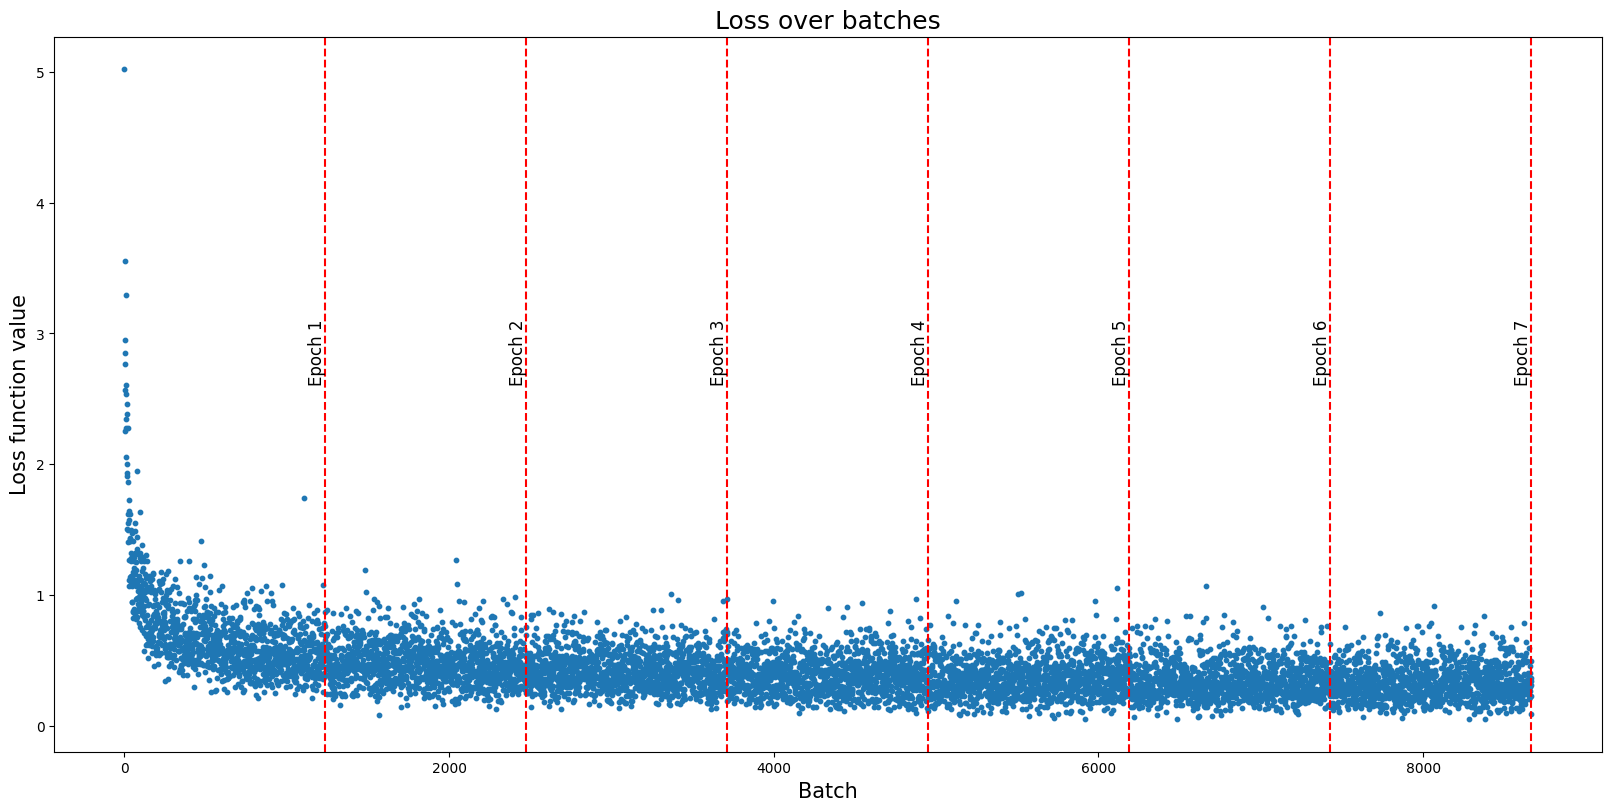

In [60]:
cnn_three_layer = ConvThreeLayerNN()
optimizer = torch.optim.Adam(cnn_three_layer.parameters())
train_NN(train_scaled_loader, val_scaled_loader, cnn_three_layer, loss_function, optimizer, 7, False, True)

Unlike the **FNN**, `data standardization` has had an impact on the accuracy of the **CNN**, noticeably improving its performance. We have achieved the best result so far among all the neural networks.

Now let's try to create a more `complex convolutional neural` network with an additional `fully-connected layer` at the end.</br>
Next network will consist of multiple convolutional layers with pooling layers in between, followed by fully connected layer. It is a relatively deep **CNN** architecture suitable for `image classification tasks`, capable of learning complex non-linear mappings between input features and output classes. </br>
From now on, we will only use the **Adam optimizer**.</br>
We will train this model first on the `raw data` and then on the `standardized data`.

In [61]:
class ConvForwNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 1)
        self.conv3 = nn.Conv2d(32, 16, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 32)
        self.fco = nn.Linear(32, 10)
        
        
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.zeros_(self.conv3.bias)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_normal_(self.fco.weight)
        nn.init.zeros_(self.fco.bias)

    def forward(self, x):
        x = F.relu(self.conv1(x.to(self.conv1.weight.dtype)))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.fco(x)
        return x
    
    def predict_proba(self, x):
        with torch.no_grad():
            pred = self.forward(x)
            probabilities = F.softmax(pred, dim=1)
        return probabilities

    def predict(self, x):
        probabilities = self.predict_proba(x)
        with torch.no_grad():
            max_probabilities, predicted_classes = torch.max(probabilities, dim=1)
        return predicted_classes

In [62]:
cnn_forw = ConvForwNN()
print(cnn_forw)
num_params = 0
for name, parameter in cnn_forw.named_parameters():
    print(f"{name}\nNumber: {parameter.numel()}\n")
    num_params += parameter.numel()
    
print(f"Total number of parameters: {num_params}")

ConvForwNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fco): Linear(in_features=32, out_features=10, bias=True)
)
conv1.weight
Number: 800

conv1.bias
Number: 32

conv2.weight
Number: 9216

conv2.bias
Number: 32

conv3.weight
Number: 2048

conv3.bias
Number: 16

fc1.weight
Number: 12800

fc1.bias
Number: 32

fco.weight
Number: 320

fco.bias
Number: 10

Total number of parameters: 25306


  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:
  Batch 300 loss: 1.754
  Batch 600 loss: 1.418
  Batch 900 loss: 1.444
  Batch 1200 loss: 1.403
  Batch 1238 loss: 1.161


 10%|████▍                                       | 1/10 [00:26<04:01, 26.86s/it]

Train loss: 3.801, Validation loss: 1.322, Accuraccy: 0.488
Epoch number 2:
  Batch 300 loss: 1.056
  Batch 600 loss: 1.009
  Batch 900 loss: 1.343
  Batch 1200 loss: 0.886
  Batch 1238 loss: 0.909


 20%|████████▊                                   | 2/10 [00:49<03:15, 24.45s/it]

Train loss: 1.160, Validation loss: 1.035, Accuraccy: 0.599
Epoch number 3:
  Batch 300 loss: 0.743
  Batch 600 loss: 1.048
  Batch 900 loss: 0.693
  Batch 1200 loss: 0.540
  Batch 1238 loss: 0.571


 30%|█████████████▏                              | 3/10 [01:11<02:41, 23.05s/it]

Train loss: 0.917, Validation loss: 0.796, Accuraccy: 0.709
Epoch number 4:
  Batch 300 loss: 0.579
  Batch 600 loss: 0.520
  Batch 900 loss: 0.638
  Batch 1200 loss: 0.497
  Batch 1238 loss: 0.701


 40%|█████████████████▌                          | 4/10 [01:36<02:24, 24.05s/it]

Train loss: 0.720, Validation loss: 0.691, Accuraccy: 0.753
Epoch number 5:
  Batch 300 loss: 0.501
  Batch 600 loss: 0.641
  Batch 900 loss: 0.385
  Batch 1200 loss: 0.774
  Batch 1238 loss: 0.724


 50%|██████████████████████                      | 5/10 [02:00<02:00, 24.01s/it]

Train loss: 0.621, Validation loss: 0.620, Accuraccy: 0.780
Epoch number 6:
  Batch 300 loss: 0.562
  Batch 600 loss: 0.602
  Batch 900 loss: 0.521
  Batch 1200 loss: 0.526
  Batch 1238 loss: 0.719


 60%|██████████████████████████▍                 | 6/10 [02:25<01:37, 24.40s/it]

Train loss: 0.557, Validation loss: 0.594, Accuraccy: 0.776
Epoch number 7:
  Batch 300 loss: 0.467
  Batch 600 loss: 0.288
  Batch 900 loss: 0.414
  Batch 1200 loss: 0.466
  Batch 1238 loss: 0.247


 70%|██████████████████████████████▊             | 7/10 [02:50<01:13, 24.49s/it]

Train loss: 0.527, Validation loss: 0.520, Accuraccy: 0.815
Epoch number 8:
  Batch 300 loss: 0.417
  Batch 600 loss: 0.832
  Batch 900 loss: 0.392
  Batch 1200 loss: 0.353
  Batch 1238 loss: 0.412


 80%|███████████████████████████████████▏        | 8/10 [03:13<00:48, 24.18s/it]

Train loss: 0.489, Validation loss: 0.491, Accuraccy: 0.824
Epoch number 9:
  Batch 300 loss: 0.562
  Batch 600 loss: 0.368
  Batch 900 loss: 0.543
  Batch 1200 loss: 0.376
  Batch 1238 loss: 0.483


 90%|███████████████████████████████████████▌    | 9/10 [03:36<00:23, 23.71s/it]

Train loss: 0.461, Validation loss: 0.482, Accuraccy: 0.838
Epoch number 10:
  Batch 300 loss: 0.326
  Batch 600 loss: 0.237
  Batch 900 loss: 0.399
  Batch 1200 loss: 0.287
  Batch 1238 loss: 0.338


100%|███████████████████████████████████████████| 10/10 [03:59<00:00, 23.94s/it]

Train loss: 0.437, Validation loss: 0.465, Accuraccy: 0.844


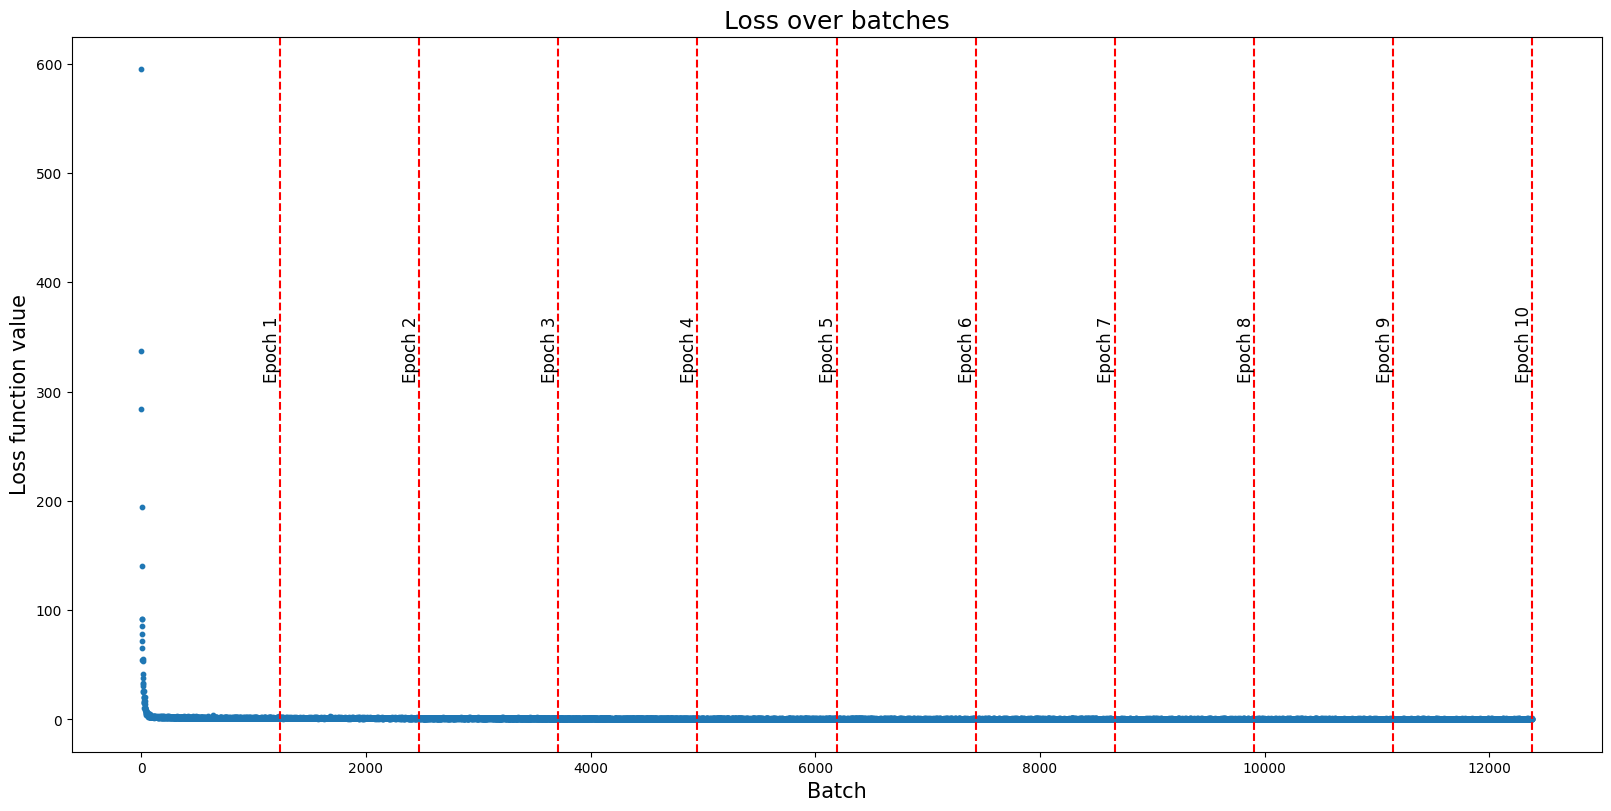

In [63]:
optimizer = torch.optim.Adam(cnn_forw.parameters())
train_NN(train_loader, val_loader, cnn_forw, loss_function, optimizer, 10, True, True)

  0%|                                                     | 0/7 [00:00<?, ?it/s]

Epoch number 1:


 14%|██████▍                                      | 1/7 [00:25<02:30, 25.03s/it]

Train loss: 0.646, Validation loss: 0.490, Accuraccy: 0.821
Epoch number 2:


 29%|████████████▊                                | 2/7 [00:49<02:03, 24.69s/it]

Train loss: 0.438, Validation loss: 0.420, Accuraccy: 0.849
Epoch number 3:


 43%|███████████████████▎                         | 3/7 [01:12<01:34, 23.72s/it]

Train loss: 0.384, Validation loss: 0.434, Accuraccy: 0.846
Epoch number 4:


 57%|█████████████████████████▋                   | 4/7 [01:36<01:12, 24.11s/it]

Train loss: 0.349, Validation loss: 0.395, Accuraccy: 0.853
Epoch number 5:


 71%|████████████████████████████████▏            | 5/7 [01:59<00:47, 23.64s/it]

Train loss: 0.323, Validation loss: 0.375, Accuraccy: 0.867
Epoch number 6:


 86%|██████████████████████████████████████▌      | 6/7 [02:22<00:23, 23.48s/it]

Train loss: 0.302, Validation loss: 0.364, Accuraccy: 0.866
Epoch number 7:


100%|█████████████████████████████████████████████| 7/7 [02:45<00:00, 23.61s/it]

Train loss: 0.290, Validation loss: 0.371, Accuraccy: 0.867


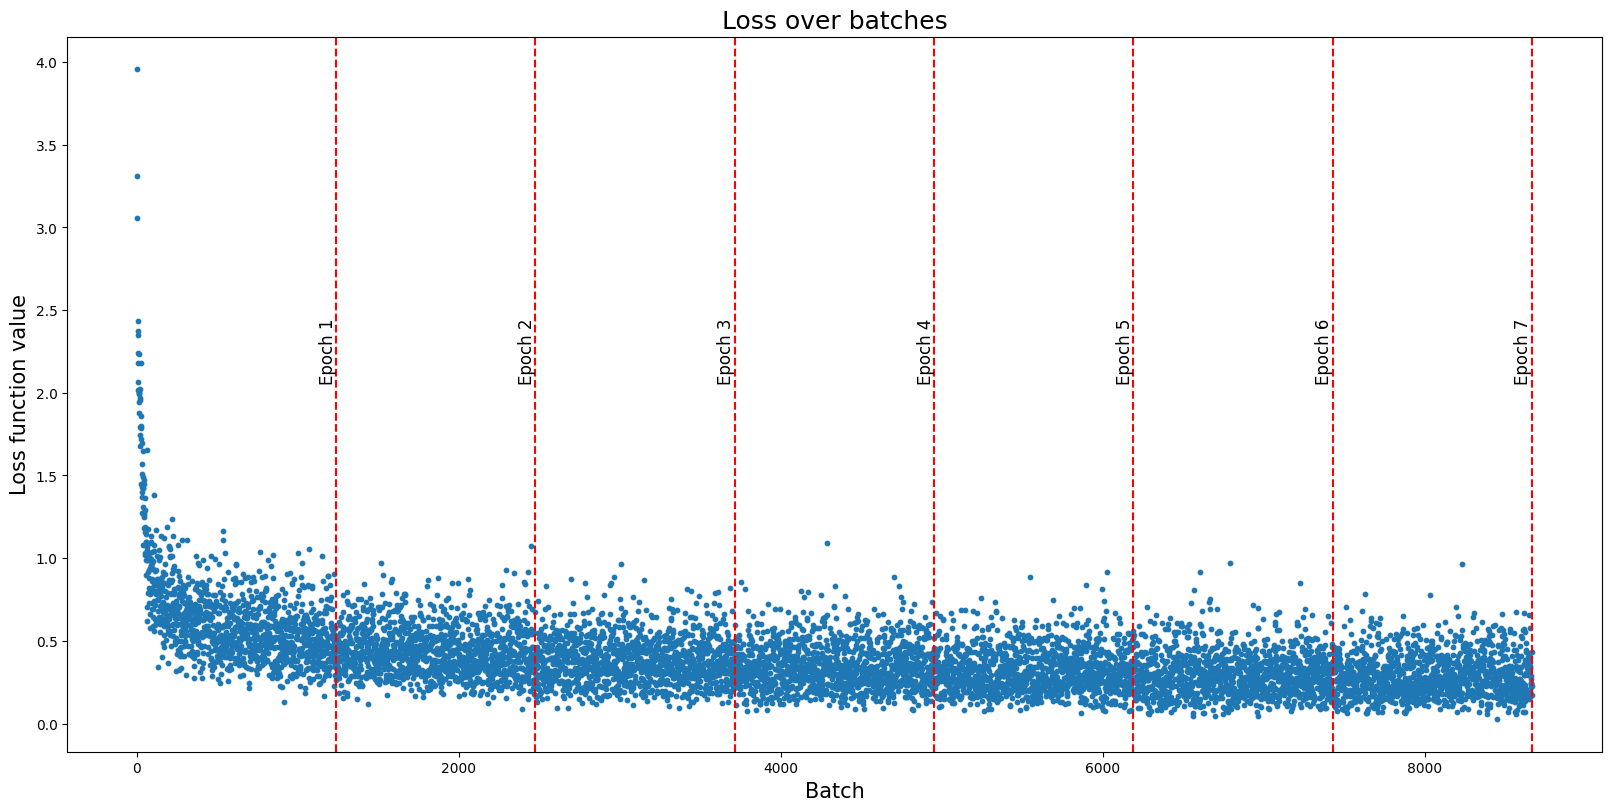

In [64]:
cnn_forw = ConvForwNN()
optimizer = torch.optim.Adam(cnn_forw.parameters())
train_NN(train_scaled_loader, val_scaled_loader, cnn_forw, loss_function, optimizer, 7, False, True)

This model achieved the `highest accuracy` on the validation data when trained on `standardized data`, although the improvement in accuracy is not significantly different from the previous best result.

Let's create another neural network with the same structure as the previous one, but with the addition of `padding` in some layers. We'll see if this has any impact on the accuracy.

In [65]:
class ConvForwNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, padding = 1)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(32, 32, 3, padding = 1)
        self.pool2 = nn.MaxPool2d(2, 1)
        self.conv3 = nn.Conv2d(32, 16, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*6*6, 32)
        self.fco = nn.Linear(32, 10)
        
        
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.zeros_(self.conv3.bias)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_normal_(self.fco.weight)
        nn.init.zeros_(self.fco.bias)

    def forward(self, x):
        x = F.relu(self.conv1(x.to(self.conv1.weight.dtype)))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.fco(x)
        return x
    
    def predict_proba(self, x):
        with torch.no_grad():
            pred = self.forward(x)
            probabilities = F.softmax(pred, dim=1)
        return probabilities

    def predict(self, x):
        probabilities = self.predict_proba(x)
        with torch.no_grad():
            max_probabilities, predicted_classes = torch.max(probabilities, dim=1)
        return predicted_classes

In [66]:
cnn_forw2 = ConvForwNN2()
print(cnn_forw2)
num_params = 0
for name, parameter in cnn_forw2.named_parameters():
    print(f"{name}\nNumber: {parameter.numel()}\n")
    num_params += parameter.numel()
    
print(f"Total number of parameters: {num_params}")

ConvForwNN2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=32, bias=True)
  (fco): Linear(in_features=32, out_features=10, bias=True)
)
conv1.weight
Number: 800

conv1.bias
Number: 32

conv2.weight
Number: 9216

conv2.bias
Number: 32

conv3.weight
Number: 4608

conv3.bias
Number: 16

fc1.weight
Number: 18432

fc1.bias
Number: 32

fco.weight
Number: 320

fco.bias
Number: 10

Total number of parameters: 33498


  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:
  Batch 300 loss: 1.894
  Batch 600 loss: 1.557
  Batch 900 loss: 1.295
  Batch 1200 loss: 1.302
  Batch 1238 loss: 0.877


 10%|████▍                                       | 1/10 [00:30<04:35, 30.56s/it]

Train loss: 2.437, Validation loss: 1.138, Accuraccy: 0.636
Epoch number 2:
  Batch 300 loss: 0.924
  Batch 600 loss: 0.995
  Batch 900 loss: 0.479
  Batch 1200 loss: 0.868
  Batch 1238 loss: 1.053


 20%|████████▊                                   | 2/10 [01:00<04:02, 30.28s/it]

Train loss: 0.983, Validation loss: 0.917, Accuraccy: 0.647
Epoch number 3:
  Batch 300 loss: 1.051
  Batch 600 loss: 0.418
  Batch 900 loss: 0.669
  Batch 1200 loss: 1.070
  Batch 1238 loss: 0.539


 30%|█████████████▏                              | 3/10 [01:36<03:50, 32.95s/it]

Train loss: 0.798, Validation loss: 0.733, Accuraccy: 0.728
Epoch number 4:
  Batch 300 loss: 0.952
  Batch 600 loss: 0.475
  Batch 900 loss: 0.584
  Batch 1200 loss: 0.670
  Batch 1238 loss: 0.523


 40%|█████████████████▌                          | 4/10 [02:05<03:07, 31.31s/it]

Train loss: 0.663, Validation loss: 0.660, Accuraccy: 0.746
Epoch number 5:
  Batch 300 loss: 0.690
  Batch 600 loss: 0.507
  Batch 900 loss: 0.543
  Batch 1200 loss: 0.718
  Batch 1238 loss: 0.544


 50%|██████████████████████                      | 5/10 [02:35<02:34, 30.90s/it]

Train loss: 0.595, Validation loss: 0.595, Accuraccy: 0.773
Epoch number 6:
  Batch 300 loss: 0.548
  Batch 600 loss: 0.293
  Batch 900 loss: 0.402
  Batch 1200 loss: 0.338
  Batch 1238 loss: 0.484


 60%|██████████████████████████▍                 | 6/10 [03:06<02:03, 30.93s/it]

Train loss: 0.547, Validation loss: 0.567, Accuraccy: 0.784
Epoch number 7:
  Batch 300 loss: 0.778
  Batch 600 loss: 0.572
  Batch 900 loss: 0.627
  Batch 1200 loss: 0.445
  Batch 1238 loss: 0.625


 70%|██████████████████████████████▊             | 7/10 [03:35<01:30, 30.16s/it]

Train loss: 0.512, Validation loss: 0.542, Accuraccy: 0.796
Epoch number 8:
  Batch 300 loss: 0.517
  Batch 600 loss: 0.436
  Batch 900 loss: 0.404
  Batch 1200 loss: 0.622
  Batch 1238 loss: 0.251


 80%|███████████████████████████████████▏        | 8/10 [04:03<00:59, 29.55s/it]

Train loss: 0.478, Validation loss: 0.507, Accuraccy: 0.805
Epoch number 9:
  Batch 300 loss: 0.459
  Batch 600 loss: 0.390
  Batch 900 loss: 0.542
  Batch 1200 loss: 0.291
  Batch 1238 loss: 0.183


 90%|███████████████████████████████████████▌    | 9/10 [04:33<00:29, 29.74s/it]

Train loss: 0.446, Validation loss: 0.492, Accuraccy: 0.828
Epoch number 10:
  Batch 300 loss: 0.353
  Batch 600 loss: 0.417
  Batch 900 loss: 0.313
  Batch 1200 loss: 0.586
  Batch 1238 loss: 0.238


100%|███████████████████████████████████████████| 10/10 [05:03<00:00, 30.30s/it]

Train loss: 0.414, Validation loss: 0.483, Accuraccy: 0.823


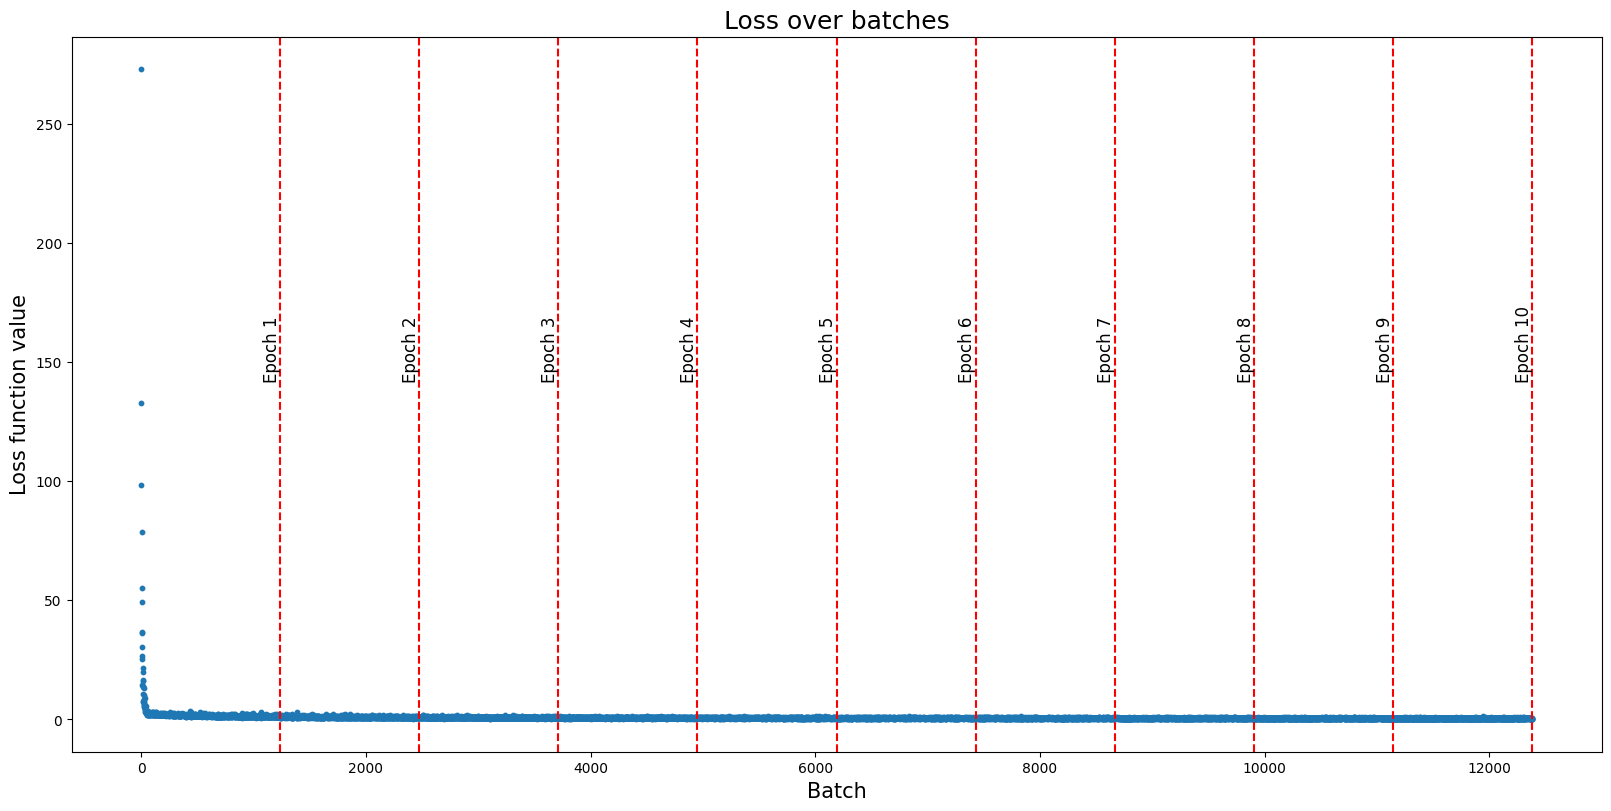

In [67]:
optimizer = torch.optim.Adam(cnn_forw2.parameters())
train_NN(train_loader, val_loader, cnn_forw2, loss_function, optimizer, 10, True, True)

  0%|                                                     | 0/7 [00:00<?, ?it/s]

Epoch number 1:


 14%|██████▍                                      | 1/7 [00:30<03:01, 30.33s/it]

Train loss: 0.670, Validation loss: 0.500, Accuraccy: 0.823
Epoch number 2:


 29%|████████████▊                                | 2/7 [00:58<02:25, 29.17s/it]

Train loss: 0.435, Validation loss: 0.423, Accuraccy: 0.851
Epoch number 3:


 43%|███████████████████▎                         | 3/7 [01:28<01:58, 29.63s/it]

Train loss: 0.375, Validation loss: 0.414, Accuraccy: 0.852
Epoch number 4:


 57%|█████████████████████████▋                   | 4/7 [01:57<01:27, 29.28s/it]

Train loss: 0.341, Validation loss: 0.372, Accuraccy: 0.867
Epoch number 5:


 71%|████████████████████████████████▏            | 5/7 [02:27<00:59, 29.55s/it]

Train loss: 0.313, Validation loss: 0.375, Accuraccy: 0.864
Epoch number 6:


 86%|██████████████████████████████████████▌      | 6/7 [02:55<00:28, 28.82s/it]

Train loss: 0.294, Validation loss: 0.349, Accuraccy: 0.876
Epoch number 7:


100%|█████████████████████████████████████████████| 7/7 [03:25<00:00, 29.41s/it]

Train loss: 0.275, Validation loss: 0.367, Accuraccy: 0.875


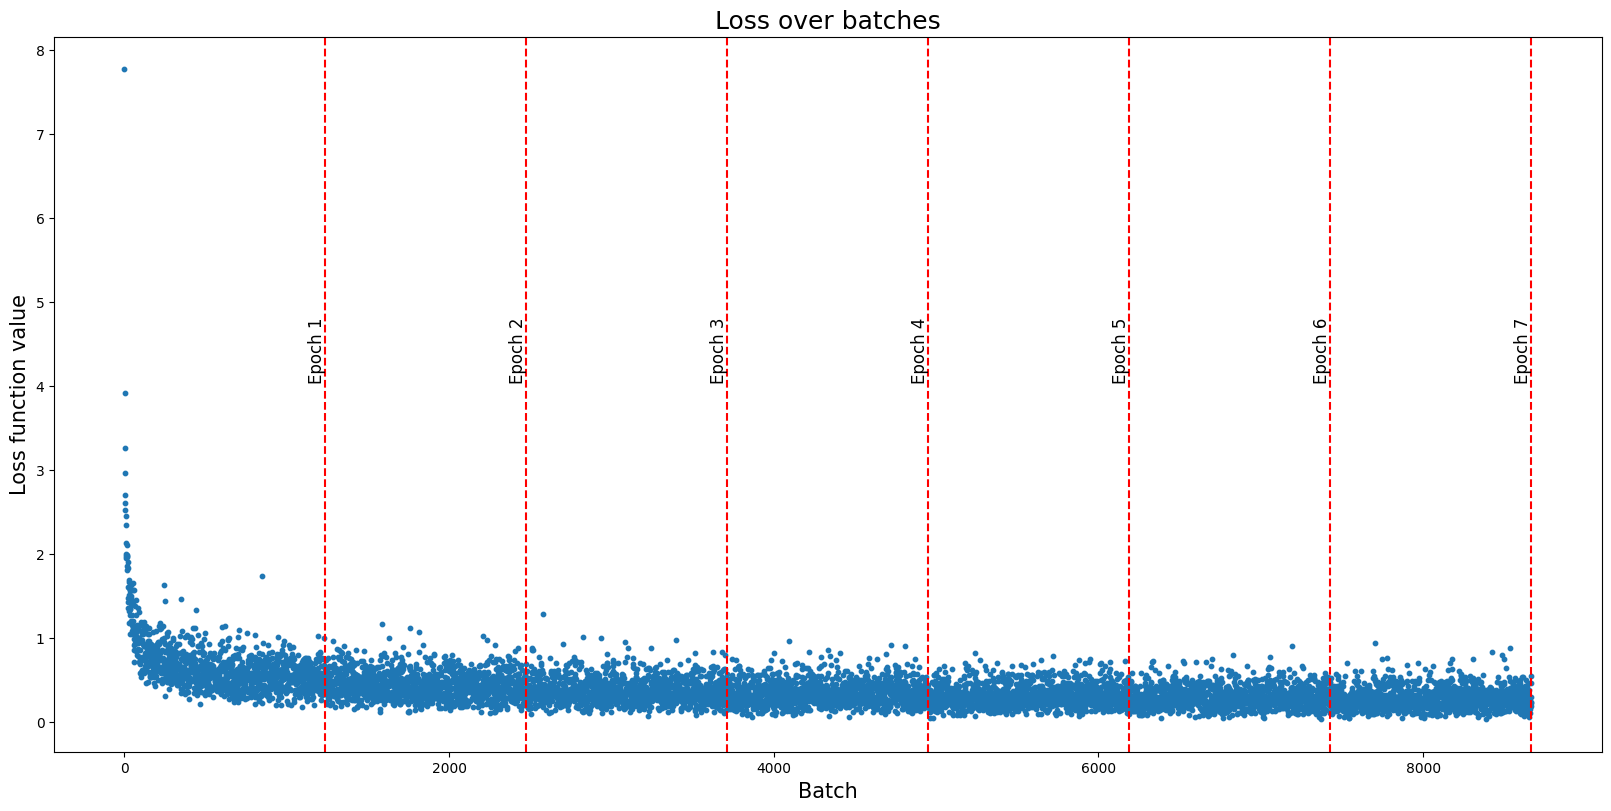

In [68]:
cnn_forw2 = ConvForwNN2()
optimizer = torch.optim.Adam(cnn_forw2.parameters())
train_NN(train_scaled_loader, val_scaled_loader, cnn_forw2, loss_function, optimizer, 7, False, True)

This change allowed us to further `improve the accuracy`, which is definitely a positive outcome. Now let's move on `regularization techniques` to make our networks better.

#### Regularization techniques

At the beginning, we will `fulfill the promise` we made at the beginning of the project - to improve our **train_NN()** function a bit. We will add `early stopping` and the ability to activate `L1 regularization` on the last layer (fco).

In [69]:
def train_one_epoch2(train_loader, nn_model, loss_function, optimizer, losses, print_info = True, l1_reg = False, l1_alpha = 0.001):
    running_cum_loss = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = nn_model(inputs)
        
        loss = loss_function(outputs, labels)
        if l1_reg:
            penalty = torch.tensor(0.)
            penalty += torch.linalg.vector_norm(nn_model.fco.weight.flatten(),1)
            loss = loss + l1_alpha * penalty
        loss.backward()

        optimizer.step()

        last_mean_loss = loss.item()
        losses.append(last_mean_loss)
        running_cum_loss += last_mean_loss
        if print_info and (i % 300 == 299 or i == len(train_loader) - 1):
            print(f"  Batch {i+1} loss: {last_mean_loss:.3f}")
            
    return running_cum_loss / len(train_loader)


def train_NN2(train_loader, val_loader, nn_model, loss_function, optimizer, number_of_epochs, print_info = True, show_graph = True, l1_reg = False, l1_alpha = 0.001):
    max_epochs_from_best = 4
    losses = []
    best_val_accuracy = 0
    epochs_from_best = 0
    last_epoch = 0
    for i in tqdm(range(number_of_epochs)):
        print(f"Epoch number {i+1}:")
        
        nn_model.train(True)
        train_loss = train_one_epoch2(train_loader, nn_model, loss_function, optimizer, losses, print_info, l1_reg, l1_alpha)
        nn_model.train(False)
        
        running_cum_val_loss = 0.0
        val_cum_accuracy = 0.0
        val_data_amount = 0
        for val_data in val_loader:
            val_inputs, val_labels = val_data

            with torch.no_grad():
                val_outputs = nn_model(val_inputs)
                val_loss = loss_function(val_outputs, val_labels)
                val_predicted = nn_model.predict(val_inputs)
                val_accuracy = metrics.accuracy_score(val_labels.numpy(), val_predicted.numpy())
            val_data_amount += val_inputs.shape[0]
            running_cum_val_loss += val_loss * val_inputs.shape[0]
            val_cum_accuracy += val_accuracy * val_inputs.shape[0]
        
        avg_val_loss = running_cum_val_loss / val_data_amount
        avg_val_accuracy = val_cum_accuracy / val_data_amount
        last_epoch += 1
        print(f"Train loss: {train_loss:.3f}, Validation loss: {avg_val_loss:.3f}, Accuraccy: {avg_val_accuracy:.3f}")
          
        if avg_val_accuracy > best_val_accuracy:
            print("Saving best neural network.")
            best_val_accuracy = avg_val_accuracy
            nn_model_path = "saves/best_model.pt"
            torch.save(nn_model.state_dict(), nn_model_path)
            epochs_from_best = 0
        else:
            print("No improvement in this epoch.")
            epochs_from_best += 1
            
        if epochs_from_best > max_epochs_from_best:
            print("Early stopping now.")
            break
        
    if show_graph:
        draw_losses_graph(losses, last_epoch)

Now we will activate `L1 regularization` on a `simple two-layer neural network` and see how it affects the accuracy.

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:


 10%|████▍                                       | 1/10 [00:06<01:01,  6.88s/it]

Train loss: 4111.682, Validation loss: 2198.903, Accuraccy: 0.666
Saving best neural network.
Epoch number 2:


 20%|████████▊                                   | 2/10 [00:13<00:53,  6.74s/it]

Train loss: 1731.656, Validation loss: 1672.678, Accuraccy: 0.696
Saving best neural network.
Epoch number 3:


 30%|█████████████▏                              | 3/10 [00:18<00:42,  6.11s/it]

Train loss: 1313.082, Validation loss: 1369.975, Accuraccy: 0.708
Saving best neural network.
Epoch number 4:


 40%|█████████████████▌                          | 4/10 [00:23<00:34,  5.68s/it]

Train loss: 1072.642, Validation loss: 1393.439, Accuraccy: 0.699
No improvement in this epoch.
Epoch number 5:


 50%|██████████████████████                      | 5/10 [00:28<00:26,  5.39s/it]

Train loss: 906.429, Validation loss: 1027.068, Accuraccy: 0.749
Saving best neural network.
Epoch number 6:


 60%|██████████████████████████▍                 | 6/10 [00:34<00:21,  5.35s/it]

Train loss: 781.353, Validation loss: 1016.495, Accuraccy: 0.726
No improvement in this epoch.
Epoch number 7:


 70%|██████████████████████████████▊             | 7/10 [00:39<00:16,  5.41s/it]

Train loss: 686.773, Validation loss: 1049.367, Accuraccy: 0.720
No improvement in this epoch.
Epoch number 8:


 80%|███████████████████████████████████▏        | 8/10 [00:44<00:10,  5.38s/it]

Train loss: 608.830, Validation loss: 941.090, Accuraccy: 0.750
Saving best neural network.
Epoch number 9:


 90%|███████████████████████████████████████▌    | 9/10 [00:50<00:05,  5.47s/it]

Train loss: 547.925, Validation loss: 792.195, Accuraccy: 0.762
Saving best neural network.
Epoch number 10:


100%|███████████████████████████████████████████| 10/10 [00:55<00:00,  5.60s/it]

Train loss: 493.818, Validation loss: 835.519, Accuraccy: 0.741
No improvement in this epoch.


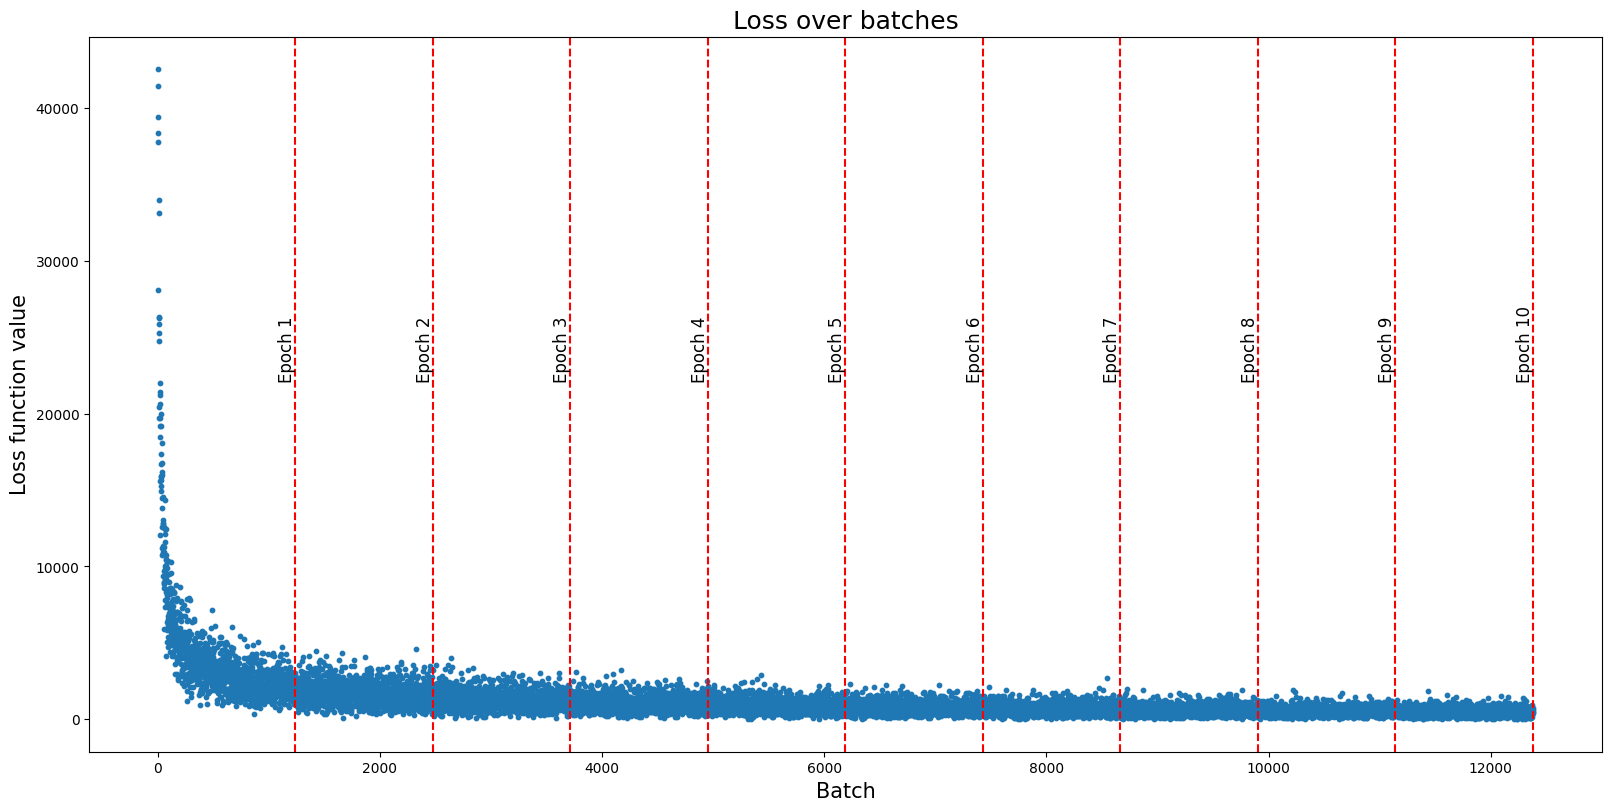

In [70]:
fnn_two_layer = TwoLayerNN(256)
optimizer = torch.optim.Adam(fnn_two_layer.parameters())
train_NN2(train_loader, val_loader, fnn_two_layer, loss_function, optimizer, 10, False, True, l1_reg = True)

As we can see, accuracies are similar. As for me, it is more interesting to use `L2 regularization`. Let's apply it on all our models (on raw and standardised data) and follow changes in accuracies.

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:


 10%|████▍                                       | 1/10 [00:06<00:59,  6.58s/it]

Train loss: 4027.084, Validation loss: 2269.028, Accuraccy: 0.683
Saving best neural network.
Epoch number 2:


 20%|████████▊                                   | 2/10 [00:12<00:47,  5.96s/it]

Train loss: 1867.788, Validation loss: 1762.421, Accuraccy: 0.715
Saving best neural network.
Epoch number 3:


 30%|█████████████▏                              | 3/10 [00:17<00:40,  5.86s/it]

Train loss: 1416.920, Validation loss: 1482.099, Accuraccy: 0.726
Saving best neural network.
Epoch number 4:


 40%|█████████████████▌                          | 4/10 [00:23<00:34,  5.76s/it]

Train loss: 1189.070, Validation loss: 1323.580, Accuraccy: 0.744
Saving best neural network.
Epoch number 5:


 50%|██████████████████████                      | 5/10 [00:29<00:28,  5.72s/it]

Train loss: 1004.931, Validation loss: 1233.409, Accuraccy: 0.740
No improvement in this epoch.
Epoch number 6:


 60%|██████████████████████████▍                 | 6/10 [00:35<00:23,  5.80s/it]

Train loss: 887.539, Validation loss: 1092.832, Accuraccy: 0.758
Saving best neural network.
Epoch number 7:


 70%|██████████████████████████████▊             | 7/10 [00:41<00:17,  5.85s/it]

Train loss: 772.477, Validation loss: 1059.924, Accuraccy: 0.744
No improvement in this epoch.
Epoch number 8:


 80%|███████████████████████████████████▏        | 8/10 [00:47<00:12,  6.11s/it]

Train loss: 697.946, Validation loss: 991.711, Accuraccy: 0.763
Saving best neural network.
Epoch number 9:


 90%|███████████████████████████████████████▌    | 9/10 [00:54<00:06,  6.22s/it]

Train loss: 625.857, Validation loss: 925.593, Accuraccy: 0.765
Saving best neural network.
Epoch number 10:


100%|███████████████████████████████████████████| 10/10 [01:02<00:00,  6.23s/it]

Train loss: 566.464, Validation loss: 898.002, Accuraccy: 0.767
Saving best neural network.


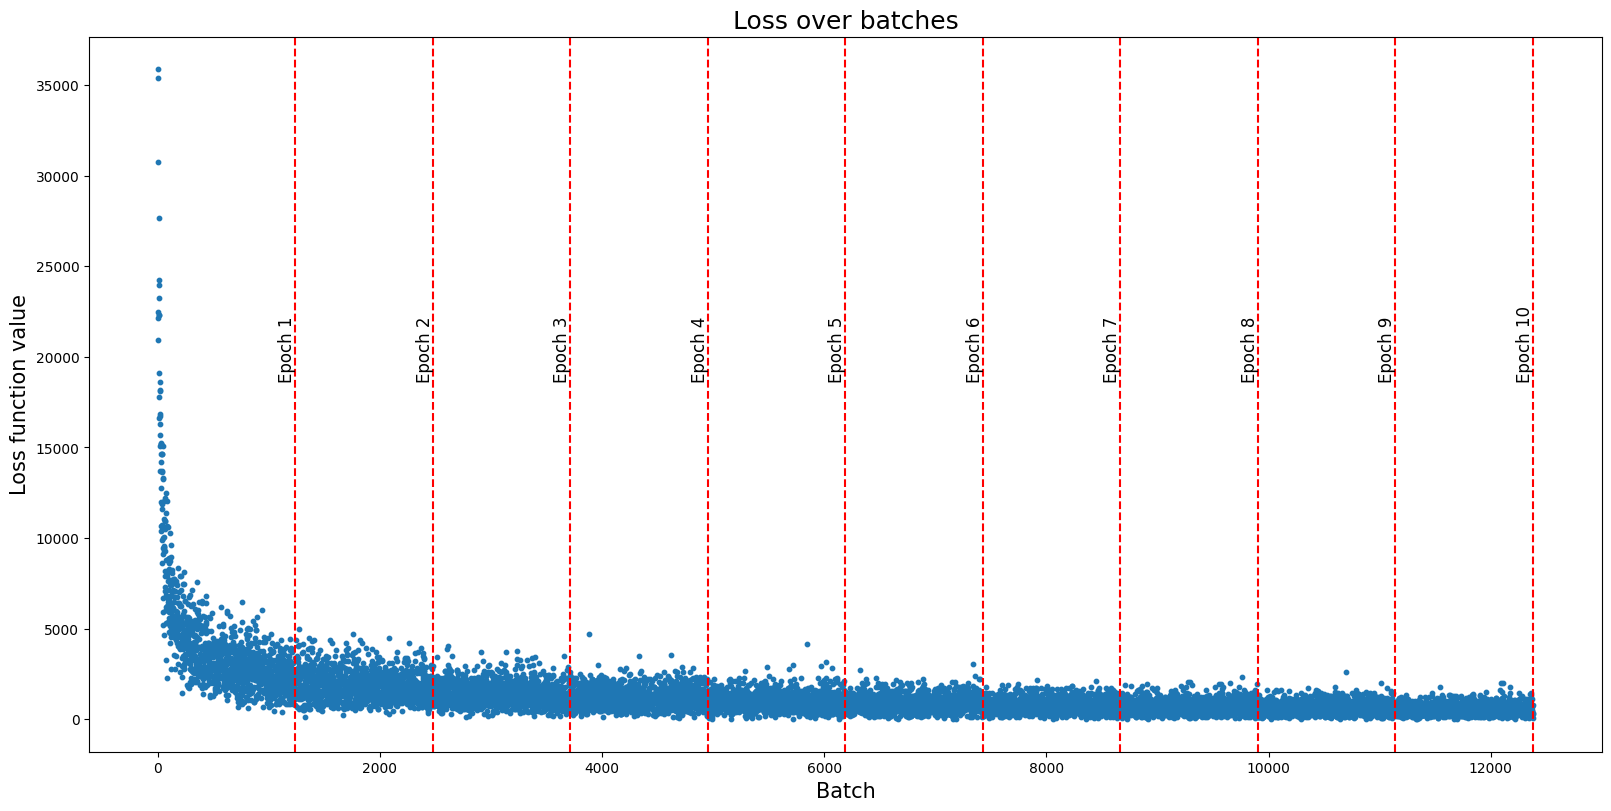

In [71]:
fnn_two_layer = TwoLayerNN(256)
optimizer = torch.optim.Adam(fnn_two_layer.parameters(), weight_decay=0.001)
train_NN2(train_loader, val_loader, fnn_two_layer, loss_function, optimizer, 10, False, True)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:


 10%|████▍                                       | 1/10 [00:07<01:03,  7.01s/it]

Train loss: 84.344, Validation loss: 49.486, Accuraccy: 0.686
Saving best neural network.
Epoch number 2:


 20%|████████▊                                   | 2/10 [00:14<00:56,  7.04s/it]

Train loss: 36.790, Validation loss: 36.920, Accuraccy: 0.720
Saving best neural network.
Epoch number 3:


 30%|█████████████▏                              | 3/10 [00:21<00:50,  7.17s/it]

Train loss: 25.961, Validation loss: 32.047, Accuraccy: 0.731
Saving best neural network.
Epoch number 4:


 40%|█████████████████▌                          | 4/10 [00:26<00:39,  6.52s/it]

Train loss: 20.432, Validation loss: 28.968, Accuraccy: 0.745
Saving best neural network.
Epoch number 5:


 50%|██████████████████████                      | 5/10 [00:32<00:31,  6.34s/it]

Train loss: 16.729, Validation loss: 26.262, Accuraccy: 0.754
Saving best neural network.
Epoch number 6:


 60%|██████████████████████████▍                 | 6/10 [00:39<00:25,  6.29s/it]

Train loss: 13.847, Validation loss: 24.306, Accuraccy: 0.748
No improvement in this epoch.
Epoch number 7:


 70%|██████████████████████████████▊             | 7/10 [00:45<00:18,  6.24s/it]

Train loss: 11.805, Validation loss: 22.271, Accuraccy: 0.756
Saving best neural network.
Epoch number 8:


 80%|███████████████████████████████████▏        | 8/10 [00:51<00:12,  6.22s/it]

Train loss: 10.007, Validation loss: 21.613, Accuraccy: 0.767
Saving best neural network.
Epoch number 9:


 90%|███████████████████████████████████████▌    | 9/10 [00:57<00:06,  6.17s/it]

Train loss: 8.875, Validation loss: 20.144, Accuraccy: 0.770
Saving best neural network.
Epoch number 10:


100%|███████████████████████████████████████████| 10/10 [01:03<00:00,  6.36s/it]

Train loss: 7.850, Validation loss: 19.343, Accuraccy: 0.765
No improvement in this epoch.


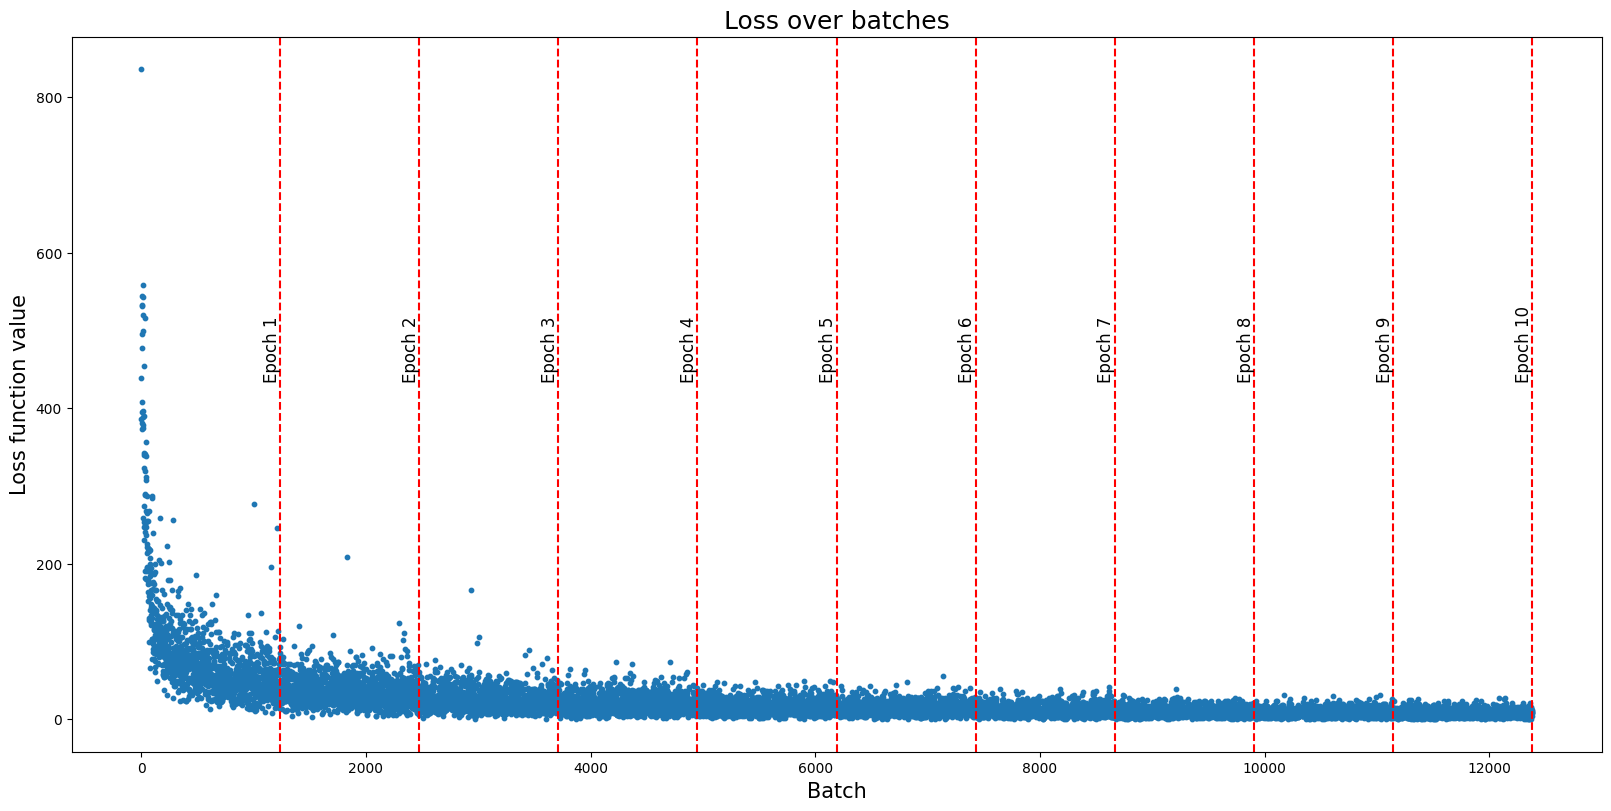

In [72]:
fnn_two_layer = TwoLayerNN(256)
optimizer = torch.optim.Adam(fnn_two_layer.parameters(), weight_decay=0.001)
train_NN2(train_scaled_loader, val_scaled_loader, fnn_two_layer, loss_function, optimizer, 10, False, True)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:


 10%|████▍                                       | 1/10 [00:03<00:34,  3.82s/it]

Train loss: 20252.356, Validation loss: 9755.939, Accuraccy: 0.663
Saving best neural network.
Epoch number 2:


 20%|████████▊                                   | 2/10 [00:07<00:30,  3.82s/it]

Train loss: 7593.475, Validation loss: 6499.698, Accuraccy: 0.688
Saving best neural network.
Epoch number 3:


 30%|█████████████▏                              | 3/10 [00:11<00:26,  3.81s/it]

Train loss: 5045.361, Validation loss: 4824.429, Accuraccy: 0.703
Saving best neural network.
Epoch number 4:


 40%|█████████████████▌                          | 4/10 [00:15<00:22,  3.74s/it]

Train loss: 3597.688, Validation loss: 3891.364, Accuraccy: 0.718
Saving best neural network.
Epoch number 5:


 50%|██████████████████████                      | 5/10 [00:19<00:19,  3.89s/it]

Train loss: 2734.746, Validation loss: 2902.603, Accuraccy: 0.741
Saving best neural network.
Epoch number 6:


 60%|██████████████████████████▍                 | 6/10 [00:23<00:15,  3.94s/it]

Train loss: 2075.437, Validation loss: 2315.791, Accuraccy: 0.737
No improvement in this epoch.
Epoch number 7:


 70%|██████████████████████████████▊             | 7/10 [00:27<00:11,  3.90s/it]

Train loss: 1630.424, Validation loss: 1963.879, Accuraccy: 0.732
No improvement in this epoch.
Epoch number 8:


 80%|███████████████████████████████████▏        | 8/10 [00:30<00:07,  3.81s/it]

Train loss: 1301.866, Validation loss: 2170.195, Accuraccy: 0.722
No improvement in this epoch.
Epoch number 9:


 90%|███████████████████████████████████████▌    | 9/10 [00:34<00:03,  3.75s/it]

Train loss: 1079.973, Validation loss: 1608.071, Accuraccy: 0.709
No improvement in this epoch.
Epoch number 10:


 90%|███████████████████████████████████████▌    | 9/10 [00:37<00:04,  4.22s/it]

Train loss: 864.215, Validation loss: 1423.071, Accuraccy: 0.736
No improvement in this epoch.
Early stopping now.


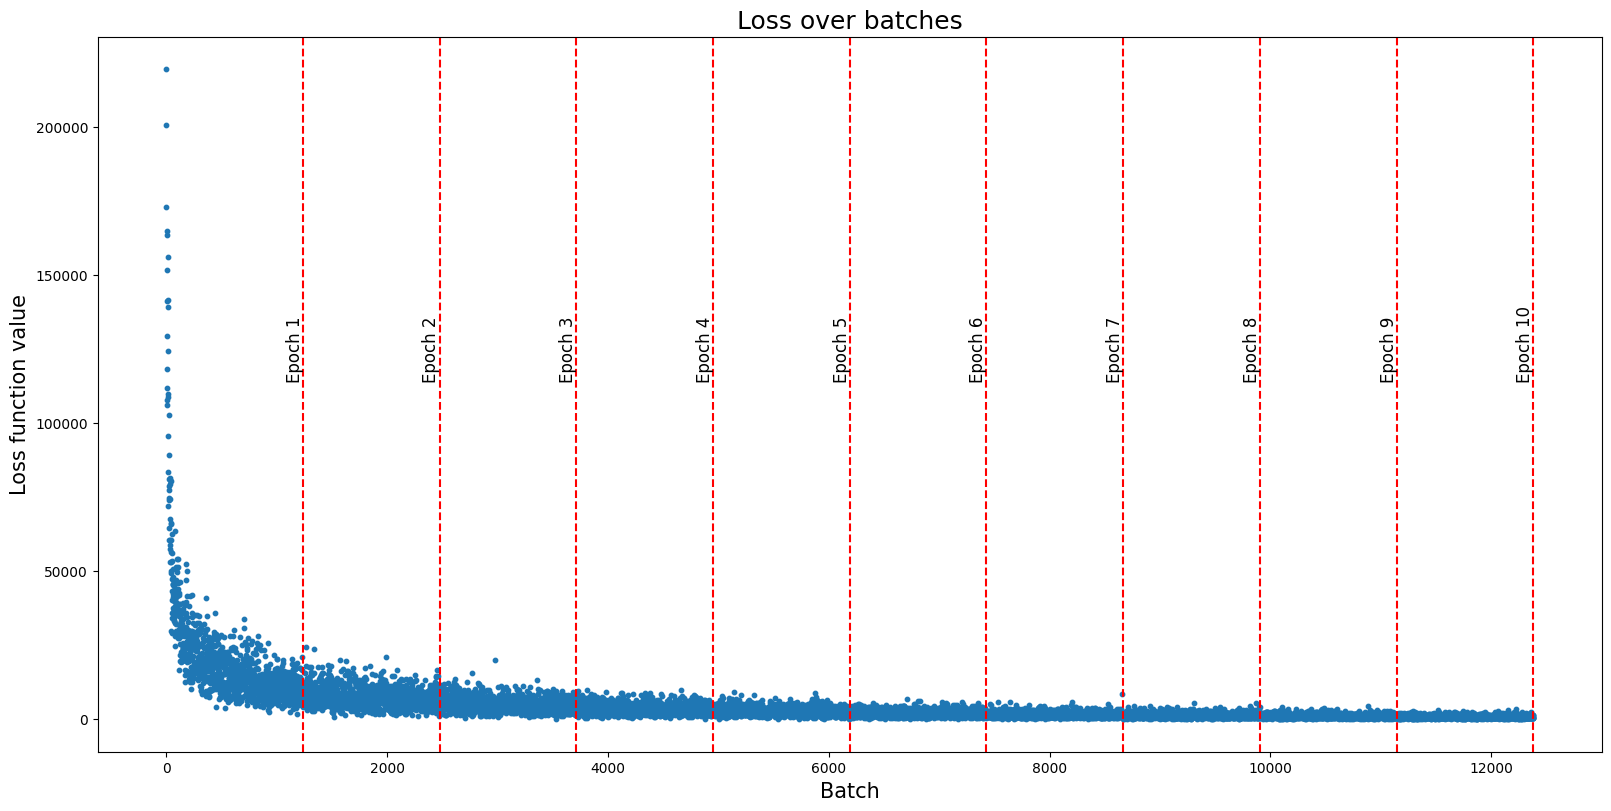

In [73]:
fnn_three_layer = ThreeLayerNN(128,128)
optimizer = torch.optim.Adam(fnn_three_layer.parameters(), weight_decay = 0.001)
train_NN2(train_loader, val_loader, fnn_three_layer, loss_function, optimizer, 10, False, True)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:


 10%|████▍                                       | 1/10 [00:04<00:38,  4.32s/it]

Train loss: 115491.110, Validation loss: 46285.895, Accuraccy: 0.643
Saving best neural network.
Epoch number 2:


 20%|████████▊                                   | 2/10 [00:08<00:31,  3.97s/it]

Train loss: 32854.943, Validation loss: 26962.502, Accuraccy: 0.679
Saving best neural network.
Epoch number 3:


 30%|█████████████▏                              | 3/10 [00:12<00:28,  4.07s/it]

Train loss: 19186.731, Validation loss: 16947.584, Accuraccy: 0.687
Saving best neural network.
Epoch number 4:


 40%|█████████████████▌                          | 4/10 [00:16<00:23,  3.98s/it]

Train loss: 12538.524, Validation loss: 12504.102, Accuraccy: 0.694
Saving best neural network.
Epoch number 5:


 50%|██████████████████████                      | 5/10 [00:19<00:19,  3.93s/it]

Train loss: 8927.507, Validation loss: 10248.121, Accuraccy: 0.691
No improvement in this epoch.
Epoch number 6:


 60%|██████████████████████████▍                 | 6/10 [00:23<00:15,  3.94s/it]

Train loss: 6574.772, Validation loss: 7555.500, Accuraccy: 0.720
Saving best neural network.
Epoch number 7:


 70%|██████████████████████████████▊             | 7/10 [00:27<00:11,  3.96s/it]

Train loss: 5119.492, Validation loss: 6713.795, Accuraccy: 0.711
No improvement in this epoch.
Epoch number 8:


 80%|███████████████████████████████████▏        | 8/10 [00:31<00:07,  3.97s/it]

Train loss: 4015.436, Validation loss: 5993.068, Accuraccy: 0.713
No improvement in this epoch.
Epoch number 9:


 90%|███████████████████████████████████████▌    | 9/10 [00:35<00:03,  3.98s/it]

Train loss: 3386.897, Validation loss: 5019.076, Accuraccy: 0.707
No improvement in this epoch.
Epoch number 10:


100%|███████████████████████████████████████████| 10/10 [00:40<00:00,  4.01s/it]

Train loss: 2850.450, Validation loss: 5203.946, Accuraccy: 0.716
No improvement in this epoch.


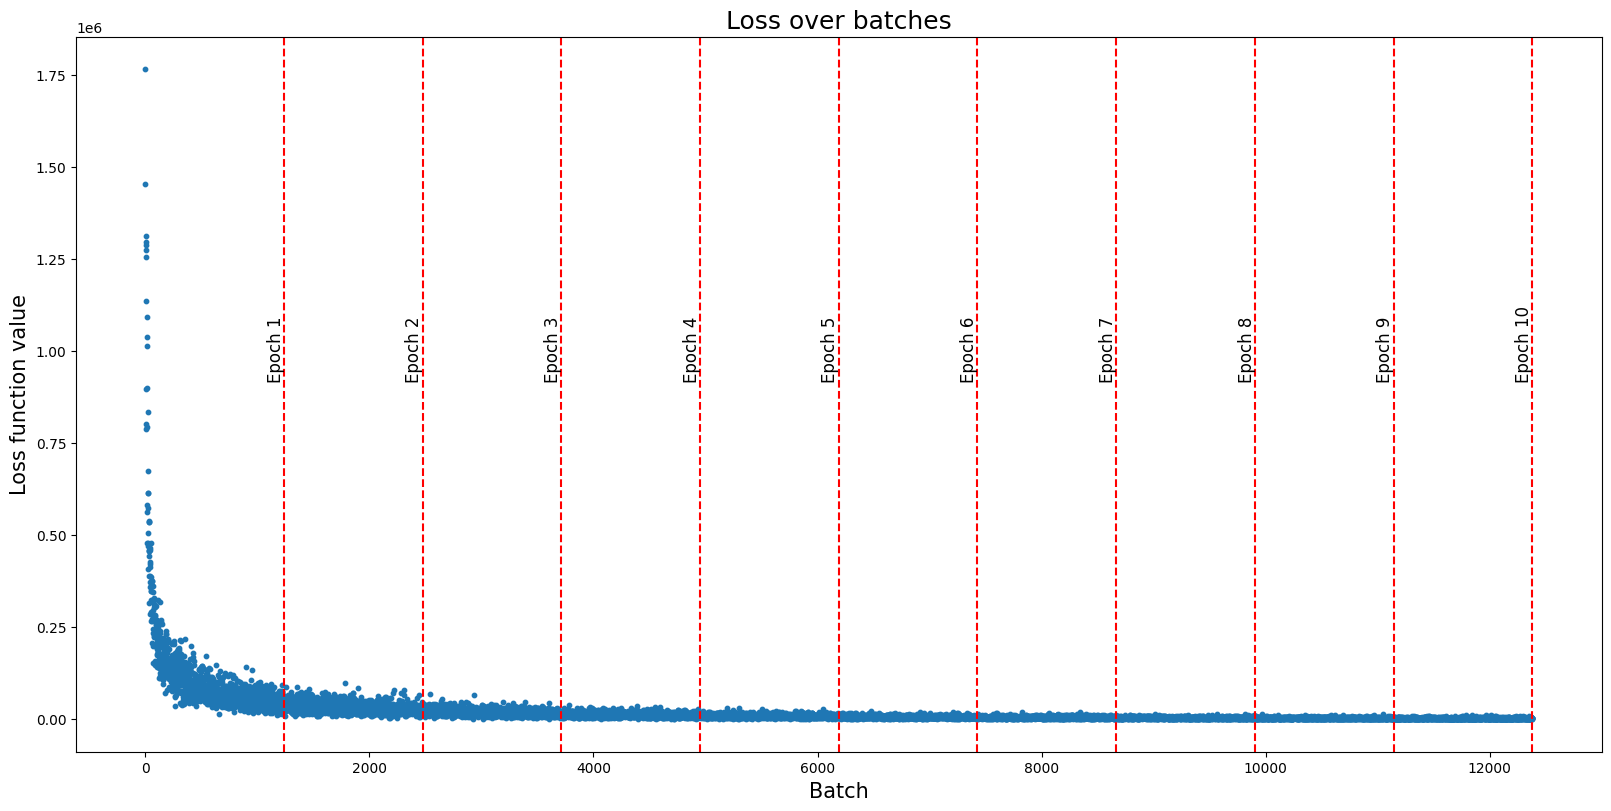

In [74]:
fnn_four_layer = FourLayerNN(128,128,128)
optimizer = torch.optim.Adam(fnn_four_layer.parameters(), weight_decay = 0.001)
train_NN2(train_loader, val_loader, fnn_four_layer, loss_function, optimizer, 10, False, True)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:


 10%|████▍                                       | 1/10 [00:04<00:37,  4.12s/it]

Train loss: 2940.856, Validation loss: 1499.324, Accuraccy: 0.630
Saving best neural network.
Epoch number 2:


 20%|████████▊                                   | 2/10 [00:09<00:38,  4.84s/it]

Train loss: 1042.914, Validation loss: 993.821, Accuraccy: 0.669
Saving best neural network.
Epoch number 3:


 30%|█████████████▏                              | 3/10 [00:13<00:30,  4.34s/it]

Train loss: 665.891, Validation loss: 782.991, Accuraccy: 0.684
Saving best neural network.
Epoch number 4:


 40%|█████████████████▌                          | 4/10 [00:17<00:24,  4.16s/it]

Train loss: 470.168, Validation loss: 653.931, Accuraccy: 0.684
No improvement in this epoch.
Epoch number 5:


 50%|██████████████████████                      | 5/10 [00:20<00:20,  4.03s/it]

Train loss: 357.086, Validation loss: 543.830, Accuraccy: 0.707
Saving best neural network.
Epoch number 6:


 60%|██████████████████████████▍                 | 6/10 [00:24<00:15,  3.92s/it]

Train loss: 279.051, Validation loss: 484.598, Accuraccy: 0.706
No improvement in this epoch.
Epoch number 7:


 70%|██████████████████████████████▊             | 7/10 [00:28<00:11,  3.86s/it]

Train loss: 222.089, Validation loss: 438.034, Accuraccy: 0.715
Saving best neural network.
Epoch number 8:


 80%|███████████████████████████████████▏        | 8/10 [00:32<00:07,  3.82s/it]

Train loss: 181.271, Validation loss: 398.777, Accuraccy: 0.708
No improvement in this epoch.
Epoch number 9:


 90%|███████████████████████████████████████▌    | 9/10 [00:36<00:03,  3.86s/it]

Train loss: 149.045, Validation loss: 360.457, Accuraccy: 0.719
Saving best neural network.
Epoch number 10:


100%|███████████████████████████████████████████| 10/10 [00:39<00:00,  3.99s/it]

Train loss: 127.628, Validation loss: 332.204, Accuraccy: 0.713
No improvement in this epoch.


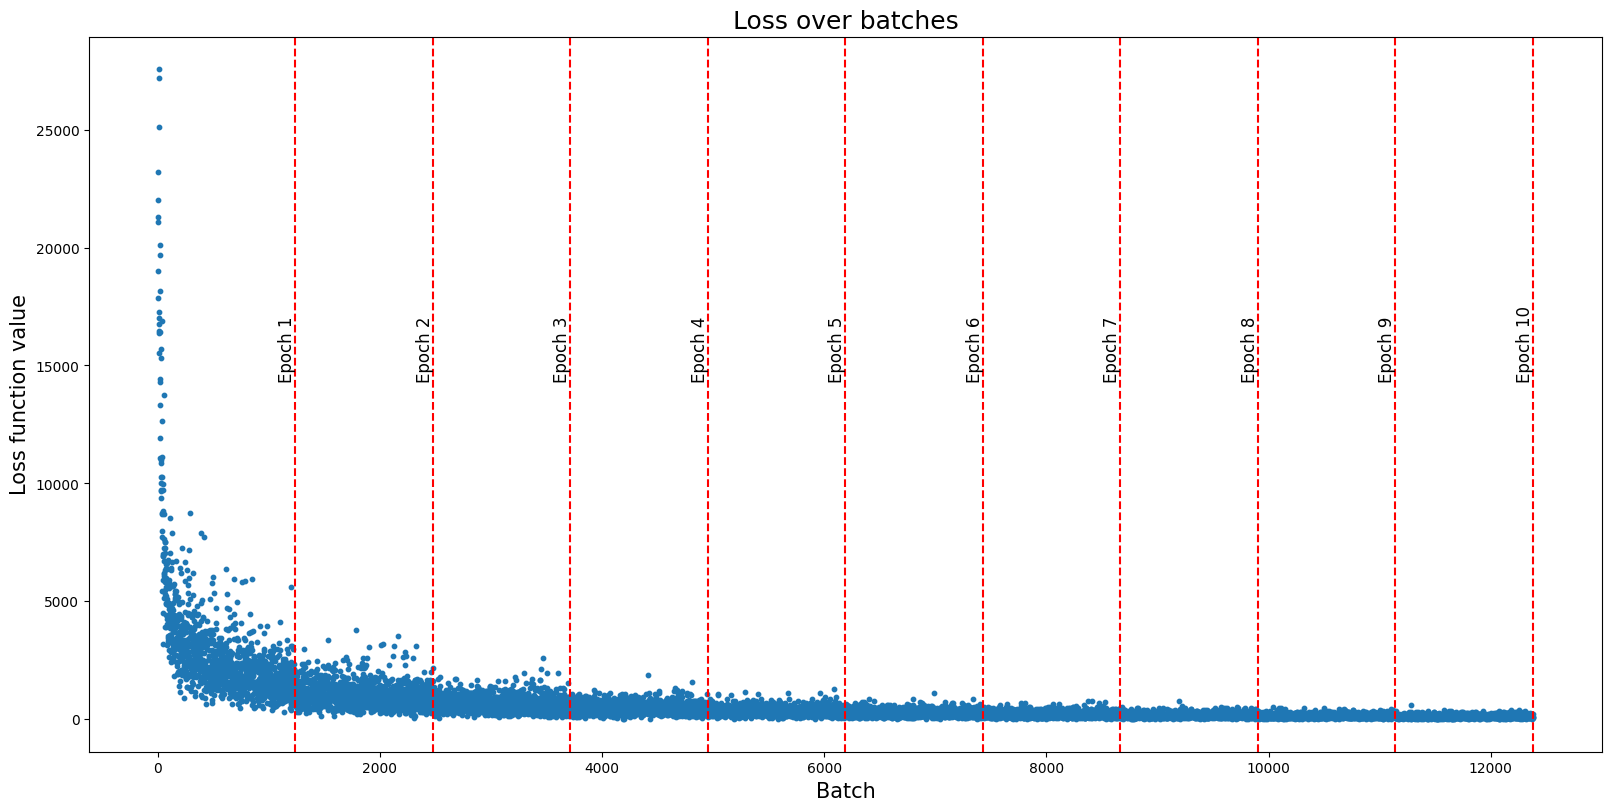

In [75]:
fnn_four_layer = FourLayerNN(128,128,128)
optimizer = torch.optim.Adam(fnn_four_layer.parameters(), weight_decay = 0.001)
train_NN2(train_scaled_loader, val_scaled_loader, fnn_four_layer, loss_function, optimizer, 10, False, True)

`L2 regularization` did not have a significant impact on **FNN**s. In some cases, it helped `prevent overfitting` and `avoided getting stuck in local minima`, but we did not achieve significantly better results.

  0%|                                                     | 0/7 [00:00<?, ?it/s]

Epoch number 1:


 14%|██████▍                                      | 1/7 [00:24<02:26, 24.38s/it]

Train loss: 3.664, Validation loss: 1.391, Accuraccy: 0.483
Saving best neural network.
Epoch number 2:


 29%|████████████▊                                | 2/7 [00:50<02:05, 25.13s/it]

Train loss: 1.228, Validation loss: 1.121, Accuraccy: 0.590
Saving best neural network.
Epoch number 3:


 43%|███████████████████▎                         | 3/7 [01:14<01:38, 24.67s/it]

Train loss: 0.939, Validation loss: 0.895, Accuraccy: 0.657
Saving best neural network.
Epoch number 4:


 57%|█████████████████████████▋                   | 4/7 [01:37<01:12, 24.12s/it]

Train loss: 0.778, Validation loss: 0.725, Accuraccy: 0.735
Saving best neural network.
Epoch number 5:


 71%|████████████████████████████████▏            | 5/7 [02:00<00:47, 23.88s/it]

Train loss: 0.675, Validation loss: 0.676, Accuraccy: 0.733
No improvement in this epoch.
Epoch number 6:


 86%|██████████████████████████████████████▌      | 6/7 [02:23<00:23, 23.55s/it]

Train loss: 0.623, Validation loss: 0.633, Accuraccy: 0.764
Saving best neural network.
Epoch number 7:


100%|█████████████████████████████████████████████| 7/7 [02:47<00:00, 23.88s/it]

Train loss: 0.587, Validation loss: 0.624, Accuraccy: 0.772
Saving best neural network.


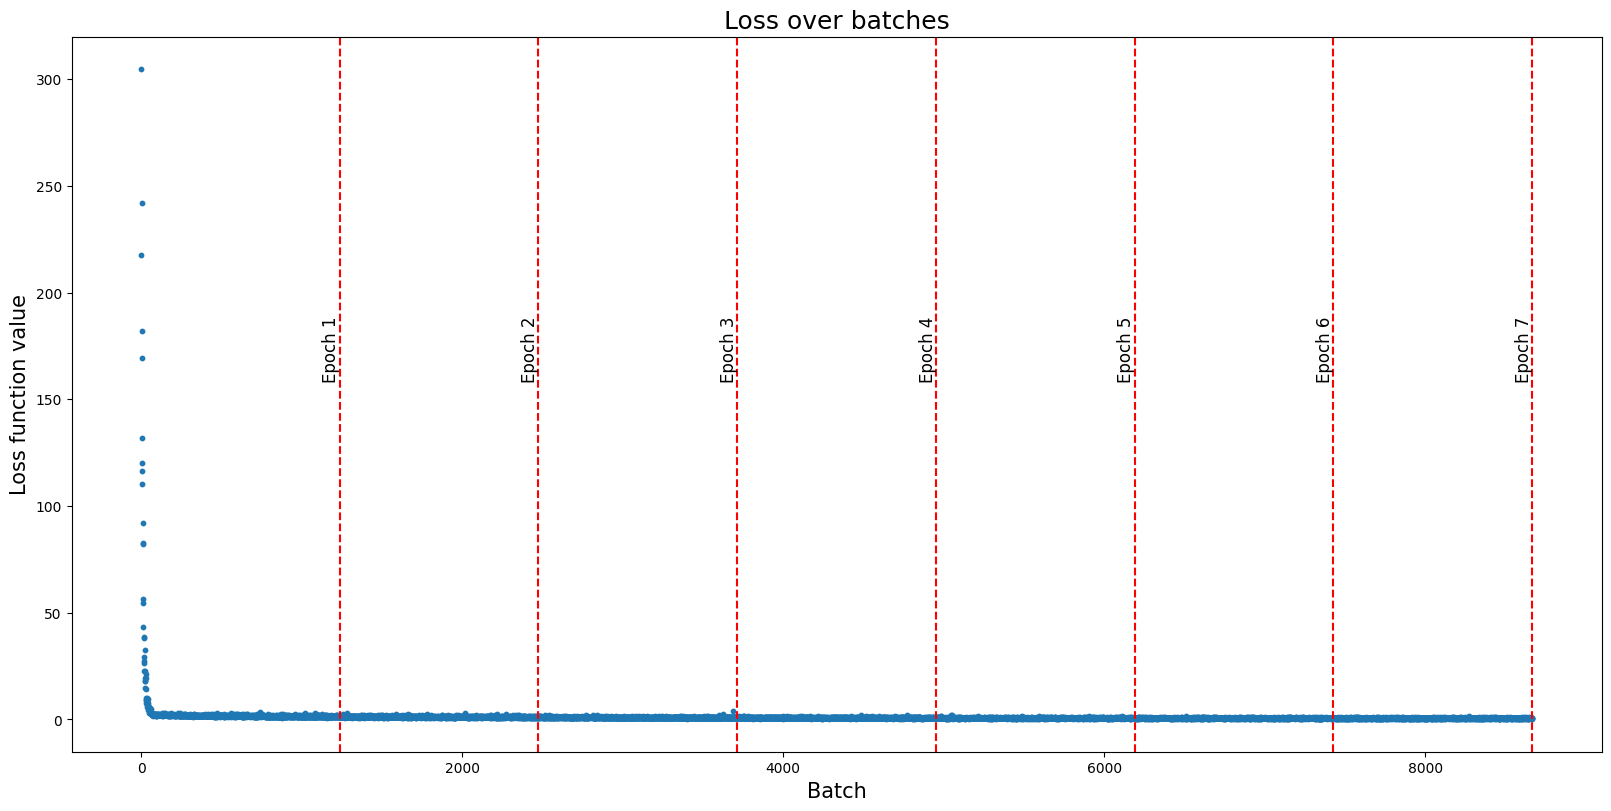

In [76]:
cnn_forw = ConvForwNN()
optimizer = torch.optim.Adam(cnn_forw.parameters(), weight_decay = 0.001)
train_NN2(train_loader, val_loader, cnn_forw, loss_function, optimizer, 7, False, True)

Now we will experiment with the coeficient of penalty term. The values with which we will experiment: **0.01**, **0.001**, **0.0001**.   

  0%|                                                     | 0/7 [00:00<?, ?it/s]

Epoch number 1:


 14%|██████▍                                      | 1/7 [00:29<02:56, 29.35s/it]

Train loss: 0.623, Validation loss: 0.469, Accuraccy: 0.830
Saving best neural network.
Epoch number 2:


 29%|████████████▊                                | 2/7 [01:00<02:31, 30.40s/it]

Train loss: 0.425, Validation loss: 0.438, Accuraccy: 0.840
Saving best neural network.
Epoch number 3:


 43%|███████████████████▎                         | 3/7 [01:28<01:57, 29.28s/it]

Train loss: 0.375, Validation loss: 0.405, Accuraccy: 0.848
Saving best neural network.
Epoch number 4:


 57%|█████████████████████████▋                   | 4/7 [02:02<01:33, 31.21s/it]

Train loss: 0.342, Validation loss: 0.368, Accuraccy: 0.866
Saving best neural network.
Epoch number 5:


 71%|████████████████████████████████▏            | 5/7 [02:34<01:03, 31.59s/it]

Train loss: 0.317, Validation loss: 0.358, Accuraccy: 0.867
Saving best neural network.
Epoch number 6:


 86%|██████████████████████████████████████▌      | 6/7 [03:04<00:30, 30.79s/it]

Train loss: 0.302, Validation loss: 0.347, Accuraccy: 0.874
Saving best neural network.
Epoch number 7:


100%|█████████████████████████████████████████████| 7/7 [03:34<00:00, 30.59s/it]

Train loss: 0.290, Validation loss: 0.348, Accuraccy: 0.874
No improvement in this epoch.


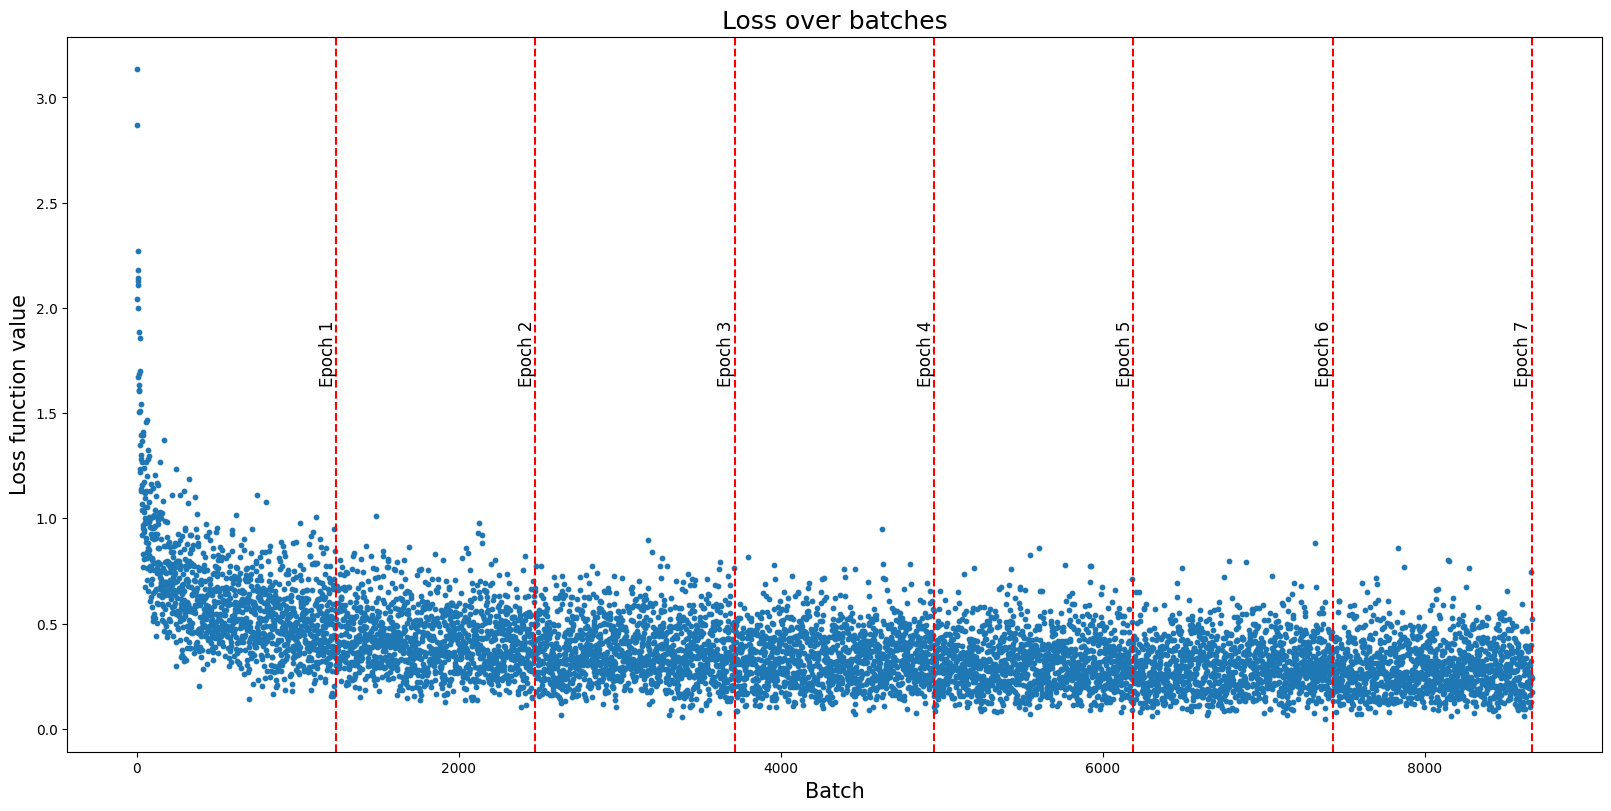

In [77]:
cnn_forw = ConvForwNN2()
optimizer = torch.optim.Adam(cnn_forw.parameters(), weight_decay = 0.001)
train_NN2(train_scaled_loader, val_scaled_loader, cnn_forw, loss_function, optimizer, 7, False, True)

  0%|                                                     | 0/7 [00:00<?, ?it/s]

Epoch number 1:


 14%|██████▍                                      | 1/7 [00:27<02:47, 27.96s/it]

Train loss: 0.697, Validation loss: 0.547, Accuraccy: 0.807
Saving best neural network.
Epoch number 2:


 29%|████████████▊                                | 2/7 [00:55<02:18, 27.74s/it]

Train loss: 0.477, Validation loss: 0.490, Accuraccy: 0.825
Saving best neural network.
Epoch number 3:


 43%|███████████████████▎                         | 3/7 [01:24<01:53, 28.34s/it]

Train loss: 0.449, Validation loss: 0.469, Accuraccy: 0.832
Saving best neural network.
Epoch number 4:


 57%|█████████████████████████▋                   | 4/7 [01:53<01:26, 28.69s/it]

Train loss: 0.433, Validation loss: 0.467, Accuraccy: 0.829
No improvement in this epoch.
Epoch number 5:


 71%|████████████████████████████████▏            | 5/7 [02:28<01:01, 30.92s/it]

Train loss: 0.424, Validation loss: 0.455, Accuraccy: 0.836
Saving best neural network.
Epoch number 6:


 86%|██████████████████████████████████████▌      | 6/7 [03:10<00:34, 34.48s/it]

Train loss: 0.416, Validation loss: 0.427, Accuraccy: 0.842
Saving best neural network.
Epoch number 7:


100%|█████████████████████████████████████████████| 7/7 [03:44<00:00, 32.14s/it]

Train loss: 0.407, Validation loss: 0.449, Accuraccy: 0.836
No improvement in this epoch.


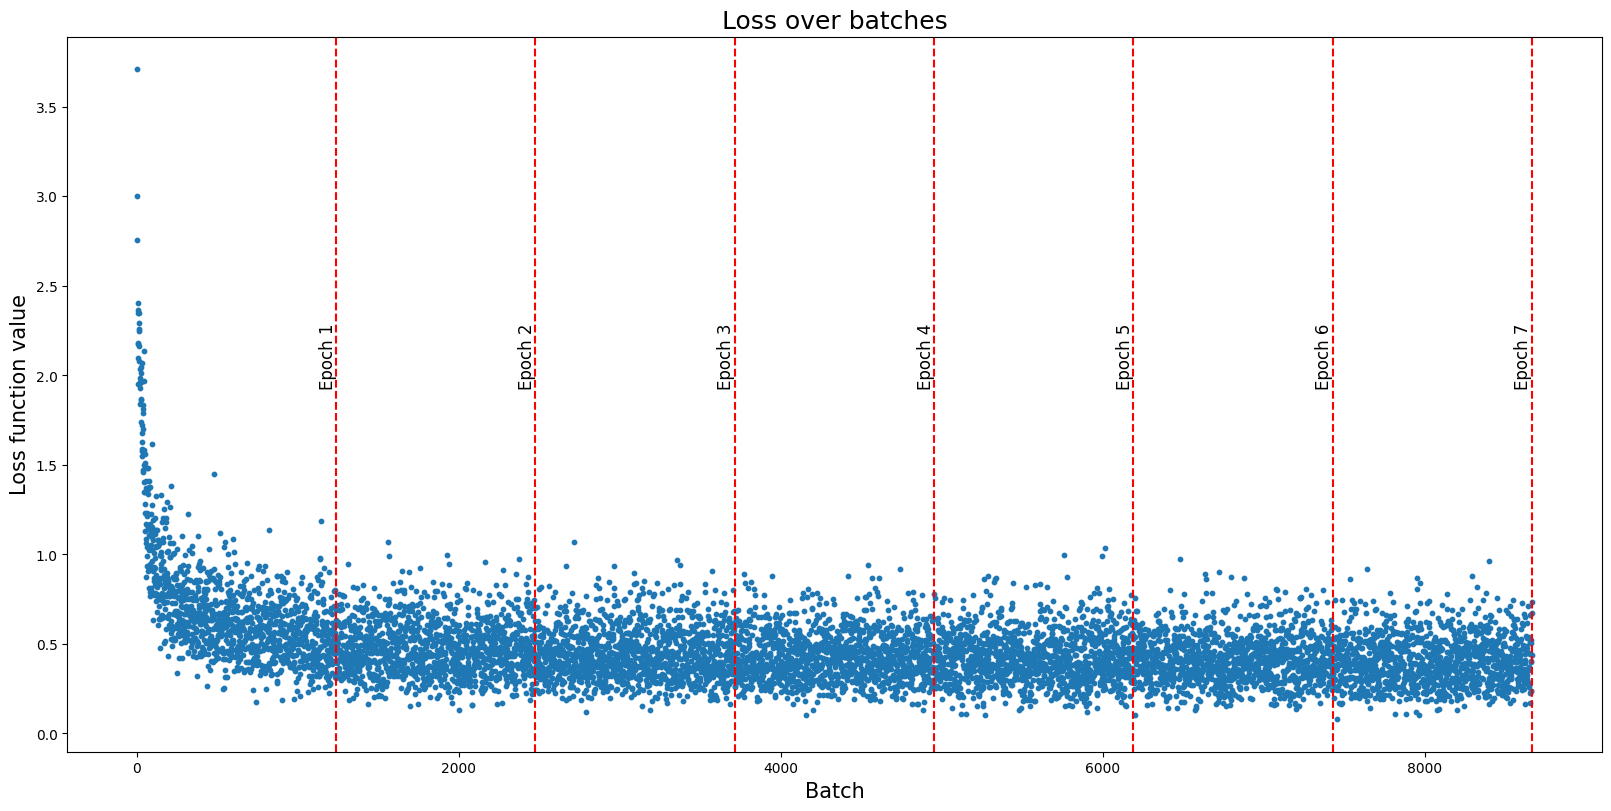

In [78]:
cnn_forw2 = ConvForwNN2()
optimizer = torch.optim.Adam(cnn_forw2.parameters(), weight_decay = 0.01)
train_NN2(train_scaled_loader, val_scaled_loader, cnn_forw2, loss_function, optimizer, 7, False, True)

  0%|                                                     | 0/7 [00:00<?, ?it/s]

Epoch number 1:


 14%|██████▍                                      | 1/7 [00:28<02:48, 28.06s/it]

Train loss: 0.660, Validation loss: 0.492, Accuraccy: 0.816
Saving best neural network.
Epoch number 2:


 29%|████████████▊                                | 2/7 [00:58<02:28, 29.61s/it]

Train loss: 0.434, Validation loss: 0.421, Accuraccy: 0.845
Saving best neural network.
Epoch number 3:


 43%|███████████████████▎                         | 3/7 [01:33<02:08, 32.10s/it]

Train loss: 0.378, Validation loss: 0.422, Accuraccy: 0.849
Saving best neural network.
Epoch number 4:


 57%|█████████████████████████▋                   | 4/7 [02:06<01:37, 32.40s/it]

Train loss: 0.342, Validation loss: 0.396, Accuraccy: 0.857
Saving best neural network.
Epoch number 5:


 71%|████████████████████████████████▏            | 5/7 [02:43<01:07, 33.94s/it]

Train loss: 0.318, Validation loss: 0.363, Accuraccy: 0.865
Saving best neural network.
Epoch number 6:


 86%|██████████████████████████████████████▌      | 6/7 [03:13<00:32, 32.63s/it]

Train loss: 0.296, Validation loss: 0.357, Accuraccy: 0.871
Saving best neural network.
Epoch number 7:


100%|█████████████████████████████████████████████| 7/7 [03:46<00:00, 32.39s/it]

Train loss: 0.281, Validation loss: 0.393, Accuraccy: 0.860
No improvement in this epoch.


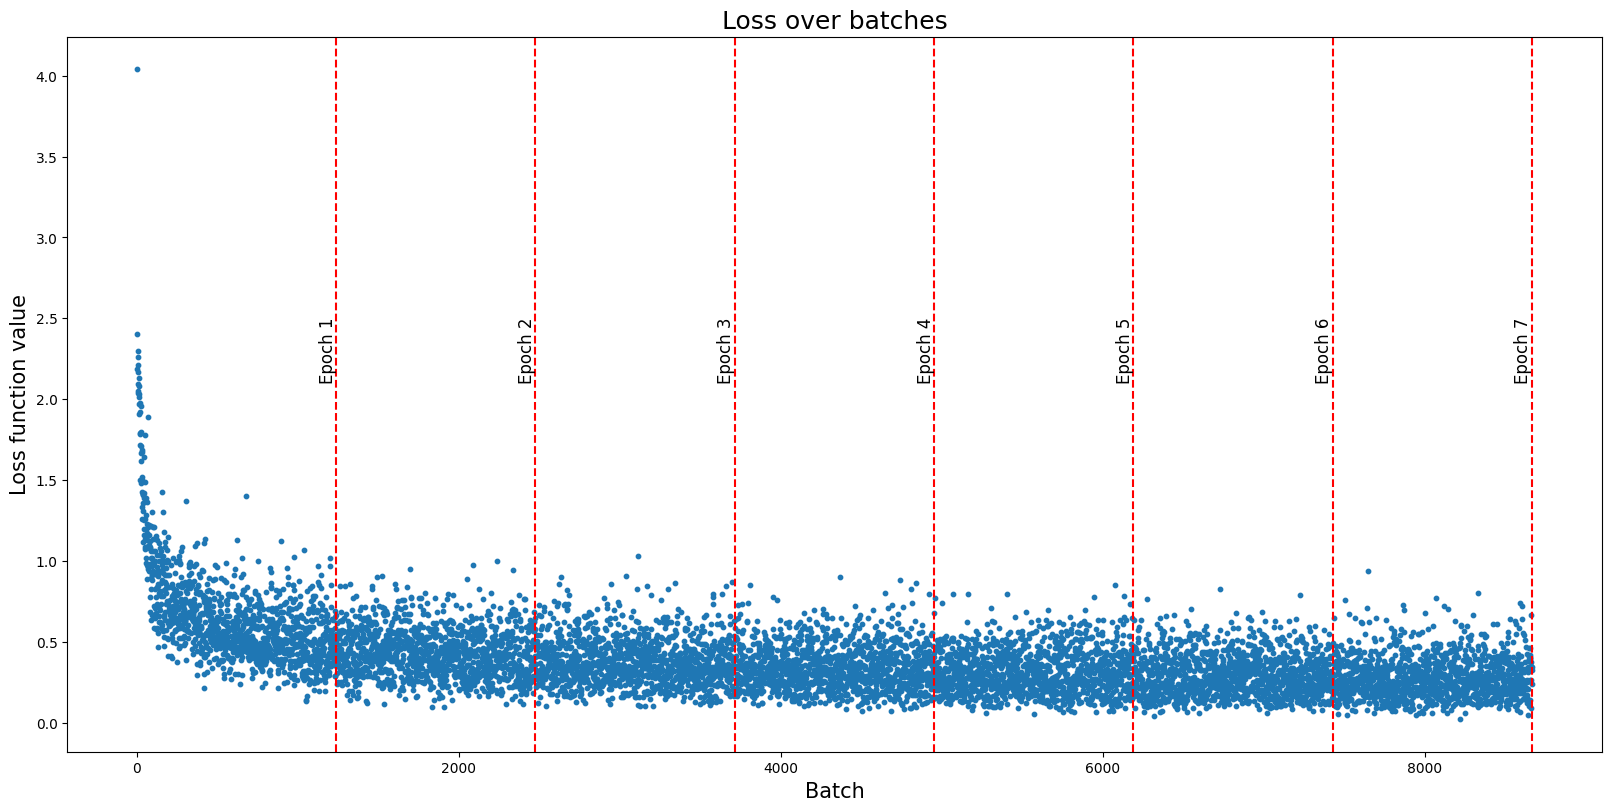

In [79]:
cnn_forw2 = ConvForwNN2()
optimizer = torch.optim.Adam(cnn_forw2.parameters(), weight_decay = 0.0001)
train_NN2(train_scaled_loader, val_scaled_loader, cnn_forw2, loss_function, optimizer, 7, False, True)

We get the best results when the value is set to **0.0001**. 

Now we will add to all our neural networks `dropout` and `batch normalisation`.

In [80]:
class TwoLayerNNd(nn.Module):
    def __init__(self, hidden_layer, dropout_rate):
        super().__init__()
        self.fc1 = nn.Linear(32*32, hidden_layer)
        self.fc1_drop = nn.Dropout(dropout_rate)
        self.fco = nn.Linear(hidden_layer, 10)
        
        nn.init.normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.normal_(self.fco.weight)
        nn.init.zeros_(self.fco.bias)

    def forward(self, x):
        x = x.flatten(start_dim=1).to(self.fc1.weight.dtype)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fco(x)
        return x
    
    def predict_proba(self, x):
        with torch.no_grad():
            pred = self.forward(x)
            probabilities = F.softmax(pred, dim=1)
        return probabilities

    def predict(self, x):
        probabilities = self.predict_proba(x)
        with torch.no_grad():
            max_probabilities, predicted_classes = torch.max(probabilities, dim=1)
        return predicted_classes


class ThreeLayerNNd(nn.Module):
    def __init__(self, hidden_layer1, hidden_layer2):
        super().__init__()
        self.fc1 = nn.Linear(32*32, hidden_layer1)
        self.fc1_bn = nn.BatchNorm1d(hidden_layer1)
        self.fc1_drop = nn.Dropout(0.4)
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.fc2_bn = nn.BatchNorm1d(hidden_layer2)
        self.fc2_drop = nn.Dropout(0.1)
        self.fco = nn.Linear(hidden_layer2, 10)
        
        nn.init.normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.normal_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.normal_(self.fco.weight)
        nn.init.zeros_(self.fco.bias)

    def forward(self, x):
        x = x.flatten(start_dim=1).to(self.fc1.weight.dtype)
        x = self.fc1_bn(self.fc1(x))
        x = F.relu(x)
        x = self.fc1_drop(x)
        x = self.fc2_bn(self.fc2(x))
        x = F.relu(x)
        x = self.fc2_drop(x)
        x = self.fco(x)
        return x
    
    def predict_proba(self, x):
        with torch.no_grad():
            pred = self.forward(x)
            probabilities = F.softmax(pred, dim=1)
        return probabilities

    def predict(self, x):
        probabilities = self.predict_proba(x)
        with torch.no_grad():
            max_probabilities, predicted_classes = torch.max(probabilities, dim=1)
        return predicted_classes
    

class FourLayerNNd(nn.Module):
    def __init__(self, hidden_layer1, hidden_layer2, hidden_layer3):
        super().__init__()
        self.fc1 = nn.Linear(32*32, hidden_layer1)
        self.fc1_bn = nn.BatchNorm1d(hidden_layer1)
        self.fc1_drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.fc2_bn = nn.BatchNorm1d(hidden_layer2)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_layer2, hidden_layer3)
        self.fc3_bn = nn.BatchNorm1d(hidden_layer3)
        self.fc3_drop = nn.Dropout(0.1)
        self.fco = nn.Linear(hidden_layer3, 10)
        
        nn.init.normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.normal_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.normal_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)
        nn.init.normal_(self.fco.weight)
        torch.nn.init.zeros_(self.fco.bias)

    def forward(self, x):
        x = x.flatten(start_dim=1).to(self.fc1.weight.dtype)
        x = self.fc1_bn(self.fc1(x))
        x = F.relu(x)
        x = self.fc1_drop(x)
        x = self.fc2_bn(self.fc2(x))
        x = F.relu(x)
        x = self.fc2_drop(x)
        x = self.fc3_bn(self.fc3(x))
        x = F.relu(x)
        x = self.fc3_drop(x)
        x = self.fco(x)
        return x
    
    def predict_proba(self, x):
        with torch.no_grad():
            pred = self.forward(x)
            probabilities = F.softmax(pred, dim=1)
        return probabilities

    def predict(self, x):
        probabilities = self.predict_proba(x)
        with torch.no_grad():
            max_probabilities, predicted_classes = torch.max(probabilities, dim=1)
        return predicted_classes

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:


 10%|████▍                                       | 1/10 [00:09<01:21,  9.08s/it]

Train loss: 9031.723, Validation loss: 2488.755, Accuraccy: 0.713
Saving best neural network.
Epoch number 2:


 20%|████████▊                                   | 2/10 [00:19<01:20, 10.07s/it]

Train loss: 1888.468, Validation loss: 850.185, Accuraccy: 0.699
No improvement in this epoch.
Epoch number 3:


 30%|█████████████▏                              | 3/10 [00:28<01:06,  9.47s/it]

Train loss: 683.942, Validation loss: 362.634, Accuraccy: 0.658
No improvement in this epoch.
Epoch number 4:


 40%|█████████████████▌                          | 4/10 [00:38<00:58,  9.73s/it]

Train loss: 319.315, Validation loss: 205.113, Accuraccy: 0.610
No improvement in this epoch.
Epoch number 5:


 50%|██████████████████████                      | 5/10 [00:48<00:49,  9.87s/it]

Train loss: 172.293, Validation loss: 125.806, Accuraccy: 0.611
No improvement in this epoch.
Epoch number 6:


 50%|██████████████████████                      | 5/10 [00:56<00:56, 11.39s/it]

Train loss: 96.995, Validation loss: 86.824, Accuraccy: 0.564
No improvement in this epoch.
Early stopping now.


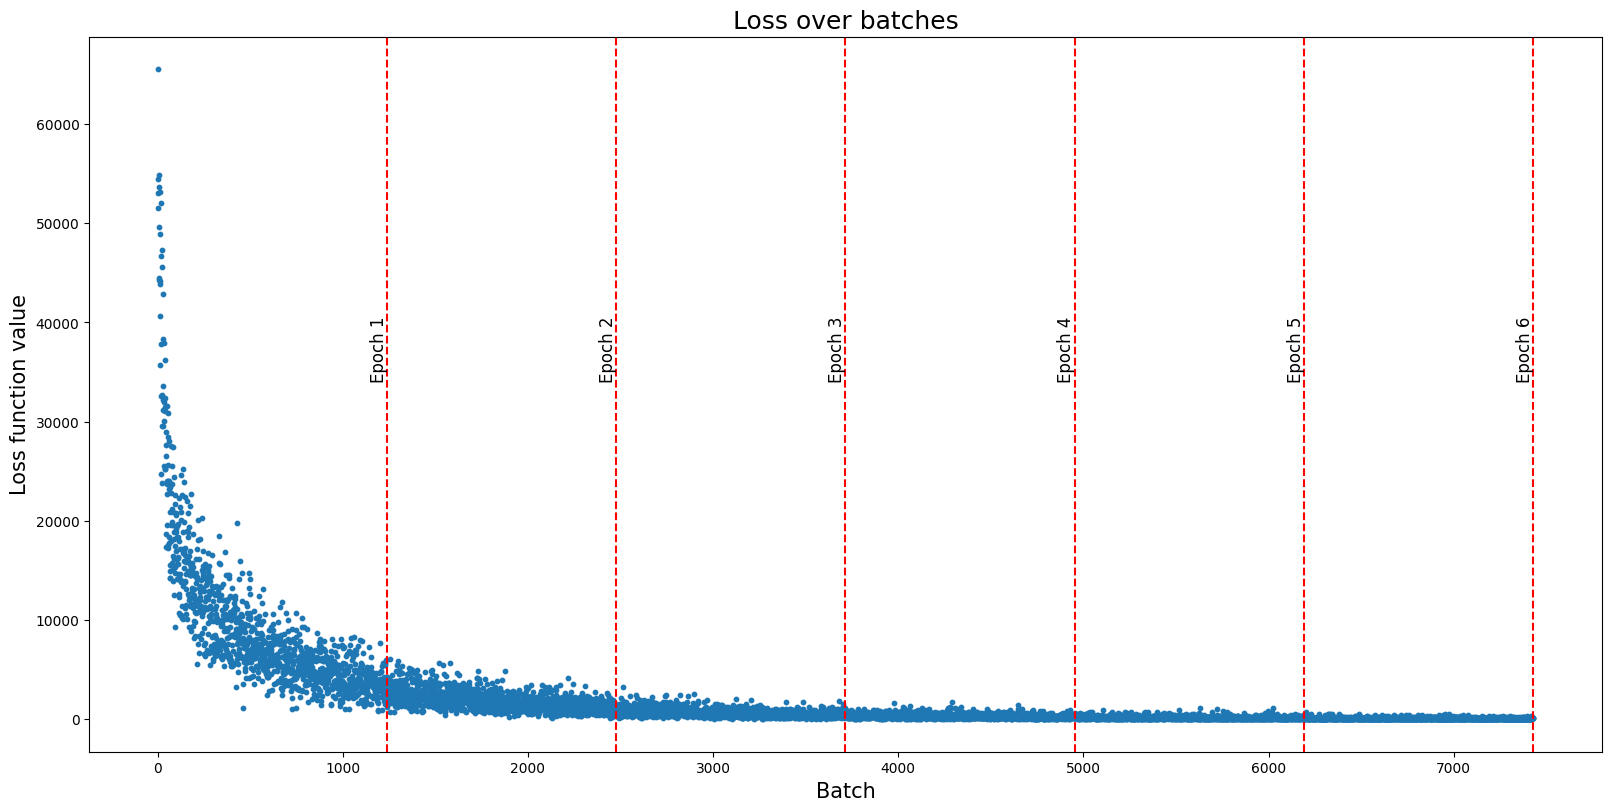

In [81]:
fnn_two_layerd = TwoLayerNNd(512, 0.2)
optimizer = torch.optim.Adam(fnn_two_layerd.parameters())
train_NN2(train_loader, val_loader, fnn_two_layerd, loss_function, optimizer, 10, False, True)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:


 10%|████▍                                       | 1/10 [00:06<00:58,  6.51s/it]

Train loss: 4.344, Validation loss: 1.242, Accuraccy: 0.727
Saving best neural network.
Epoch number 2:


 20%|████████▊                                   | 2/10 [00:12<00:51,  6.46s/it]

Train loss: 1.950, Validation loss: 0.899, Accuraccy: 0.743
Saving best neural network.
Epoch number 3:


 30%|█████████████▏                              | 3/10 [00:19<00:45,  6.44s/it]

Train loss: 1.354, Validation loss: 0.712, Accuraccy: 0.760
Saving best neural network.
Epoch number 4:


 40%|█████████████████▌                          | 4/10 [00:25<00:38,  6.43s/it]

Train loss: 1.061, Validation loss: 0.647, Accuraccy: 0.771
Saving best neural network.
Epoch number 5:


 50%|██████████████████████                      | 5/10 [00:32<00:32,  6.42s/it]

Train loss: 0.889, Validation loss: 0.616, Accuraccy: 0.776
Saving best neural network.
Epoch number 6:


 60%|██████████████████████████▍                 | 6/10 [00:38<00:25,  6.42s/it]

Train loss: 0.805, Validation loss: 0.596, Accuraccy: 0.785
Saving best neural network.
Epoch number 7:


 70%|██████████████████████████████▊             | 7/10 [00:45<00:19,  6.42s/it]

Train loss: 0.737, Validation loss: 0.571, Accuraccy: 0.794
Saving best neural network.
Epoch number 8:


 80%|███████████████████████████████████▏        | 8/10 [00:51<00:12,  6.42s/it]

Train loss: 0.692, Validation loss: 0.560, Accuraccy: 0.800
Saving best neural network.
Epoch number 9:


 90%|███████████████████████████████████████▌    | 9/10 [00:57<00:06,  6.42s/it]

Train loss: 0.660, Validation loss: 0.538, Accuraccy: 0.806
Saving best neural network.
Epoch number 10:


100%|███████████████████████████████████████████| 10/10 [01:04<00:00,  6.43s/it]

Train loss: 0.639, Validation loss: 0.532, Accuraccy: 0.804
No improvement in this epoch.


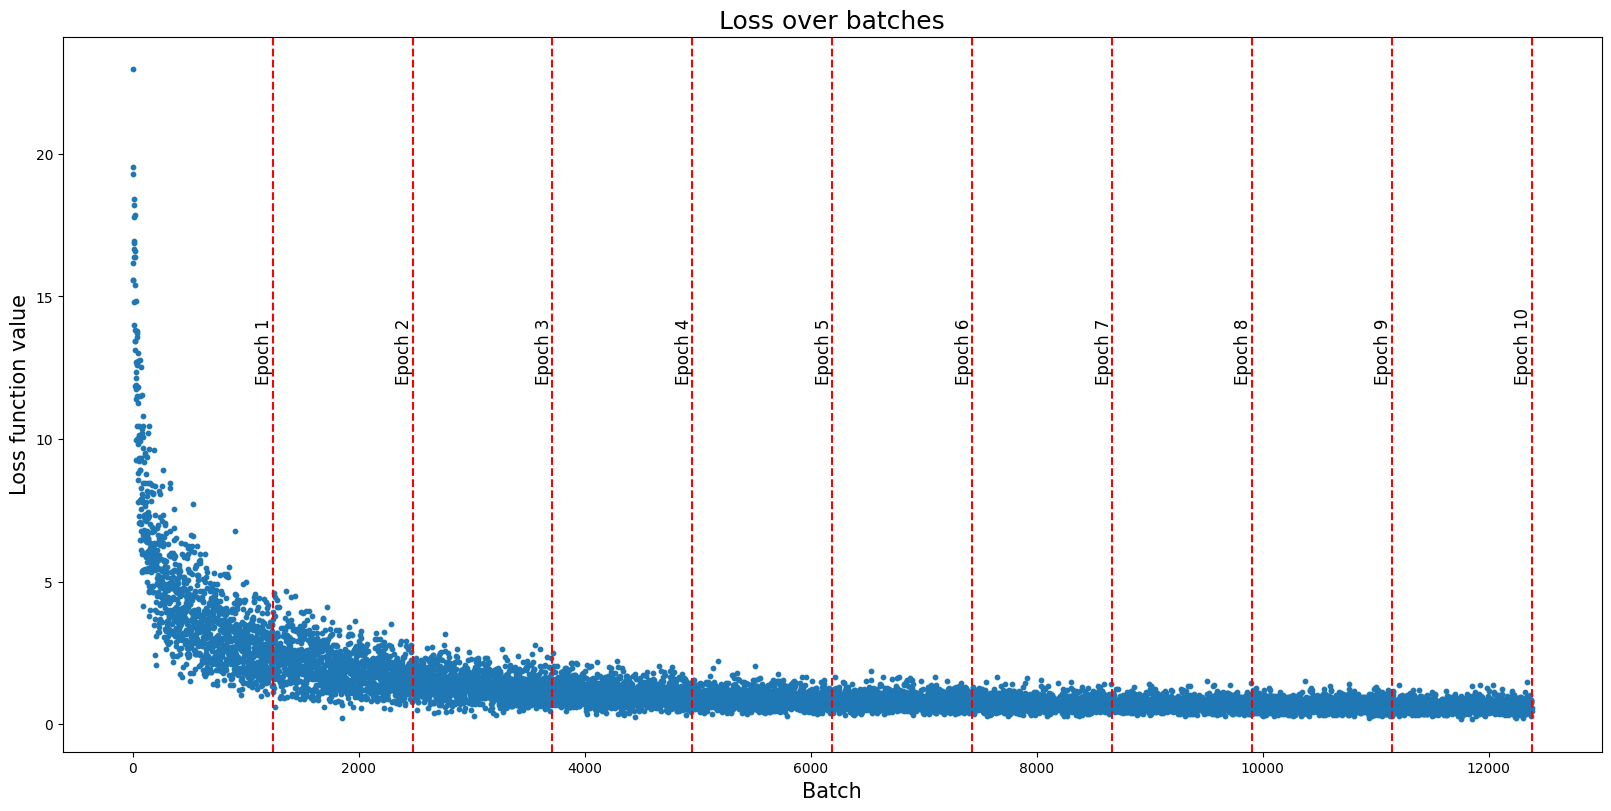

In [82]:
fnn_three_layerd = ThreeLayerNNd(256, 256)
optimizer = torch.optim.Adam(fnn_three_layerd.parameters())
train_NN2(train_loader, val_loader, fnn_three_layerd, loss_function, optimizer, 10, False, True)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch number 1:


 10%|████▍                                       | 1/10 [00:06<01:00,  6.72s/it]

Train loss: 4.021, Validation loss: 1.029, Accuraccy: 0.655
Saving best neural network.
Epoch number 2:


 20%|████████▊                                   | 2/10 [00:13<00:52,  6.59s/it]

Train loss: 1.657, Validation loss: 0.862, Accuraccy: 0.680
Saving best neural network.
Epoch number 3:


 30%|█████████████▏                              | 3/10 [00:19<00:45,  6.54s/it]

Train loss: 1.211, Validation loss: 0.803, Accuraccy: 0.708
Saving best neural network.
Epoch number 4:


 40%|█████████████████▌                          | 4/10 [00:26<00:39,  6.53s/it]

Train loss: 1.033, Validation loss: 0.762, Accuraccy: 0.722
Saving best neural network.
Epoch number 5:


 50%|██████████████████████                      | 5/10 [00:33<00:34,  6.96s/it]

Train loss: 0.944, Validation loss: 0.706, Accuraccy: 0.730
Saving best neural network.
Epoch number 6:


 60%|██████████████████████████▍                 | 6/10 [00:41<00:27,  7.00s/it]

Train loss: 0.878, Validation loss: 0.662, Accuraccy: 0.748
Saving best neural network.
Epoch number 7:


 70%|██████████████████████████████▊             | 7/10 [00:47<00:20,  6.99s/it]

Train loss: 0.831, Validation loss: 0.639, Accuraccy: 0.756
Saving best neural network.
Epoch number 8:


 80%|███████████████████████████████████▏        | 8/10 [00:55<00:14,  7.26s/it]

Train loss: 0.791, Validation loss: 0.612, Accuraccy: 0.766
Saving best neural network.
Epoch number 9:


 90%|███████████████████████████████████████▌    | 9/10 [01:03<00:07,  7.48s/it]

Train loss: 0.760, Validation loss: 0.594, Accuraccy: 0.778
Saving best neural network.
Epoch number 10:


100%|███████████████████████████████████████████| 10/10 [01:12<00:00,  7.28s/it]

Train loss: 0.728, Validation loss: 0.570, Accuraccy: 0.788
Saving best neural network.


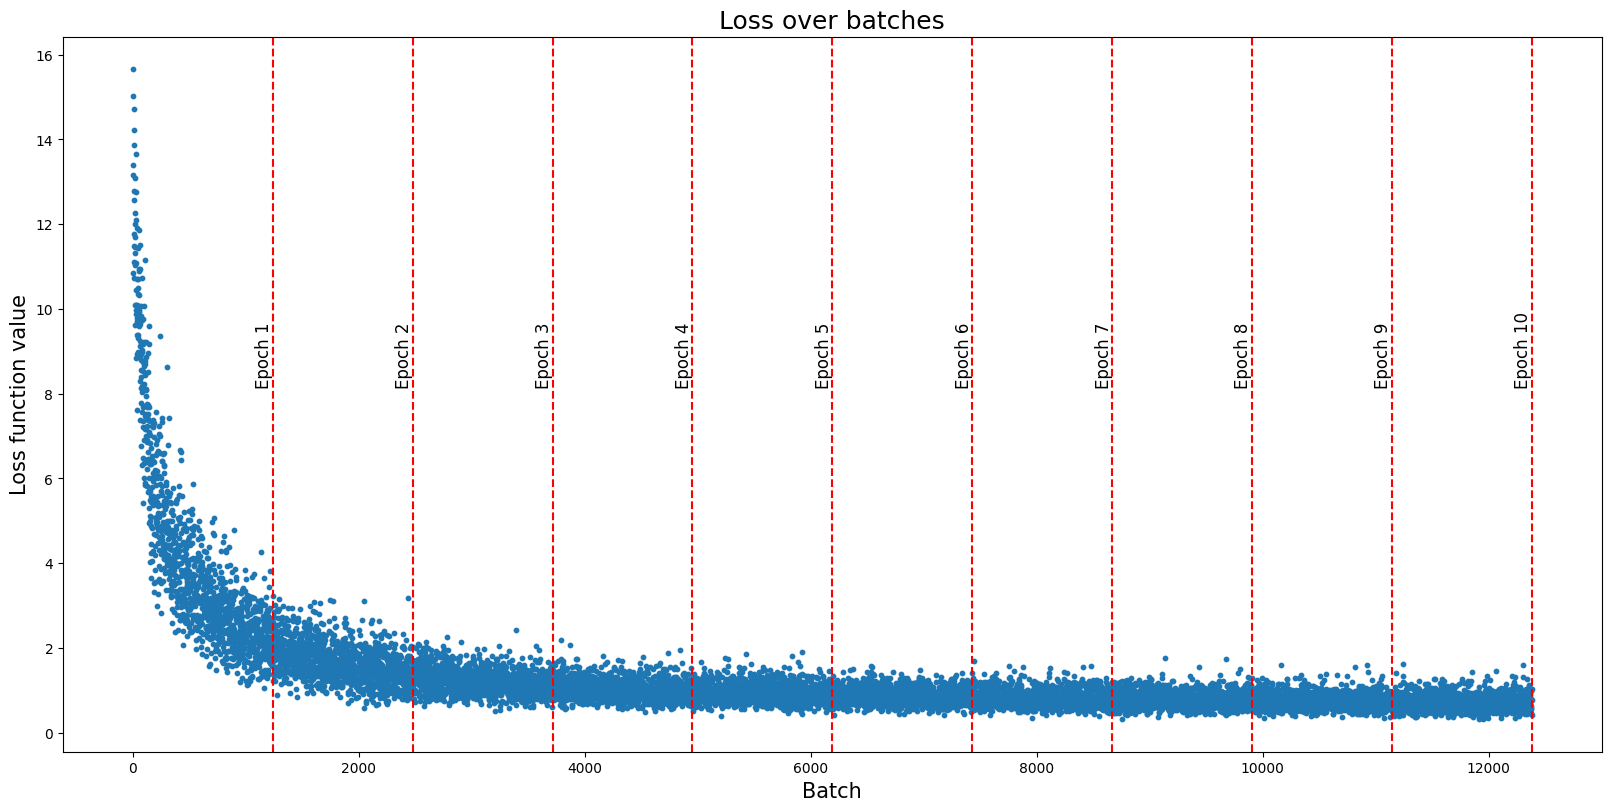

In [83]:
fnn_four_layerd = FourLayerNNd(256, 128, 128)
optimizer = torch.optim.Adam(fnn_four_layerd.parameters())
train_NN2(train_loader, val_loader, fnn_four_layerd, loss_function, optimizer, 10, False, True)

These regularizations techniques gives us the best **FNNs**. In three-layer and four-layer forward neural network we get the highest validation accuracies among models with these structures.

Apply the same `regularization techniques` to `convolutional neural networks` and follow their performances.

In [84]:
class ConvForwNNd(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv1_drop = nn.Dropout2d(p=0.5)
        
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 1)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        
        self.conv3 = nn.Conv2d(32, 16, 2)
        self.conv3_bn = nn.BatchNorm2d(16)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv3_drop = nn.Dropout2d(p=0.1)
        
        self.fc1 = nn.Linear(16*5*5, 32)
        self.fc1_bn = nn.BatchNorm1d(32)
        self.fc1_drop = nn.Dropout(0.1)
        self.fco = nn.Linear(32, 10)
        
        
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.zeros_(self.conv3.bias)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_normal_(self.fco.weight)
        nn.init.zeros_(self.fco.bias)

    def forward(self, x):
        x = self.conv1(x.to(self.conv1.weight.dtype))
        x = self.conv1_bn(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv1_drop(x)
        
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv2_drop(x)
        
        x = self.conv3(x)
        x = self.conv3_bn(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.conv3_drop(x)
        
        x = x.flatten(start_dim = 1)
        x = self.fc1(x)
        x = self.fc1_bn(x)
        x = F.relu(x)
        x = self.fc1_drop(x)
        x = self.fco(x)
        
        return x
    
    def predict_proba(self, x):
        with torch.no_grad():
            pred = self.forward(x)
            probabilities = F.softmax(pred, dim=1)
        return probabilities

    def predict(self, x):
        probabilities = self.predict_proba(x)
        with torch.no_grad():
            max_probabilities, predicted_classes = torch.max(probabilities, dim=1)
        return predicted_classes


class ConvForwNN2d(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, padding = 1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv1_drop = nn.Dropout2d(p=0.5)
        
        self.conv2 = nn.Conv2d(32, 32, 3, padding = 1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 1)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        
        self.conv3 = nn.Conv2d(32, 16, 3)
        self.conv3_bn = nn.BatchNorm2d(16)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv3_drop = nn.Dropout2d(p=0.1)
        
        self.fc1 = nn.Linear(16*6*6, 32)
        self.fc1_bn = nn.BatchNorm1d(32)
        self.fc1_drop = nn.Dropout(0.1)
        self.fco = nn.Linear(32, 10)
        
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.zeros_(self.conv3.bias)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_normal_(self.fco.weight)
        nn.init.zeros_(self.fco.bias)

    def forward(self, x):
        x = self.conv1(x.to(self.conv1.weight.dtype))
        x = self.conv1_bn(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv1_drop(x)
        
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv2_drop(x)
        
        x = self.conv3(x)
        x = self.conv3_bn(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.conv3_drop(x)
        
        x = x.flatten(start_dim = 1)
        x = self.fc1(x)
        x = self.fc1_bn(x)
        x = F.relu(x)
        x = self.fc1_drop(x)
        x = self.fco(x)
        
        return x
    
    def predict_proba(self, x):
        with torch.no_grad():
            pred = self.forward(x)
            probabilities = F.softmax(pred, dim=1)
        return probabilities

    def predict(self, x):
        probabilities = self.predict_proba(x)
        with torch.no_grad():
            max_probabilities, predicted_classes = torch.max(probabilities, dim=1)
        return predicted_classes

  0%|                                                     | 0/7 [00:00<?, ?it/s]

Epoch number 1:


 14%|██████▍                                      | 1/7 [00:33<03:19, 33.23s/it]

Train loss: 0.946, Validation loss: 0.572, Accuraccy: 0.781
Saving best neural network.
Epoch number 2:


 29%|████████████▊                                | 2/7 [01:03<02:36, 31.24s/it]

Train loss: 0.636, Validation loss: 0.496, Accuraccy: 0.812
Saving best neural network.
Epoch number 3:


 43%|███████████████████▎                         | 3/7 [01:31<01:59, 29.92s/it]

Train loss: 0.573, Validation loss: 0.446, Accuraccy: 0.836
Saving best neural network.
Epoch number 4:


 57%|█████████████████████████▋                   | 4/7 [01:58<01:26, 28.72s/it]

Train loss: 0.537, Validation loss: 0.416, Accuraccy: 0.845
Saving best neural network.
Epoch number 5:


 71%|████████████████████████████████▏            | 5/7 [02:25<00:56, 28.06s/it]

Train loss: 0.506, Validation loss: 0.403, Accuraccy: 0.852
Saving best neural network.
Epoch number 6:


 86%|██████████████████████████████████████▌      | 6/7 [02:53<00:28, 28.03s/it]

Train loss: 0.489, Validation loss: 0.386, Accuraccy: 0.855
Saving best neural network.
Epoch number 7:


100%|█████████████████████████████████████████████| 7/7 [03:26<00:00, 29.46s/it]

Train loss: 0.478, Validation loss: 0.380, Accuraccy: 0.856
Saving best neural network.


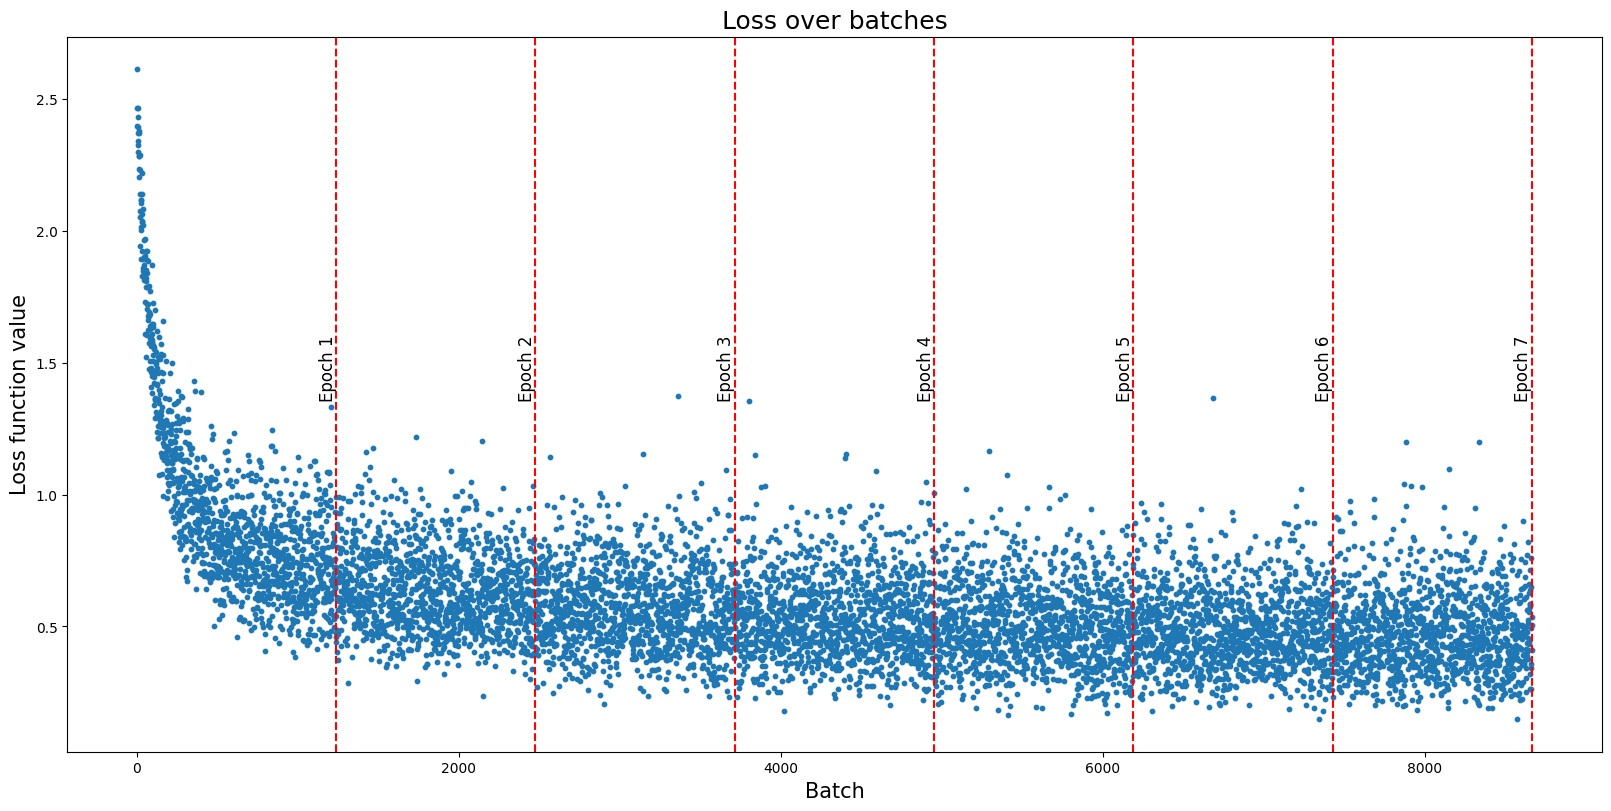

In [85]:
cnn_forwd = ConvForwNNd()
optimizer = torch.optim.Adam(cnn_forwd.parameters(), weight_decay = 0.0001)
train_NN2(train_loader, val_loader, cnn_forwd, loss_function, optimizer, 7, False, True)

  0%|                                                     | 0/7 [00:00<?, ?it/s]

Epoch number 1:


 14%|██████▍                                      | 1/7 [00:31<03:06, 31.10s/it]

Train loss: 0.964, Validation loss: 0.566, Accuraccy: 0.794
Saving best neural network.
Epoch number 2:


 29%|████████████▊                                | 2/7 [01:07<02:50, 34.10s/it]

Train loss: 0.640, Validation loss: 0.483, Accuraccy: 0.821
Saving best neural network.
Epoch number 3:


 43%|███████████████████▎                         | 3/7 [01:36<02:07, 31.88s/it]

Train loss: 0.575, Validation loss: 0.445, Accuraccy: 0.834
Saving best neural network.
Epoch number 4:


 57%|█████████████████████████▋                   | 4/7 [02:08<01:35, 31.92s/it]

Train loss: 0.540, Validation loss: 0.423, Accuraccy: 0.845
Saving best neural network.
Epoch number 5:


 71%|████████████████████████████████▏            | 5/7 [02:39<01:03, 31.68s/it]

Train loss: 0.516, Validation loss: 0.414, Accuraccy: 0.849
Saving best neural network.
Epoch number 6:


 86%|██████████████████████████████████████▌      | 6/7 [03:08<00:30, 30.73s/it]

Train loss: 0.499, Validation loss: 0.392, Accuraccy: 0.857
Saving best neural network.
Epoch number 7:


100%|█████████████████████████████████████████████| 7/7 [03:38<00:00, 31.21s/it]

Train loss: 0.487, Validation loss: 0.389, Accuraccy: 0.857
No improvement in this epoch.


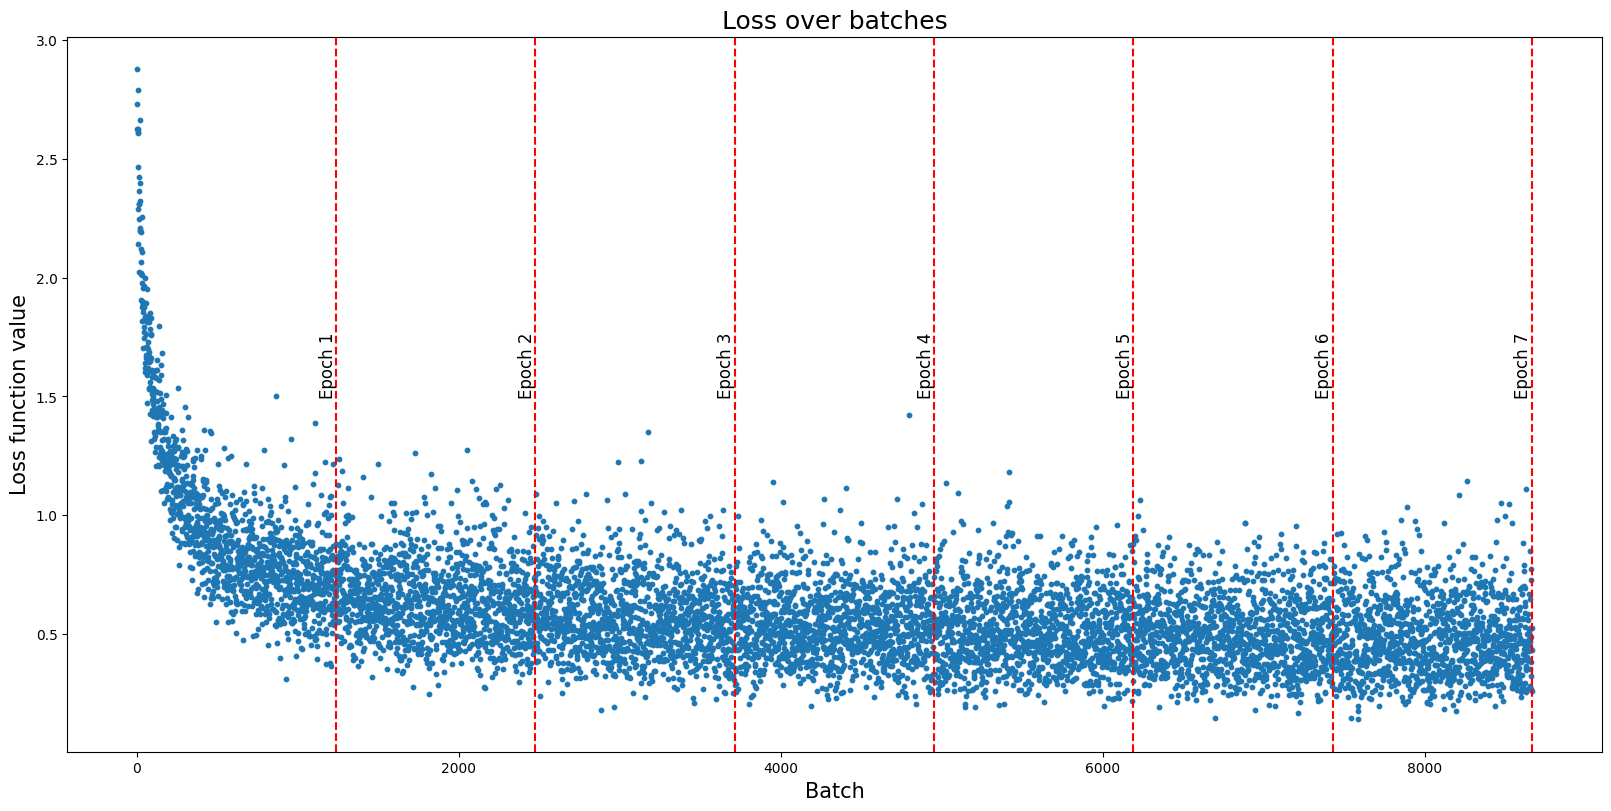

In [86]:
cnn_forwd = ConvForwNNd()
optimizer = torch.optim.Adam(cnn_forwd.parameters(), weight_decay = 0.0001)
train_NN2(train_scaled_loader, val_scaled_loader, cnn_forwd, loss_function, optimizer, 7, False, True)

  0%|                                                     | 0/7 [00:00<?, ?it/s]

Epoch number 1:


 14%|██████▍                                      | 1/7 [00:37<03:43, 37.32s/it]

Train loss: 0.894, Validation loss: 0.534, Accuraccy: 0.802
Saving best neural network.
Epoch number 2:


 29%|████████████▊                                | 2/7 [01:12<02:59, 35.98s/it]

Train loss: 0.582, Validation loss: 0.450, Accuraccy: 0.834
Saving best neural network.
Epoch number 3:


 43%|███████████████████▎                         | 3/7 [01:52<02:32, 38.01s/it]

Train loss: 0.523, Validation loss: 0.405, Accuraccy: 0.848
Saving best neural network.
Epoch number 4:


 57%|█████████████████████████▋                   | 4/7 [02:33<01:57, 39.03s/it]

Train loss: 0.483, Validation loss: 0.379, Accuraccy: 0.857
Saving best neural network.
Epoch number 5:


 71%|████████████████████████████████▏            | 5/7 [03:12<01:18, 39.07s/it]

Train loss: 0.462, Validation loss: 0.367, Accuraccy: 0.863
Saving best neural network.
Epoch number 6:


 86%|██████████████████████████████████████▌      | 6/7 [03:54<00:40, 40.02s/it]

Train loss: 0.444, Validation loss: 0.353, Accuraccy: 0.862
No improvement in this epoch.
Epoch number 7:


100%|█████████████████████████████████████████████| 7/7 [04:29<00:00, 38.47s/it]

Train loss: 0.424, Validation loss: 0.340, Accuraccy: 0.873
Saving best neural network.


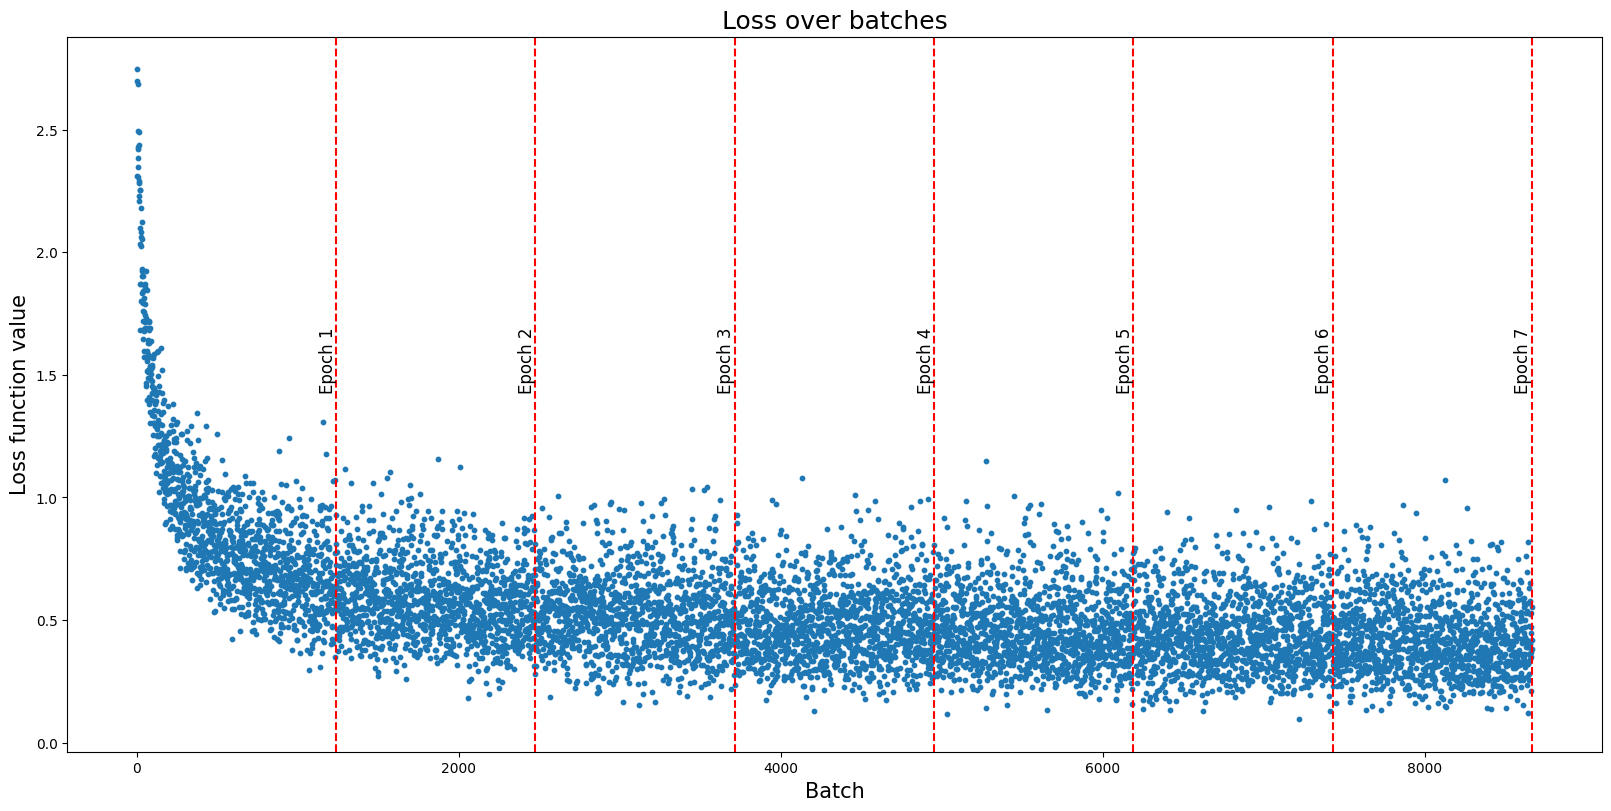

In [87]:
cnn_forw2d = ConvForwNN2d()
optimizer = torch.optim.Adam(cnn_forw2d.parameters(), weight_decay = 0.0001)
train_NN2(train_loader, val_loader, cnn_forw2d, loss_function, optimizer, 7, False, True)

  0%|                                                     | 0/7 [00:00<?, ?it/s]

Epoch number 1:


 14%|██████▍                                      | 1/7 [00:35<03:33, 35.59s/it]

Train loss: 0.876, Validation loss: 0.530, Accuraccy: 0.808
Saving best neural network.
Epoch number 2:


 29%|████████████▊                                | 2/7 [01:15<03:10, 38.12s/it]

Train loss: 0.584, Validation loss: 0.445, Accuraccy: 0.837
Saving best neural network.
Epoch number 3:


 43%|███████████████████▎                         | 3/7 [01:52<02:30, 37.71s/it]

Train loss: 0.523, Validation loss: 0.415, Accuraccy: 0.848
Saving best neural network.
Epoch number 4:


 57%|█████████████████████████▋                   | 4/7 [02:34<01:57, 39.17s/it]

Train loss: 0.493, Validation loss: 0.393, Accuraccy: 0.854
Saving best neural network.
Epoch number 5:


 71%|████████████████████████████████▏            | 5/7 [03:14<01:19, 39.67s/it]

Train loss: 0.468, Validation loss: 0.383, Accuraccy: 0.856
Saving best neural network.
Epoch number 6:


 86%|██████████████████████████████████████▌      | 6/7 [03:49<00:38, 38.17s/it]

Train loss: 0.454, Validation loss: 0.373, Accuraccy: 0.859
Saving best neural network.
Epoch number 7:


100%|█████████████████████████████████████████████| 7/7 [04:24<00:00, 37.80s/it]

Train loss: 0.438, Validation loss: 0.365, Accuraccy: 0.862
Saving best neural network.


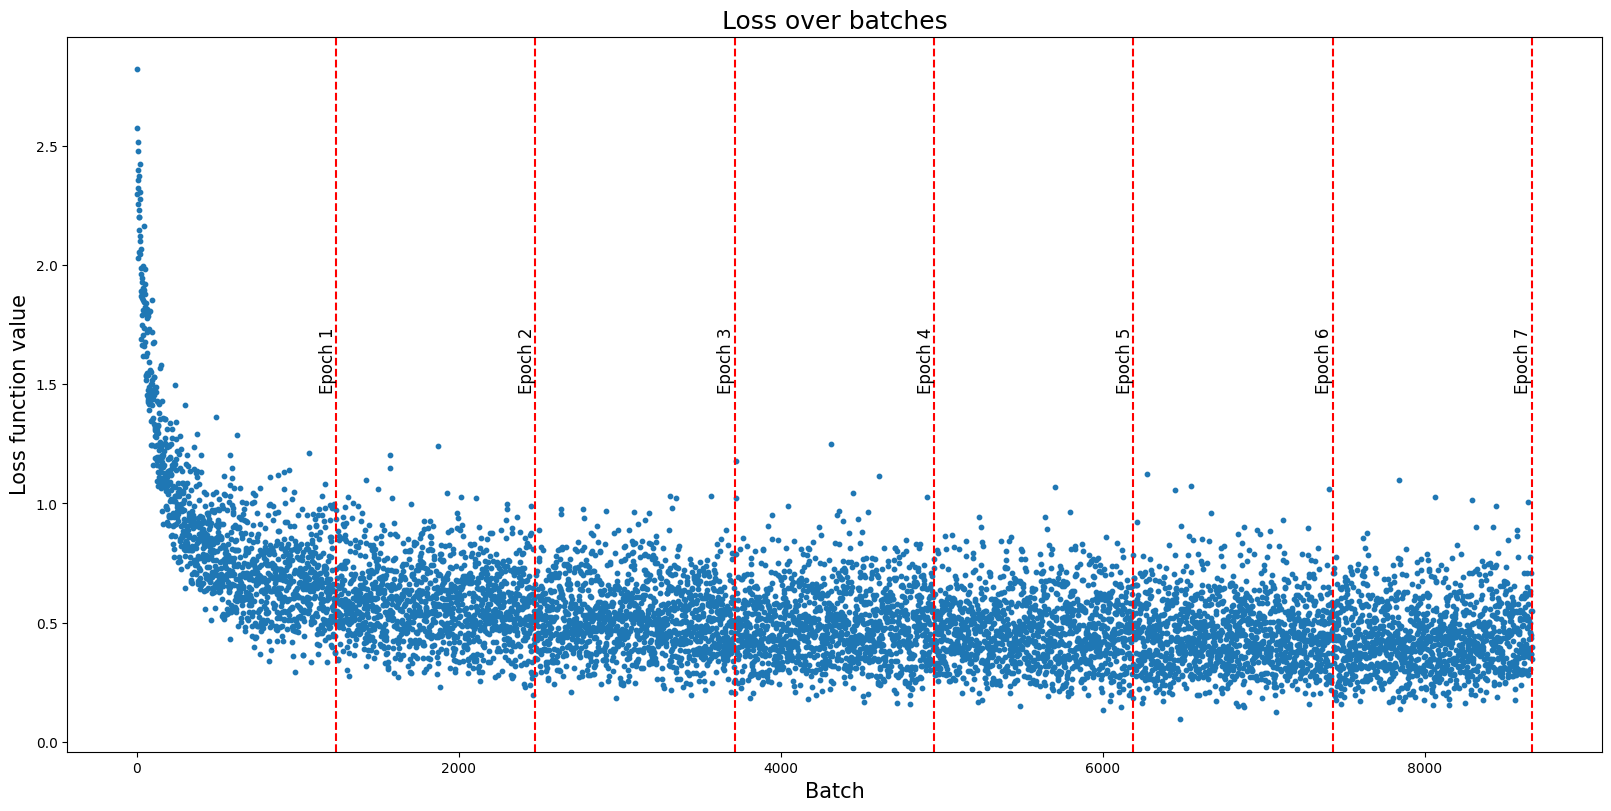

In [88]:
cnn_forw2d = ConvForwNN2d()
optimizer = torch.optim.Adam(cnn_forw2d.parameters(), weight_decay = 0.0001)
train_NN2(train_scaled_loader, val_scaled_loader, cnn_forw2d, loss_function, optimizer, 7, False, True)

We could not reach a higher accuracy than we had before. </br>
Now we will modify the neural netowrk a bit and train our `final model` on `13 epochs`.

In [89]:
class ConvForwNN3d(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, padding = 2)
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 5, padding = 1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2_drop = nn.Dropout2d(p=0.5)
        
        self.conv3 = nn.Conv2d(32, 32, 3, padding = 1)
        self.conv3_bn = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(2, 1)
        
        self.conv4 = nn.Conv2d(32, 16, 3)
        self.conv4_bn = nn.BatchNorm2d(16)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(16*6*6, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        self.fc1_drop = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(256, 32)
        self.fc2_bn = nn.BatchNorm1d(32)
        self.fco = nn.Linear(32, 10)
        
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.zeros_(self.conv3.bias)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_normal_(self.fco.weight)
        nn.init.zeros_(self.fco.bias)

    def forward(self, x):
        x = self.conv1(x.to(self.conv1.weight.dtype))
        x = self.conv1_bn(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv2_drop(x)
        
        x = self.conv3(x)
        x = self.conv3_bn(x)
        x = F.relu(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.conv4_bn(x)
        x = F.relu(x)
        x = self.pool4(x)
        
        x = x.flatten(start_dim = 1)
        x = self.fc1(x)
        x = self.fc1_bn(x)
        x = F.relu(x)
        x = self.fc1_drop(x)
        x = self.fc2(x)
        x = self.fc2_bn(x)
        x = F.relu(x)
        x = self.fco(x)
        
        return x
    
    def predict_proba(self, x):
        with torch.no_grad():
            pred = self.forward(x)
            probabilities = F.softmax(pred, dim=1)
        return probabilities

    def predict(self, x):
        probabilities = self.predict_proba(x)
        with torch.no_grad():
            max_probabilities, predicted_classes = torch.max(probabilities, dim=1)
        return predicted_classes

  0%|                                                    | 0/13 [00:00<?, ?it/s]

Epoch number 1:


  8%|███▍                                        | 1/13 [01:26<17:14, 86.17s/it]

Train loss: 0.710, Validation loss: 0.432, Accuraccy: 0.840
Saving best neural network.
Epoch number 2:


 15%|██████▊                                     | 2/13 [02:54<16:04, 87.70s/it]

Train loss: 0.455, Validation loss: 0.366, Accuraccy: 0.863
Saving best neural network.
Epoch number 3:


 23%|██████████▏                                 | 3/13 [04:26<14:55, 89.54s/it]

Train loss: 0.392, Validation loss: 0.346, Accuraccy: 0.871
Saving best neural network.
Epoch number 4:


 31%|█████████████▌                              | 4/13 [05:52<13:13, 88.17s/it]

Train loss: 0.360, Validation loss: 0.316, Accuraccy: 0.880
Saving best neural network.
Epoch number 5:


 38%|████████████████▉                           | 5/13 [07:16<11:33, 86.72s/it]

Train loss: 0.337, Validation loss: 0.309, Accuraccy: 0.883
Saving best neural network.
Epoch number 6:


 46%|████████████████████▎                       | 6/13 [08:46<10:13, 87.68s/it]

Train loss: 0.317, Validation loss: 0.314, Accuraccy: 0.884
Saving best neural network.
Epoch number 7:


 54%|███████████████████████▋                    | 7/13 [10:16<08:49, 88.30s/it]

Train loss: 0.303, Validation loss: 0.297, Accuraccy: 0.893
Saving best neural network.
Epoch number 8:


 62%|███████████████████████████                 | 8/13 [11:41<07:16, 87.39s/it]

Train loss: 0.293, Validation loss: 0.297, Accuraccy: 0.893
Saving best neural network.
Epoch number 9:


 69%|██████████████████████████████▍             | 9/13 [13:07<05:48, 87.04s/it]

Train loss: 0.282, Validation loss: 0.295, Accuraccy: 0.894
Saving best neural network.
Epoch number 10:


 77%|█████████████████████████████████          | 10/13 [14:34<04:21, 87.05s/it]

Train loss: 0.272, Validation loss: 0.295, Accuraccy: 0.895
Saving best neural network.
Epoch number 11:


 85%|████████████████████████████████████▍      | 11/13 [16:01<02:53, 87.00s/it]

Train loss: 0.261, Validation loss: 0.281, Accuraccy: 0.897
Saving best neural network.
Epoch number 12:


 92%|███████████████████████████████████████▋   | 12/13 [17:28<01:27, 87.03s/it]

Train loss: 0.253, Validation loss: 0.280, Accuraccy: 0.899
Saving best neural network.
Epoch number 13:


100%|███████████████████████████████████████████| 13/13 [18:51<00:00, 87.06s/it]

Train loss: 0.246, Validation loss: 0.283, Accuraccy: 0.895
No improvement in this epoch.


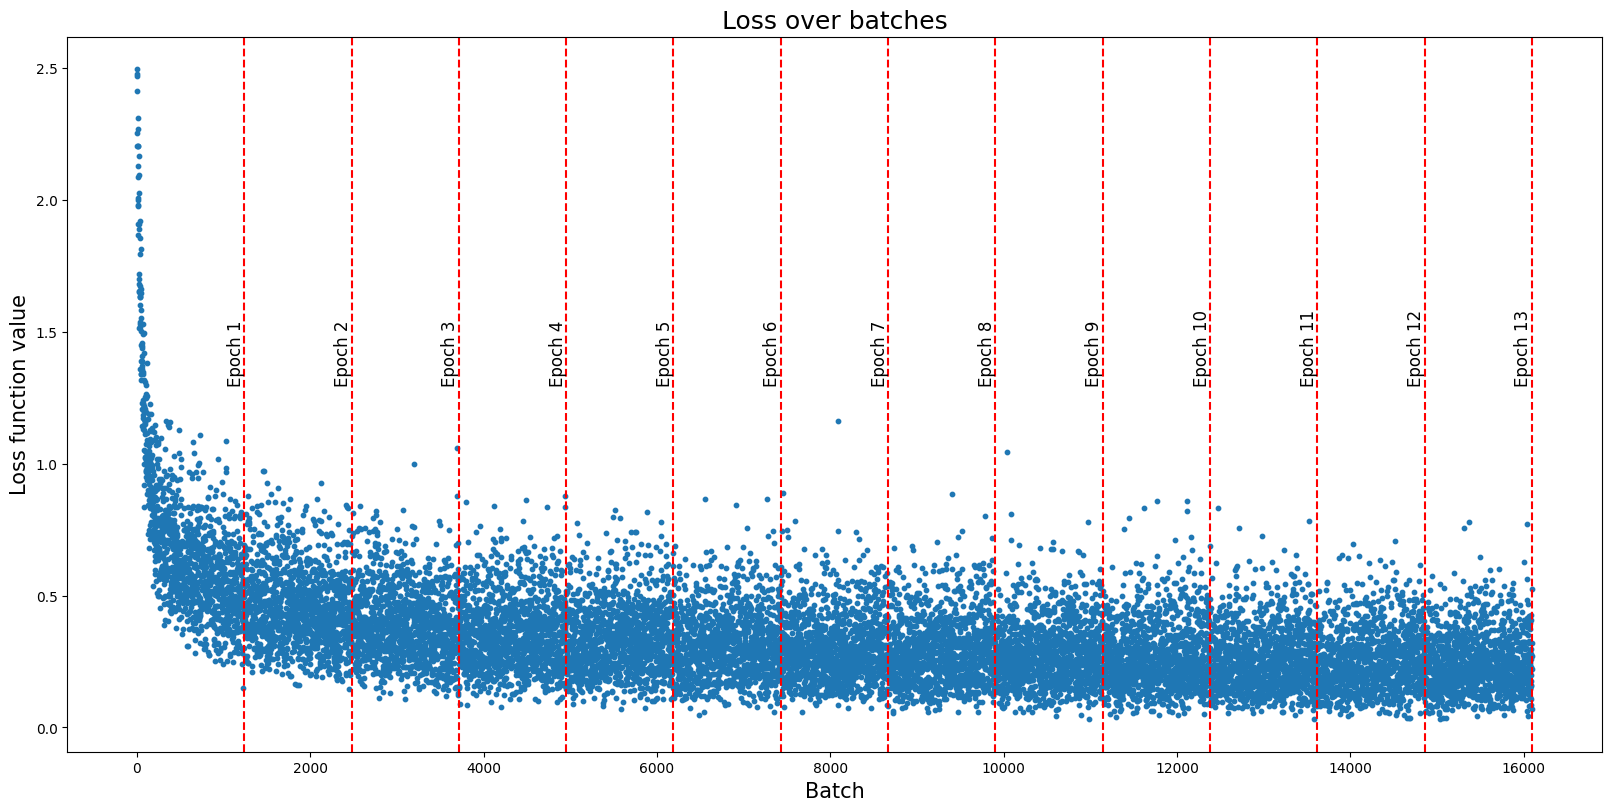

In [90]:
cnn_forw3d = ConvForwNN3d()
optimizer = torch.optim.Adam(cnn_forw3d.parameters(), weight_decay = 0.0001)
train_NN2(train_scaled_loader, val_scaled_loader, cnn_forw3d, loss_function, optimizer, 13, False, True)

In result we achieved the `highest validation accuracy`. Now let's look at the accuracy of the data, which we haven't had before.

In [99]:
best_model = ConvForwNN3d()
best_model.load_state_dict(torch.load("saves/best_model.pt"))
best_model.train(False)

test_predictions = np.zeros(len(test_scaled_dataset))
test_y = np.zeros(len(test_scaled_dataset))
print(f"The number of test data: {test_predictions.shape}.")

ii = 0
for test_data in tqdm(test_scaled_loader):
    test_inputs, test_labels = test_data
    
    with torch.no_grad():
        test_output = best_model.predict(test_inputs)
        
    test_predictions[ii:(ii + test_inputs.shape[0])] = test_output.numpy()
    test_y[ii:(ii + test_inputs.shape[0])] = test_labels.numpy()
    ii += test_inputs.shape[0]
    
score = metrics.accuracy_score(test_y, test_predictions)
print(f"Accuracy of the model, that we can expect on the new data: {score:.3f}")

cnf_matrix = confusion_matrix(test_y, test_predictions)
print(f"Confussion matrix:\n{cnf_matrix}")

The number of test data: (8400,).


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 11.89it/s]

Accuracy of the model, that we can expect on the new data: 0.902
Confussion matrix:
[[753   1   7  19   2   0  41   0   3   1]
 [  0 848   0  15   1   0   3   0   0   0]
 [ 10   1 774  10  55   0  46   0   0   0]
 [ 33   2   4 716  36   0  12   0   3   0]
 [  2   2  49  28 687   0  74   0   1   0]
 [  0   0   1   3   0 808   0  21   1   7]
 [133   0  51  17  33   1 576   0   6   0]
 [  0   0   0   0   0   9   0 820   0  18]
 [  2   0   1   4   4   3   5   1 826   2]
 [  0   0   0   0   0   2   0  35   0 771]]


### Predictions for the file evaluate.csv

Let's read data from file **evaluate.csv** and make sure that there are no null values in this data and that all features are of type int64.

In [96]:
evaluation = pd.read_csv("evaluate.csv")

In [97]:
print(f"Data dimensions: {evaluation.shape}")
print(f"Data types of all variables:\n{evaluation.dtypes.value_counts().to_string(index=True, name=False)}")
print(f"Amount of null values in evaluation data - {(len(evaluation.columns[data.isnull().any()]))}")
display(evaluation.head(10))

Data dimensions: (14000, 1025)
Data types of all variables:
int64    1025
Amount of null values in evaluation data - 0


ID  pix1  pix2  pix3  pix4  pix5  pix6  pix7  pix8  pix9  ...  pix1015   
0   0     0     0     0     0     0     0     0     0     0  ...        0  \
1   1     0     0     0     0     0     0     0     0     0  ...        0   
2   2     2     2     2     2     2     2     2     2     2  ...        2   
3   3     0     0     0     0     0     0     0     0     0  ...        0   
4   4     0     0     0     0     0     0     0     0     0  ...        0   
5   5     0     0     0     0     0     0     0     0     0  ...        0   
6   6     0     0     0     0     0     0     0     0     0  ...        0   
7   7     0     0     0     0     0     0     0     0     0  ...        0   
8   8     2     2     2     2     2     2     2     2     2  ...        2   
9   9     7     7     7     7     7     7     7     7     7  ...        7   

   pix1016  pix1017  pix1018  pix1019  pix1020  pix1021  pix1022  pix1023   
0        0        0        0        0        0        0        0        0  \
1        0        0        0        0        0        0        0        0   
2        2        2        2        2        2        2        2        2   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   
5        0        0        0        0        0        0        0        0   
6        0        0        0        0        0        0        0        0   
7        0        0        0        0        0        0        0        0   
8        2        2        2        2        2        2        2        2   
9        7        7        7        7        7        7        7        7   

   pix1024  
0        0  
1        0  
2        2  
3        0  
4        0  
5        0  
6        0  
7        0  
8        2  
9        7  

[10 rows x 1025 columns]

In [98]:
features_ev = evaluation.drop("ID", axis=1)
id_ev = evaluation["ID"]

In [112]:
evaluation_s = scaler.transform(features_ev)
evaluation_tensor = tensor(evaluation_s, dtype=torch.float).view(-1, 1, 32, 32)
results = []
for evaluation_input in tqdm(evaluation_tensor):
    with torch.no_grad():
        evaluation_output = best_model.predict(evaluation_input.unsqueeze(1))
        results.append(evaluation_output.numpy()[0])

100%|████████████████████████████████████| 14000/14000 [00:16<00:00, 865.89it/s]


In [115]:
print(f"There are {len(set(results))} predicted values: {set(results)}")

There are 10 predicted values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


Writing the results into a file **results.csv**.

In [114]:
results = pd.Series(results, name="label")
result_df = pd.concat([id_ev, results], axis=1)
result_df.to_csv("results.csv", index=False)

**That's all :)**